# **Final Project**

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
import numpy as np
import matplotlib.pyplot as plt

aspect_ratio = (12, 8) # if plotting inline
annualization_factor = 256

In [2]:
def read_price_data(filename, index_col=0, parse_dates=True):
    """
    Reads a CSV file and performs basic exploratory data analysis.
    """
    df = pd.read_csv(filename, index_col=index_col, parse_dates=parse_dates)

    print("--- DataFrame Info ---")
    print(df.info())

    print("\n--- Null Values ---")
    print(df.isnull().sum())

    print("\n--- Summary Statistics ---")
    print(df.describe())

    print("\n--- Data Preview ---")
    print(df)

    return df

In [3]:
def plot_and_format_y_axis(data_frame, formatter=ticker.ScalarFormatter(),
                            aspect_ratio=(12, 8), title='', ylabel='', grid=True):
    fig, ax = plt.subplots(figsize=aspect_ratio)
    data_frame.plot(ax=ax)
    ax.yaxis.set_major_formatter(formatter)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(grid)
    plt.show()

In [4]:
def print_pct_data(df, fmt="{:.4f}%", na_rep="NaN", index_slice=None):
    """
    Formats a Pandas DataFrame to display numerical values as percentages for selected rows,
    while keeping other values unchanged.
    """
    df_copy = df.copy()  # Create a copy to avoid modifying the original DataFrame

    if index_slice is not None:
        # Multiply only the selected rows by 100 to convert decimals to percentages
        df_copy.loc[index_slice] *= 100

        # Apply a lambda function to enforce the % symbol in the formatted output
        return df_copy.style.format(lambda x: fmt.format(x) if pd.notnull(x) else na_rep, subset=pd.IndexSlice[index_slice, :])

    return df_copy.style.format(fmt, na_rep=na_rep)

In [5]:
def calcPerformanceStatistics(df_logReturns, annualization_factor=260, print_Screen=True, fmt="{:.4f}%", na_rep="NaN"):

    # Removing the the first NaN row for calculation
    final_returns = df_logReturns.dropna()

    # Calculting Cumulative returns
    cumulative_returns = final_returns.cumsum()

    # NAV calculation with filling NaN with 0
    nav = cumulative_returns.fillna(0)

    # Calculating all Performance metrics
    annual_return = final_returns.mean() * annualization_factor
    annualized_risk = final_returns.std() * np.sqrt(annualization_factor)
    sharpe_ratio = annual_return / annualized_risk
    max_drawdown = (nav - nav.cummax()).min()
    success_ratio = (final_returns > 0).mean()

    # Create statistics DataFrame
    perf_metrics = pd.DataFrame({
        'Average Annual Return': annual_return,
        'Annual Risk': annualized_risk,
        'Sharpe Ratio': sharpe_ratio,
        'maxDD': max_drawdown,
        'Success Ratio': success_ratio
    }).T.rename(columns={0: 'Value'})
    index_slice = ['Average Annual Return', 'Annual Risk', 'maxDD', 'Success Ratio']

    # Print results if required
    if print_Screen:
        return print_pct_data(perf_metrics, fmt=fmt, na_rep=na_rep, index_slice=index_slice)

    return perf_metrics


In [6]:
def movingAverageCrossover(df, fastWindow, slowWindow):
    """
    Implements Moving Average Crossover strategy for given windows.
    Returns a DataFrame with Benchmark, MA Flat, and MA Short strategy returns using log returns.
    """
    if df.shape[1] != 1:
        raise ValueError("Input DataFrame must have only one column")

    instrument_name = df.columns[0]
    df = df.copy()

    # Compute moving averages
    df['fastMA'] = df[instrument_name].rolling(window=fastWindow).mean()
    df['slowMA'] = df[instrument_name].rolling(window=slowWindow).mean()
    
    # Drop NaN values that result from rolling calculations
    df.dropna(inplace=True)

    # Define signals
    df['signal_flat'] = np.where(df['fastMA'] > df['slowMA'], 1, 0)  # Flat: Hold or Stay in cash
    df['signal_short'] = np.where(df['fastMA'] > df['slowMA'], 1, -1)  # Short: Hold or Short Sell

    # Compute log returns
    df['log_returns'] = np.log(df[instrument_name] / df[instrument_name].shift(1))

    # Apply signals with a lag (to avoid lookahead bias)
    df['MAFlat_log_returns'] = df['log_returns'] * df['signal_flat'].shift(1)
    df['MAShort_log_returns'] = df['log_returns'] * df['signal_short'].shift(1)

    # Prepare output DataFrame
    output_df = df[['log_returns', 'MAFlat_log_returns', 'MAShort_log_returns']].copy()
    output_df.columns = [f'{instrument_name}-BMK-MA', f'{instrument_name}-MAFlat', f'{instrument_name}-MAShort']

    return output_df




In [7]:
import pandas as pd
import numpy as np

def bollingerBands(df, lookbackWindow, stdevBand):
    """
    Implements the Bollinger Bands strategy with log returns.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing only one column of prices.
        lookbackWindow (int): The lookback period for calculating the moving average and standard deviation.
        stdevBand (float): The number of standard deviations for the upper and lower Bollinger Bands.
    
    Returns:
        pd.DataFrame: DataFrame with benchmark log returns and Bollinger Band strategy log returns.
    """
    if df.shape[1] != 1:
        raise ValueError("Input DataFrame must have only one column of prices.")

    instrument = df.columns[0]
    df = df.copy()

    # Compute Bollinger Bands
    df['Mean'] = df[instrument].rolling(window=lookbackWindow).mean()
    df['Std'] = df[instrument].rolling(window=lookbackWindow).std()
    df['Upper'] = df['Mean'] + (stdevBand * df['Std'])
    df['Lower'] = df['Mean'] - (stdevBand * df['Std'])

    # Initialize Position column
    df['Position'] = 0
    
    for i in range(1, df.shape[0]):
        today, yesterday = df.index[i], df.index[i-1]

        if df.loc[today, instrument] >= df.loc[today, 'Upper']:
            df.loc[today, 'Position'] = -1
        elif df.loc[today, instrument] <= df.loc[today, 'Lower']:
            df.loc[today, 'Position'] = 1
        elif df.loc[yesterday, 'Position'] == -1 and df.loc[today, instrument] <= df.loc[today, 'Mean']:
            df.loc[today, 'Position'] = 0
        elif df.loc[yesterday, 'Position'] == 1 and df.loc[today, instrument] >= df.loc[today, 'Mean']:
            df.loc[today, 'Position'] = 0
        else:
            df.loc[today, 'Position'] = df.loc[yesterday, 'Position']

    # Compute log returns instead of pct_change
    df['Log Return'] = np.log(df[instrument] / df[instrument].shift(1))
    df[instrument + '-BMK-BB'] = df['Log Return']
    df[instrument + '-BB'] = df['Position'].shift(1) * df['Log Return']

    return df[[instrument + '-BMK-BB', instrument + '-BB']].dropna()

# 1

In [8]:
import pandas as pd

def runMovingAverageAndBB(df, fastWindow, slowWindow, bbWindow, stdevBand):
    """
    Runs both the Moving Average Crossover and Bollinger Bands strategies,
    then inner-joins their results to return a single DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing only one column of prices.
        fastWindow (int): Fast moving average window for MA crossover.
        slowWindow (int): Slow moving average window for MA crossover.
        bbWindow (int): Lookback period for Bollinger Bands.
        stdevBand (float): Standard deviation multiplier for Bollinger Bands.
    
    Returns:
        pd.DataFrame: Inner-joined results of both strategies with 5 columns.
    """
    # Run both strategies
    ma_results = movingAverageCrossover(df, fastWindow, slowWindow)
    bb_results = bollingerBands(df, bbWindow, stdevBand)

    # Inner join on index (dates)
    combined_df = ma_results.join(bb_results, how='inner')

    # Drop NaN values
    combined_df.dropna(inplace=True)

    return combined_df

# 2

In [9]:
dfPrices= read_price_data("PricesForProject.csv")

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4780 entries, 1999-12-31 to 2018-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    4780 non-null   float64
 1   CAD     4780 non-null   float64
 2   EXC     4780 non-null   float64
 3   FBNDX   4780 non-null   float64
 4   GBP     4780 non-null   float64
 5   GE      4780 non-null   float64
 6   INTC    4780 non-null   float64
 7   PFE     4780 non-null   float64
 8   SPGSCI  4780 non-null   float64
 9   SPY     4780 non-null   float64
 10  VBTIX   4780 non-null   float64
 11  XPT     4780 non-null   float64
dtypes: float64(12)
memory usage: 485.5 KB
None

--- Null Values ---
AAPL      0
CAD       0
EXC       0
FBNDX     0
GBP       0
GE        0
INTC      0
PFE       0
SPGSCI    0
SPY       0
VBTIX     0
XPT       0
dtype: int64

--- Summary Statistics ---
              AAPL          CAD          EXC        FBNDX          GBP  \
count 

# 3

In [10]:
# We chose benchmarks for reference here 
selected_securities = ['AAPL', 'EXC', 'INTC', 'PFE', 'SPGSCI', 'FBNDX', 'GBP', 'GE']
df_selected = dfPrices[selected_securities]

# Calculate log returns
df_logReturns = np.log(df_selected / df_selected.shift(1))

# Assign equal weights (assuming an equally weighted portfolio)
n_assets = len(selected_securities)
weights = np.full(n_assets, 1 / n_assets)  # Equal weight for all

# Compute Portfolio Log Returns
df_logReturns['Portfolio'] = df_logReturns.dot(weights)

# Run performance statistics
perf_stats = calcPerformanceStatistics(df_logReturns[['Portfolio']], annualization_factor=260)

# Display performance statistics
perf_stats

,Portfolio
Average Annual Return,2.5482%
Annual Risk,14.8696%
Sharpe Ratio,0.171367
maxDD,-72.8174%
Success Ratio,52.4377%


# EDA to determine the perfect pick of securities

In [11]:
dfLogReturns = np.log(dfPrices / dfPrices.shift(1))
dfCumulativeLogReturns = dfLogReturns.cumsum()

dfCumulativeLogReturns.tail()

,AAPL,CAD,EXC,FBNDX,GBP,GE,INTC,PFE,SPGSCI,SPY,VBTIX,XPT
Date,,,,,,,,,,,,
2018-12-24,3.688573,0.061606,0.925286,0.108548,-0.241825,-2.008783,0.057452,0.223221,0.635535,0.467191,0.087099,0.574313
2018-12-26,3.756625,0.063299,0.940007,0.104635,-0.247587,-1.943071,0.115388,0.262868,0.670140,0.516481,0.083256,0.588979
2018-12-27,3.750114,0.059989,0.946729,0.102017,-0.246717,-1.959442,0.119061,0.278390,0.654098,0.524129,0.084218,0.588038
2018-12-28,3.750627,0.058595,0.945836,0.105941,-0.242376,-1.926963,0.127438,0.280954,0.656256,0.522838,0.087099,0.580162
2018-12-31,3.760245,0.058669,0.953850,0.107246,-0.238055,-1.919006,0.131281,0.296888,0.654510,0.531559,0.089014,0.586719


In [12]:
dfLogReturns.corr()

,AAPL,CAD,EXC,FBNDX,GBP,GE,INTC,PFE,SPGSCI,SPY,VBTIX,XPT
AAPL,1.000000,0.184242,0.159352,-0.132618,0.037025,0.338322,0.470896,0.192238,0.096118,0.496258,-0.167774,0.075696
CAD,0.184242,1.000000,0.266832,-0.025196,0.433278,0.291454,0.227199,0.213328,0.404123,0.435035,-0.096089,0.302979
EXC,0.159352,0.266832,1.000000,-0.027070,0.134645,0.291936,0.220837,0.312119,0.167550,0.454558,-0.072417,0.137871
FBNDX,-0.132618,-0.025196,-0.027070,1.000000,0.085658,-0.173092,-0.162509,-0.098324,-0.060624,-0.203950,0.902006,0.045946
GBP,0.037025,0.433278,0.134645,0.085658,1.000000,0.109231,0.047250,0.070876,0.237088,0.168779,0.053797,0.243863
GE,0.338322,0.291454,0.291936,-0.173092,0.109231,1.000000,0.422825,0.407958,0.147968,0.692634,-0.234342,0.095910
INTC,0.470896,0.227199,0.220837,-0.162509,0.047250,0.422825,1.000000,0.278899,0.107212,0.645388,-0.207907,0.076363
PFE,0.192238,0.213328,0.312119,-0.098324,0.070876,0.407958,0.278899,1.000000,0.091329,0.560751,-0.144505,0.058517
SPGSCI,0.096118,0.404123,0.167550,-0.060624,0.237088,0.147968,0.107212,0.091329,1.000000,0.245685,-0.129130,0.322893
SPY,0.496258,0.435035,0.454558,-0.203950,0.168779,0.692634,0.645388,0.560751,0.245685,1.000000,-0.298902,0.168043


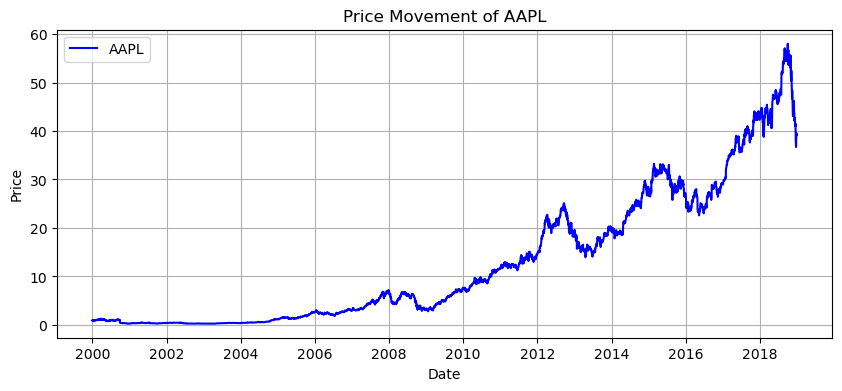

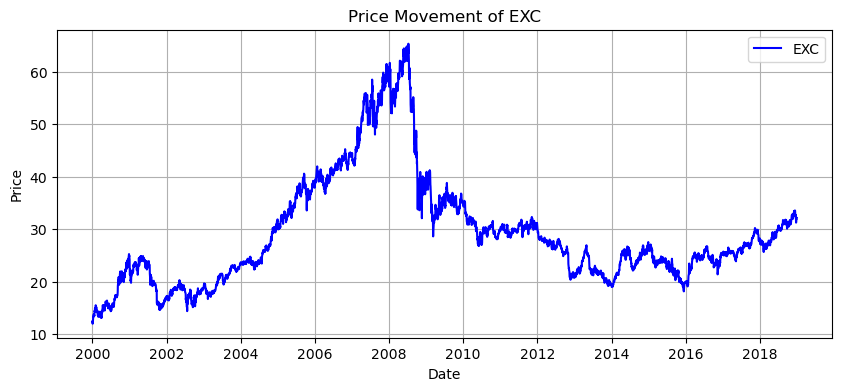

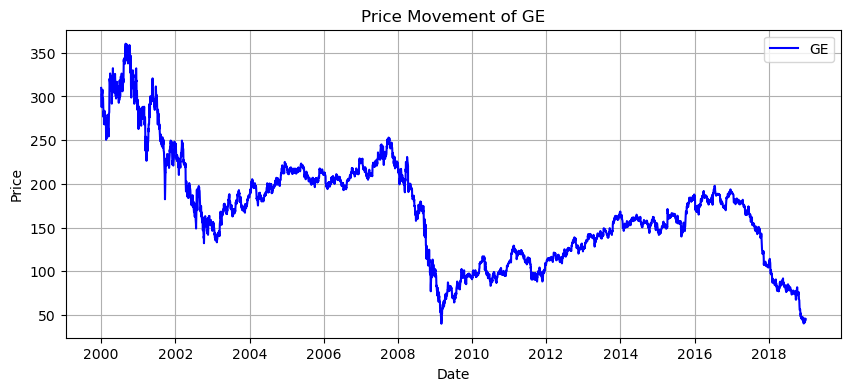

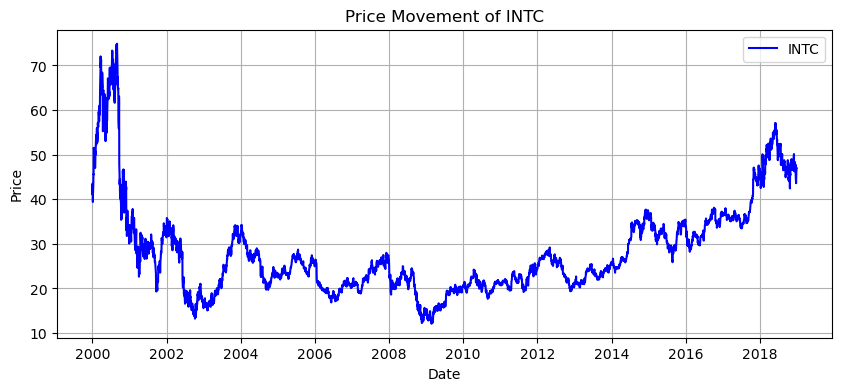

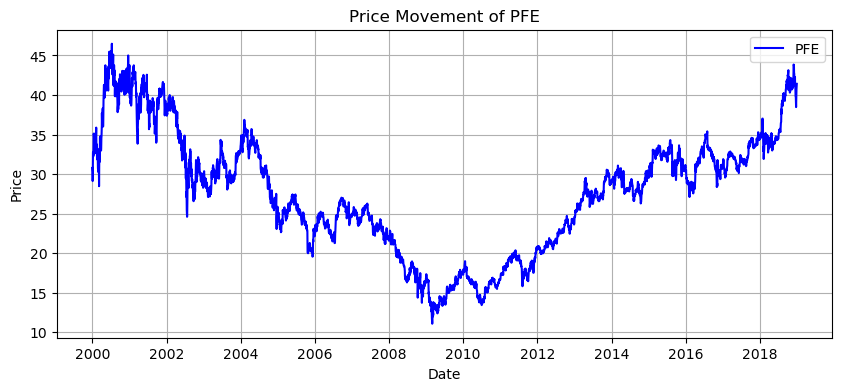

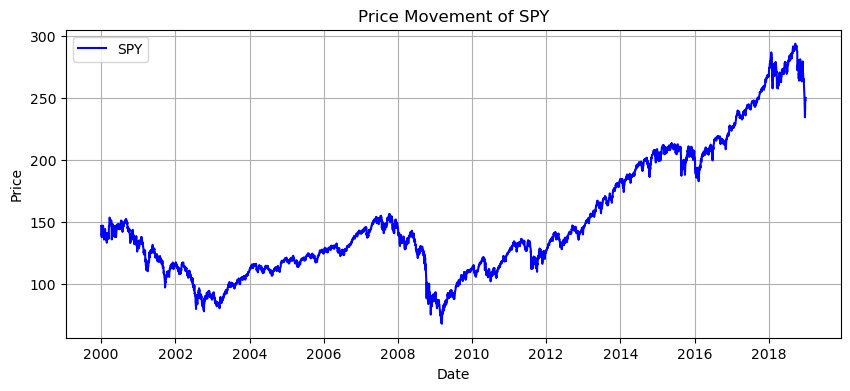

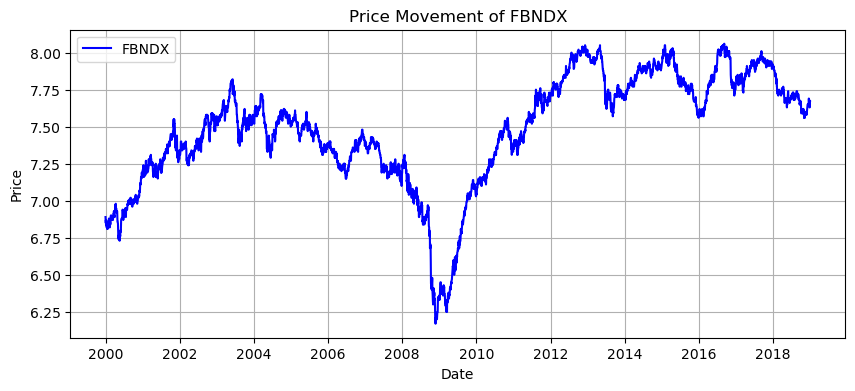

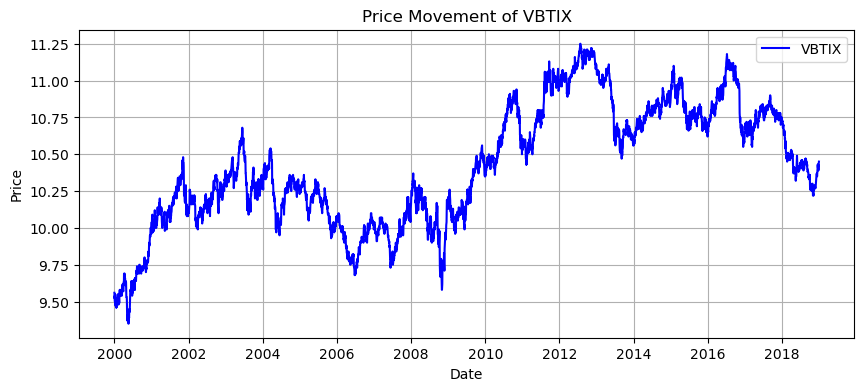

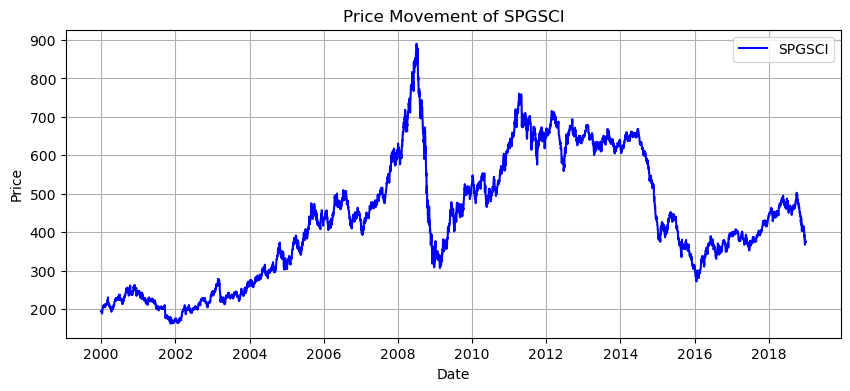

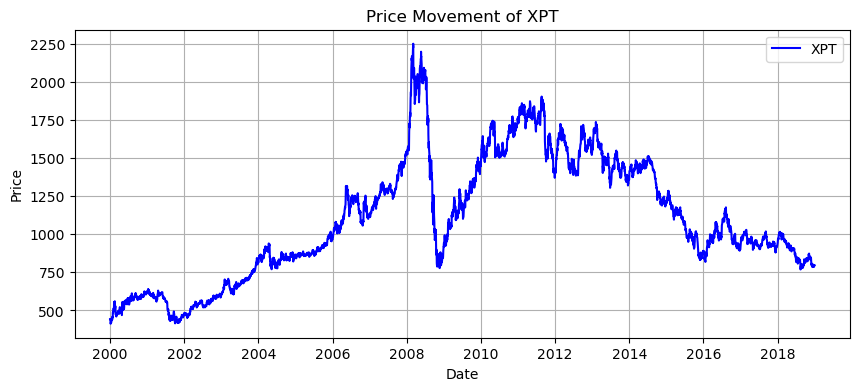

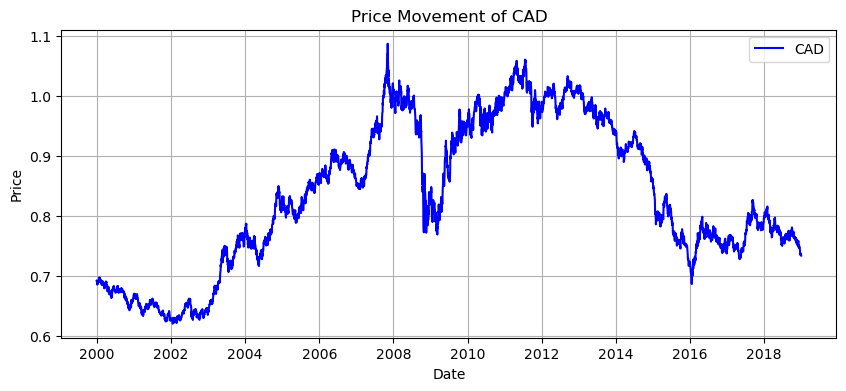

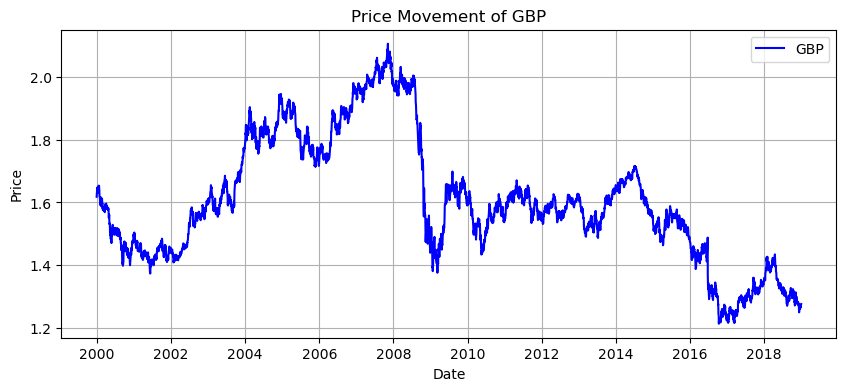

In [14]:
# List of all 12 securities
securities = ['AAPL', 'EXC', 'GE', 'INTC', 'PFE', 'SPY',  # Equities
              'FBNDX', 'VBTIX',  # Fixed Income
              'SPGSCI', 'XPT',  # Commodities
              'CAD', 'GBP']  # Currencies

# Plot each security individually
for security in securities:
    if security in dfPrices.columns:  # Ensure the column exists
        plt.figure(figsize=(10, 4))
        plt.plot(dfPrices.index, dfPrices[security], label=security, color='blue')
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.title(f"Price Movement of {security}")
        plt.legend()
        plt.grid(True)
        plt.show()

In [15]:
# List of all 12 securities
securities = ['AAPL', 'EXC', 'GE', 'INTC', 'PFE', 'SPY',  # Equities
              'FBNDX', 'VBTIX',  # Fixed Income
              'SPGSCI', 'XPT',  # Commodities
              'CAD', 'GBP']  # Currencies

# Loop through each security and create a separate DataFrame
for security in securities:
    if security in dfPrices.columns:  # Ensure the column exists
        globals()[f"df{security}"] = dfPrices[[security]]  # Create variable dynamically

# Example: Print extracted AAPL DataFrame
print("\n--- Extracted AAPL Prices ---")
print(dfAAPL)



--- Extracted AAPL Prices ---
                 AAPL
Date                 
1999-12-31   0.917969
2000-01-03   0.999442
2000-01-04   0.915179
2000-01-05   0.928571
2000-01-06   0.848214
...               ...
2018-12-24  36.707500
2018-12-26  39.292500
2018-12-27  39.037498
2018-12-28  39.057499
2018-12-31  39.435001

[4780 rows x 1 columns]


In [128]:
from itertools import product
import numpy as np
import pandas as pd
from tqdm import tqdm  # Import tqdm for progress bar

# List of all 12 securities
securities = ['AAPL', 'EXC', 'GE', 'INTC', 'PFE', 'SPY', 
              'FBNDX', 'VBTIX', 'SPGSCI', 'XPT', 
              'CAD', 'GBP']

# Define possible values for the parameters
fast_window_range = list(range(10, 100, 10))  # Fast MA windows to test (10 to 99, increment by 10)
slow_window_range = list(range(100, 261, 20))  # Slow MA windows to test (100 to 260, increment by 20)
bb_window_range = list(range(20, 36, 2))  # Bollinger Bands window sizes to test (20 to 35, increment by 2)
stdev_band_range = [2, 3]  # BB standard deviation ranges to test (2 and 3)

# Create all combinations of parameter values
param_combinations = list(product(fast_window_range, slow_window_range, bb_window_range, stdev_band_range))

# Initialize a DataFrame to store performance metrics for each parameter combination
all_perf_metrics = []

# Loop through each parameter combination with progress bar
for params in tqdm(param_combinations, desc="Processing parameter combinations", ncols=100):
    fastWindow, slowWindow, bbWindow, stdevBand = params
    
    # Initialize a variable to store the total Sharpe ratio for all securities at this parameter combination
    total_sharpe_for_combination = 0
    
    # Loop through each security
    for security in securities:
        df = globals()[f"df{security}"]  # Assuming DataFrame is named like dfAAPL, dfEXC, etc.
        
        # Running the strategy with the current parameter set
        result = runMovingAverageAndBB(df, fastWindow, slowWindow, bbWindow, stdevBand)
        
        # Calculate performance statistics
        sharpe_metrics = calcPerformanceStatistics(result, print_Screen=False)
        
        # Check which strategy has the highest Sharpe ratio for this security
        max_sharpe = sharpe_metrics.loc['Sharpe Ratio'].max()  # Max Sharpe ratio across strategies
        
        # Add the Sharpe ratio for this security to the total Sharpe ratio for this parameter combination
        total_sharpe_for_combination += max_sharpe
    
    # Store the total Sharpe ratio for this parameter combination
    all_perf_metrics.append({
        'Parameter Combination': params,
        'Total Sharpe Ratio': total_sharpe_for_combination
    })
    
    # Display the progress after every parameter combination
    print(f"Parameters: {params} | Total Sharpe: {total_sharpe_for_combination:.4f}")

# Convert the performance metrics into a DataFrame
total_sharpe_df = pd.DataFrame(all_perf_metrics)

# Find the parameter combination with the highest total Sharpe ratio
best_combination = total_sharpe_df.loc[total_sharpe_df['Total Sharpe Ratio'].idxmax()]

# Display the best parameter combination and its total Sharpe ratio
print(total_sharpe_df)
print(f"Best Parameter Combination: {best_combination['Parameter Combination']}")
print(f"Total Sharpe Ratio for Best Combination: {best_combination['Total Sharpe Ratio']}")

# Optionally, save the results to a CSV file
total_sharpe_df.to_csv('total_sharpe_ratios.csv', index=False)

Processing parameter combinations:   0%|                         | 1/1296 [00:13<4:54:32, 13.65s/it]

Parameters: (10, 100, 20, 2) | Total Sharpe: 3.6460


Processing parameter combinations:   0%|                         | 2/1296 [00:26<4:43:35, 13.15s/it]

Parameters: (10, 100, 20, 3) | Total Sharpe: 3.1735


Processing parameter combinations:   0%|                         | 3/1296 [00:39<4:43:46, 13.17s/it]

Parameters: (10, 100, 22, 2) | Total Sharpe: 3.7670


Processing parameter combinations:   0%|                         | 4/1296 [00:52<4:42:56, 13.14s/it]

Parameters: (10, 100, 22, 3) | Total Sharpe: 3.1137


Processing parameter combinations:   0%|                         | 5/1296 [01:05<4:43:36, 13.18s/it]

Parameters: (10, 100, 24, 2) | Total Sharpe: 3.6479


Processing parameter combinations:   0%|                         | 6/1296 [01:18<4:42:03, 13.12s/it]

Parameters: (10, 100, 24, 3) | Total Sharpe: 2.9971


Processing parameter combinations:   1%|▏                        | 7/1296 [01:32<4:44:44, 13.25s/it]

Parameters: (10, 100, 26, 2) | Total Sharpe: 3.6421


Processing parameter combinations:   1%|▏                        | 8/1296 [01:46<4:46:38, 13.35s/it]

Parameters: (10, 100, 26, 3) | Total Sharpe: 3.1861


Processing parameter combinations:   1%|▏                        | 9/1296 [01:59<4:44:19, 13.26s/it]

Parameters: (10, 100, 28, 2) | Total Sharpe: 3.5110


Processing parameter combinations:   1%|▏                       | 10/1296 [02:11<4:41:11, 13.12s/it]

Parameters: (10, 100, 28, 3) | Total Sharpe: 3.2819


Processing parameter combinations:   1%|▏                       | 11/1296 [02:24<4:40:30, 13.10s/it]

Parameters: (10, 100, 30, 2) | Total Sharpe: 3.2770


Processing parameter combinations:   1%|▏                       | 12/1296 [02:37<4:39:02, 13.04s/it]

Parameters: (10, 100, 30, 3) | Total Sharpe: 3.1880


Processing parameter combinations:   1%|▏                       | 13/1296 [02:50<4:38:38, 13.03s/it]

Parameters: (10, 100, 32, 2) | Total Sharpe: 3.1405


Processing parameter combinations:   1%|▎                       | 14/1296 [03:04<4:39:32, 13.08s/it]

Parameters: (10, 100, 32, 3) | Total Sharpe: 3.0990


Processing parameter combinations:   1%|▎                       | 15/1296 [03:17<4:42:06, 13.21s/it]

Parameters: (10, 100, 34, 2) | Total Sharpe: 3.2046


Processing parameter combinations:   1%|▎                       | 16/1296 [03:30<4:41:00, 13.17s/it]

Parameters: (10, 100, 34, 3) | Total Sharpe: 3.2007


Processing parameter combinations:   1%|▎                       | 17/1296 [03:44<4:43:48, 13.31s/it]

Parameters: (10, 120, 20, 2) | Total Sharpe: 3.7492


Processing parameter combinations:   1%|▎                       | 18/1296 [03:58<4:48:41, 13.55s/it]

Parameters: (10, 120, 20, 3) | Total Sharpe: 3.3540


Processing parameter combinations:   1%|▎                       | 19/1296 [04:11<4:48:06, 13.54s/it]

Parameters: (10, 120, 22, 2) | Total Sharpe: 3.9764


Processing parameter combinations:   2%|▎                       | 20/1296 [04:25<4:45:44, 13.44s/it]

Parameters: (10, 120, 22, 3) | Total Sharpe: 3.2940


Processing parameter combinations:   2%|▍                       | 21/1296 [04:38<4:43:11, 13.33s/it]

Parameters: (10, 120, 24, 2) | Total Sharpe: 3.7333


Processing parameter combinations:   2%|▍                       | 22/1296 [04:51<4:40:25, 13.21s/it]

Parameters: (10, 120, 24, 3) | Total Sharpe: 3.1428


Processing parameter combinations:   2%|▍                       | 23/1296 [05:04<4:40:50, 13.24s/it]

Parameters: (10, 120, 26, 2) | Total Sharpe: 3.6986


Processing parameter combinations:   2%|▍                       | 24/1296 [05:17<4:38:51, 13.15s/it]

Parameters: (10, 120, 26, 3) | Total Sharpe: 3.3099


Processing parameter combinations:   2%|▍                       | 25/1296 [05:30<4:39:28, 13.19s/it]

Parameters: (10, 120, 28, 2) | Total Sharpe: 3.5714


Processing parameter combinations:   2%|▍                       | 26/1296 [05:43<4:38:59, 13.18s/it]

Parameters: (10, 120, 28, 3) | Total Sharpe: 3.4157


Processing parameter combinations:   2%|▌                       | 27/1296 [05:57<4:39:19, 13.21s/it]

Parameters: (10, 120, 30, 2) | Total Sharpe: 3.3993


Processing parameter combinations:   2%|▌                       | 28/1296 [06:10<4:38:46, 13.19s/it]

Parameters: (10, 120, 30, 3) | Total Sharpe: 3.3332


Processing parameter combinations:   2%|▌                       | 29/1296 [06:23<4:39:03, 13.22s/it]

Parameters: (10, 120, 32, 2) | Total Sharpe: 3.2663


Processing parameter combinations:   2%|▌                       | 30/1296 [06:36<4:37:27, 13.15s/it]

Parameters: (10, 120, 32, 3) | Total Sharpe: 3.2460


Processing parameter combinations:   2%|▌                       | 31/1296 [06:49<4:38:39, 13.22s/it]

Parameters: (10, 120, 34, 2) | Total Sharpe: 3.3208


Processing parameter combinations:   2%|▌                       | 32/1296 [07:03<4:39:35, 13.27s/it]

Parameters: (10, 120, 34, 3) | Total Sharpe: 3.3242


Processing parameter combinations:   3%|▌                       | 33/1296 [07:17<4:45:23, 13.56s/it]

Parameters: (10, 140, 20, 2) | Total Sharpe: 4.0419


Processing parameter combinations:   3%|▋                       | 34/1296 [07:30<4:44:20, 13.52s/it]

Parameters: (10, 140, 20, 3) | Total Sharpe: 3.7348


Processing parameter combinations:   3%|▋                       | 35/1296 [07:44<4:43:17, 13.48s/it]

Parameters: (10, 140, 22, 2) | Total Sharpe: 4.2702


Processing parameter combinations:   3%|▋                       | 36/1296 [07:57<4:38:32, 13.26s/it]

Parameters: (10, 140, 22, 3) | Total Sharpe: 3.6747


Processing parameter combinations:   3%|▋                       | 37/1296 [08:10<4:38:31, 13.27s/it]

Parameters: (10, 140, 24, 2) | Total Sharpe: 4.0998


Processing parameter combinations:   3%|▋                       | 38/1296 [08:23<4:34:52, 13.11s/it]

Parameters: (10, 140, 24, 3) | Total Sharpe: 3.5231


Processing parameter combinations:   3%|▋                       | 39/1296 [08:36<4:34:13, 13.09s/it]

Parameters: (10, 140, 26, 2) | Total Sharpe: 4.0917


Processing parameter combinations:   3%|▋                       | 40/1296 [08:48<4:31:28, 12.97s/it]

Parameters: (10, 140, 26, 3) | Total Sharpe: 3.6575


Processing parameter combinations:   3%|▊                       | 41/1296 [09:01<4:32:01, 13.01s/it]

Parameters: (10, 140, 28, 2) | Total Sharpe: 3.9994


Processing parameter combinations:   3%|▊                       | 42/1296 [09:14<4:30:06, 12.92s/it]

Parameters: (10, 140, 28, 3) | Total Sharpe: 3.7520


Processing parameter combinations:   3%|▊                       | 43/1296 [09:27<4:31:18, 12.99s/it]

Parameters: (10, 140, 30, 2) | Total Sharpe: 3.8260


Processing parameter combinations:   3%|▊                       | 44/1296 [09:40<4:30:02, 12.94s/it]

Parameters: (10, 140, 30, 3) | Total Sharpe: 3.6693


Processing parameter combinations:   3%|▊                       | 45/1296 [09:53<4:31:26, 13.02s/it]

Parameters: (10, 140, 32, 2) | Total Sharpe: 3.6806


Processing parameter combinations:   4%|▊                       | 46/1296 [10:06<4:29:28, 12.93s/it]

Parameters: (10, 140, 32, 3) | Total Sharpe: 3.6155


Processing parameter combinations:   4%|▊                       | 47/1296 [10:19<4:29:31, 12.95s/it]

Parameters: (10, 140, 34, 2) | Total Sharpe: 3.7397


Processing parameter combinations:   4%|▉                       | 48/1296 [10:33<4:33:53, 13.17s/it]

Parameters: (10, 140, 34, 3) | Total Sharpe: 3.7049


Processing parameter combinations:   4%|▉                       | 49/1296 [10:46<4:35:59, 13.28s/it]

Parameters: (10, 160, 20, 2) | Total Sharpe: 4.3090


Processing parameter combinations:   4%|▉                       | 50/1296 [10:59<4:34:40, 13.23s/it]

Parameters: (10, 160, 20, 3) | Total Sharpe: 4.0598


Processing parameter combinations:   4%|▉                       | 51/1296 [11:13<4:36:28, 13.32s/it]

Parameters: (10, 160, 22, 2) | Total Sharpe: 4.4930


Processing parameter combinations:   4%|▉                       | 52/1296 [11:26<4:34:31, 13.24s/it]

Parameters: (10, 160, 22, 3) | Total Sharpe: 3.9996


Processing parameter combinations:   4%|▉                       | 53/1296 [11:40<4:36:23, 13.34s/it]

Parameters: (10, 160, 24, 2) | Total Sharpe: 4.3558


Processing parameter combinations:   4%|█                       | 54/1296 [11:53<4:35:05, 13.29s/it]

Parameters: (10, 160, 24, 3) | Total Sharpe: 3.8477


Processing parameter combinations:   4%|█                       | 55/1296 [12:06<4:35:54, 13.34s/it]

Parameters: (10, 160, 26, 2) | Total Sharpe: 4.3458


Processing parameter combinations:   4%|█                       | 56/1296 [12:20<4:36:48, 13.39s/it]

Parameters: (10, 160, 26, 3) | Total Sharpe: 4.0193


Processing parameter combinations:   4%|█                       | 57/1296 [12:33<4:37:42, 13.45s/it]

Parameters: (10, 160, 28, 2) | Total Sharpe: 4.2337


Processing parameter combinations:   4%|█                       | 58/1296 [12:47<4:35:59, 13.38s/it]

Parameters: (10, 160, 28, 3) | Total Sharpe: 4.0668


Processing parameter combinations:   5%|█                       | 59/1296 [13:00<4:37:50, 13.48s/it]

Parameters: (10, 160, 30, 2) | Total Sharpe: 4.0461


Processing parameter combinations:   5%|█                       | 60/1296 [13:14<4:37:16, 13.46s/it]

Parameters: (10, 160, 30, 3) | Total Sharpe: 3.9878


Processing parameter combinations:   5%|█▏                      | 61/1296 [13:27<4:37:34, 13.49s/it]

Parameters: (10, 160, 32, 2) | Total Sharpe: 3.9623


Processing parameter combinations:   5%|█▏                      | 62/1296 [13:40<4:36:01, 13.42s/it]

Parameters: (10, 160, 32, 3) | Total Sharpe: 3.9551


Processing parameter combinations:   5%|█▏                      | 63/1296 [13:54<4:35:40, 13.41s/it]

Parameters: (10, 160, 34, 2) | Total Sharpe: 3.9709


Processing parameter combinations:   5%|█▏                      | 64/1296 [14:07<4:34:06, 13.35s/it]

Parameters: (10, 160, 34, 3) | Total Sharpe: 4.0298


Processing parameter combinations:   5%|█▏                      | 65/1296 [14:21<4:34:41, 13.39s/it]

Parameters: (10, 180, 20, 2) | Total Sharpe: 4.1251


Processing parameter combinations:   5%|█▏                      | 66/1296 [14:34<4:31:50, 13.26s/it]

Parameters: (10, 180, 20, 3) | Total Sharpe: 3.7249


Processing parameter combinations:   5%|█▏                      | 67/1296 [14:47<4:33:57, 13.37s/it]

Parameters: (10, 180, 22, 2) | Total Sharpe: 4.2680


Processing parameter combinations:   5%|█▎                      | 68/1296 [15:00<4:31:04, 13.24s/it]

Parameters: (10, 180, 22, 3) | Total Sharpe: 3.6646


Processing parameter combinations:   5%|█▎                      | 69/1296 [15:13<4:31:35, 13.28s/it]

Parameters: (10, 180, 24, 2) | Total Sharpe: 3.9980


Processing parameter combinations:   5%|█▎                      | 70/1296 [15:27<4:31:48, 13.30s/it]

Parameters: (10, 180, 24, 3) | Total Sharpe: 3.5124


Processing parameter combinations:   5%|█▎                      | 71/1296 [15:40<4:32:55, 13.37s/it]

Parameters: (10, 180, 26, 2) | Total Sharpe: 4.0864


Processing parameter combinations:   6%|█▎                      | 72/1296 [15:53<4:30:28, 13.26s/it]

Parameters: (10, 180, 26, 3) | Total Sharpe: 3.6923


Processing parameter combinations:   6%|█▎                      | 73/1296 [16:07<4:31:39, 13.33s/it]

Parameters: (10, 180, 28, 2) | Total Sharpe: 3.9000


Processing parameter combinations:   6%|█▎                      | 74/1296 [16:20<4:30:52, 13.30s/it]

Parameters: (10, 180, 28, 3) | Total Sharpe: 3.6927


Processing parameter combinations:   6%|█▍                      | 75/1296 [16:34<4:31:38, 13.35s/it]

Parameters: (10, 180, 30, 2) | Total Sharpe: 3.7842


Processing parameter combinations:   6%|█▍                      | 76/1296 [16:47<4:29:35, 13.26s/it]

Parameters: (10, 180, 30, 3) | Total Sharpe: 3.6528


Processing parameter combinations:   6%|█▍                      | 77/1296 [17:00<4:33:03, 13.44s/it]

Parameters: (10, 180, 32, 2) | Total Sharpe: 3.7405


Processing parameter combinations:   6%|█▍                      | 78/1296 [17:14<4:32:11, 13.41s/it]

Parameters: (10, 180, 32, 3) | Total Sharpe: 3.6279


Processing parameter combinations:   6%|█▍                      | 79/1296 [17:27<4:32:47, 13.45s/it]

Parameters: (10, 180, 34, 2) | Total Sharpe: 3.7652


Processing parameter combinations:   6%|█▍                      | 80/1296 [17:40<4:30:54, 13.37s/it]

Parameters: (10, 180, 34, 3) | Total Sharpe: 3.6949


Processing parameter combinations:   6%|█▌                      | 81/1296 [17:54<4:30:09, 13.34s/it]

Parameters: (10, 200, 20, 2) | Total Sharpe: 4.4471


Processing parameter combinations:   6%|█▌                      | 82/1296 [18:07<4:28:56, 13.29s/it]

Parameters: (10, 200, 20, 3) | Total Sharpe: 3.8670


Processing parameter combinations:   6%|█▌                      | 83/1296 [18:20<4:29:16, 13.32s/it]

Parameters: (10, 200, 22, 2) | Total Sharpe: 4.5761


Processing parameter combinations:   6%|█▌                      | 84/1296 [18:33<4:27:51, 13.26s/it]

Parameters: (10, 200, 22, 3) | Total Sharpe: 3.8065


Processing parameter combinations:   7%|█▌                      | 85/1296 [18:47<4:28:51, 13.32s/it]

Parameters: (10, 200, 24, 2) | Total Sharpe: 4.3190


Processing parameter combinations:   7%|█▌                      | 86/1296 [19:00<4:27:38, 13.27s/it]

Parameters: (10, 200, 24, 3) | Total Sharpe: 3.6540


Processing parameter combinations:   7%|█▌                      | 87/1296 [19:14<4:29:31, 13.38s/it]

Parameters: (10, 200, 26, 2) | Total Sharpe: 4.4195


Processing parameter combinations:   7%|█▋                      | 88/1296 [19:27<4:27:15, 13.27s/it]

Parameters: (10, 200, 26, 3) | Total Sharpe: 3.8514


Processing parameter combinations:   7%|█▋                      | 89/1296 [19:40<4:29:56, 13.42s/it]

Parameters: (10, 200, 28, 2) | Total Sharpe: 4.2304


Processing parameter combinations:   7%|█▋                      | 90/1296 [19:54<4:27:59, 13.33s/it]

Parameters: (10, 200, 28, 3) | Total Sharpe: 3.8353


Processing parameter combinations:   7%|█▋                      | 91/1296 [20:07<4:29:07, 13.40s/it]

Parameters: (10, 200, 30, 2) | Total Sharpe: 4.0755


Processing parameter combinations:   7%|█▋                      | 92/1296 [20:22<4:39:06, 13.91s/it]

Parameters: (10, 200, 30, 3) | Total Sharpe: 3.7947


Processing parameter combinations:   7%|█▋                      | 93/1296 [20:38<4:48:15, 14.38s/it]

Parameters: (10, 200, 32, 2) | Total Sharpe: 3.9579


Processing parameter combinations:   7%|█▋                      | 94/1296 [20:51<4:39:32, 13.95s/it]

Parameters: (10, 200, 32, 3) | Total Sharpe: 3.7869


Processing parameter combinations:   7%|█▊                      | 95/1296 [21:04<4:36:12, 13.80s/it]

Parameters: (10, 200, 34, 2) | Total Sharpe: 4.0498


Processing parameter combinations:   7%|█▊                      | 96/1296 [21:17<4:32:11, 13.61s/it]

Parameters: (10, 200, 34, 3) | Total Sharpe: 3.8398


Processing parameter combinations:   7%|█▊                      | 97/1296 [21:31<4:32:20, 13.63s/it]

Parameters: (10, 220, 20, 2) | Total Sharpe: 4.4392


Processing parameter combinations:   8%|█▊                      | 98/1296 [21:44<4:28:33, 13.45s/it]

Parameters: (10, 220, 20, 3) | Total Sharpe: 3.9045


Processing parameter combinations:   8%|█▊                      | 99/1296 [21:58<4:28:37, 13.47s/it]

Parameters: (10, 220, 22, 2) | Total Sharpe: 4.6290


Processing parameter combinations:   8%|█▊                     | 100/1296 [22:11<4:29:00, 13.50s/it]

Parameters: (10, 220, 22, 3) | Total Sharpe: 3.8439


Processing parameter combinations:   8%|█▊                     | 101/1296 [22:24<4:28:18, 13.47s/it]

Parameters: (10, 220, 24, 2) | Total Sharpe: 4.4223


Processing parameter combinations:   8%|█▊                     | 102/1296 [22:38<4:26:28, 13.39s/it]

Parameters: (10, 220, 24, 3) | Total Sharpe: 3.7445


Processing parameter combinations:   8%|█▊                     | 103/1296 [22:51<4:27:17, 13.44s/it]

Parameters: (10, 220, 26, 2) | Total Sharpe: 4.5114


Processing parameter combinations:   8%|█▊                     | 104/1296 [23:04<4:25:29, 13.36s/it]

Parameters: (10, 220, 26, 3) | Total Sharpe: 3.9437


Processing parameter combinations:   8%|█▊                     | 105/1296 [23:18<4:25:22, 13.37s/it]

Parameters: (10, 220, 28, 2) | Total Sharpe: 4.3173


Processing parameter combinations:   8%|█▉                     | 106/1296 [23:31<4:24:13, 13.32s/it]

Parameters: (10, 220, 28, 3) | Total Sharpe: 3.9276


Processing parameter combinations:   8%|█▉                     | 107/1296 [23:44<4:24:16, 13.34s/it]

Parameters: (10, 220, 30, 2) | Total Sharpe: 4.1119


Processing parameter combinations:   8%|█▉                     | 108/1296 [23:57<4:22:29, 13.26s/it]

Parameters: (10, 220, 30, 3) | Total Sharpe: 3.8320


Processing parameter combinations:   8%|█▉                     | 109/1296 [24:11<4:22:49, 13.28s/it]

Parameters: (10, 220, 32, 2) | Total Sharpe: 3.9853


Processing parameter combinations:   8%|█▉                     | 110/1296 [24:24<4:22:38, 13.29s/it]

Parameters: (10, 220, 32, 3) | Total Sharpe: 3.8416


Processing parameter combinations:   9%|█▉                     | 111/1296 [24:37<4:22:12, 13.28s/it]

Parameters: (10, 220, 34, 2) | Total Sharpe: 4.0788


Processing parameter combinations:   9%|█▉                     | 112/1296 [24:50<4:20:39, 13.21s/it]

Parameters: (10, 220, 34, 3) | Total Sharpe: 3.8744


Processing parameter combinations:   9%|██                     | 113/1296 [25:04<4:21:45, 13.28s/it]

Parameters: (10, 240, 20, 2) | Total Sharpe: 4.2590


Processing parameter combinations:   9%|██                     | 114/1296 [25:17<4:18:51, 13.14s/it]

Parameters: (10, 240, 20, 3) | Total Sharpe: 3.7221


Processing parameter combinations:   9%|██                     | 115/1296 [25:30<4:19:40, 13.19s/it]

Parameters: (10, 240, 22, 2) | Total Sharpe: 4.4598


Processing parameter combinations:   9%|██                     | 116/1296 [25:43<4:18:47, 13.16s/it]

Parameters: (10, 240, 22, 3) | Total Sharpe: 3.6613


Processing parameter combinations:   9%|██                     | 117/1296 [25:56<4:19:42, 13.22s/it]

Parameters: (10, 240, 24, 2) | Total Sharpe: 4.2571


Processing parameter combinations:   9%|██                     | 118/1296 [26:10<4:18:59, 13.19s/it]

Parameters: (10, 240, 24, 3) | Total Sharpe: 3.5860


Processing parameter combinations:   9%|██                     | 119/1296 [26:23<4:20:02, 13.26s/it]

Parameters: (10, 240, 26, 2) | Total Sharpe: 4.3469


Processing parameter combinations:   9%|██▏                    | 120/1296 [26:36<4:18:38, 13.20s/it]

Parameters: (10, 240, 26, 3) | Total Sharpe: 3.7856


Processing parameter combinations:   9%|██▏                    | 121/1296 [26:50<4:21:37, 13.36s/it]

Parameters: (10, 240, 28, 2) | Total Sharpe: 4.1516


Processing parameter combinations:   9%|██▏                    | 122/1296 [27:03<4:19:58, 13.29s/it]

Parameters: (10, 240, 28, 3) | Total Sharpe: 3.7694


Processing parameter combinations:   9%|██▏                    | 123/1296 [27:16<4:19:30, 13.27s/it]

Parameters: (10, 240, 30, 2) | Total Sharpe: 3.9111


Processing parameter combinations:  10%|██▏                    | 124/1296 [27:29<4:18:01, 13.21s/it]

Parameters: (10, 240, 30, 3) | Total Sharpe: 3.6495


Processing parameter combinations:  10%|██▏                    | 125/1296 [27:43<4:19:38, 13.30s/it]

Parameters: (10, 240, 32, 2) | Total Sharpe: 3.7894


Processing parameter combinations:  10%|██▏                    | 126/1296 [27:56<4:19:43, 13.32s/it]

Parameters: (10, 240, 32, 3) | Total Sharpe: 3.6832


Processing parameter combinations:  10%|██▎                    | 127/1296 [28:09<4:17:27, 13.21s/it]

Parameters: (10, 240, 34, 2) | Total Sharpe: 3.8842


Processing parameter combinations:  10%|██▎                    | 128/1296 [28:22<4:14:02, 13.05s/it]

Parameters: (10, 240, 34, 3) | Total Sharpe: 3.6919


Processing parameter combinations:  10%|██▎                    | 129/1296 [28:35<4:13:42, 13.04s/it]

Parameters: (10, 260, 20, 2) | Total Sharpe: 4.0971


Processing parameter combinations:  10%|██▎                    | 130/1296 [28:47<4:10:39, 12.90s/it]

Parameters: (10, 260, 20, 3) | Total Sharpe: 3.6498


Processing parameter combinations:  10%|██▎                    | 131/1296 [29:00<4:10:59, 12.93s/it]

Parameters: (10, 260, 22, 2) | Total Sharpe: 4.2971


Processing parameter combinations:  10%|██▎                    | 132/1296 [29:13<4:08:52, 12.83s/it]

Parameters: (10, 260, 22, 3) | Total Sharpe: 3.5889


Processing parameter combinations:  10%|██▎                    | 133/1296 [29:26<4:09:10, 12.86s/it]

Parameters: (10, 260, 24, 2) | Total Sharpe: 4.1955


Processing parameter combinations:  10%|██▍                    | 134/1296 [29:38<4:07:24, 12.77s/it]

Parameters: (10, 260, 24, 3) | Total Sharpe: 3.5357


Processing parameter combinations:  10%|██▍                    | 135/1296 [29:51<4:07:45, 12.80s/it]

Parameters: (10, 260, 26, 2) | Total Sharpe: 4.2173


Processing parameter combinations:  10%|██▍                    | 136/1296 [30:04<4:06:40, 12.76s/it]

Parameters: (10, 260, 26, 3) | Total Sharpe: 3.7357


Processing parameter combinations:  11%|██▍                    | 137/1296 [30:17<4:08:25, 12.86s/it]

Parameters: (10, 260, 28, 2) | Total Sharpe: 4.1129


Processing parameter combinations:  11%|██▍                    | 138/1296 [30:30<4:07:07, 12.80s/it]

Parameters: (10, 260, 28, 3) | Total Sharpe: 3.7195


Processing parameter combinations:  11%|██▍                    | 139/1296 [30:43<4:07:07, 12.82s/it]

Parameters: (10, 260, 30, 2) | Total Sharpe: 3.7580


Processing parameter combinations:  11%|██▍                    | 140/1296 [30:55<4:05:44, 12.75s/it]

Parameters: (10, 260, 30, 3) | Total Sharpe: 3.5770


Processing parameter combinations:  11%|██▌                    | 141/1296 [31:08<4:07:01, 12.83s/it]

Parameters: (10, 260, 32, 2) | Total Sharpe: 3.6554


Processing parameter combinations:  11%|██▌                    | 142/1296 [31:21<4:06:31, 12.82s/it]

Parameters: (10, 260, 32, 3) | Total Sharpe: 3.6332


Processing parameter combinations:  11%|██▌                    | 143/1296 [31:34<4:06:43, 12.84s/it]

Parameters: (10, 260, 34, 2) | Total Sharpe: 3.7375


Processing parameter combinations:  11%|██▌                    | 144/1296 [31:46<4:05:32, 12.79s/it]

Parameters: (10, 260, 34, 3) | Total Sharpe: 3.6286


Processing parameter combinations:  11%|██▌                    | 145/1296 [31:59<4:06:25, 12.85s/it]

Parameters: (20, 100, 20, 2) | Total Sharpe: 3.8038


Processing parameter combinations:  11%|██▌                    | 146/1296 [32:12<4:04:31, 12.76s/it]

Parameters: (20, 100, 20, 3) | Total Sharpe: 3.3178


Processing parameter combinations:  11%|██▌                    | 147/1296 [32:25<4:05:27, 12.82s/it]

Parameters: (20, 100, 22, 2) | Total Sharpe: 3.9652


Processing parameter combinations:  11%|██▋                    | 148/1296 [32:38<4:04:37, 12.79s/it]

Parameters: (20, 100, 22, 3) | Total Sharpe: 3.2580


Processing parameter combinations:  11%|██▋                    | 149/1296 [32:50<4:04:31, 12.79s/it]

Parameters: (20, 100, 24, 2) | Total Sharpe: 3.7386


Processing parameter combinations:  12%|██▋                    | 150/1296 [33:03<4:02:40, 12.71s/it]

Parameters: (20, 100, 24, 3) | Total Sharpe: 3.1105


Processing parameter combinations:  12%|██▋                    | 151/1296 [33:16<4:04:16, 12.80s/it]

Parameters: (20, 100, 26, 2) | Total Sharpe: 3.7107


Processing parameter combinations:  12%|██▋                    | 152/1296 [33:29<4:03:13, 12.76s/it]

Parameters: (20, 100, 26, 3) | Total Sharpe: 3.3071


Processing parameter combinations:  12%|██▋                    | 153/1296 [33:42<4:04:10, 12.82s/it]

Parameters: (20, 100, 28, 2) | Total Sharpe: 3.5768


Processing parameter combinations:  12%|██▋                    | 154/1296 [33:54<4:03:47, 12.81s/it]

Parameters: (20, 100, 28, 3) | Total Sharpe: 3.3616


Processing parameter combinations:  12%|██▊                    | 155/1296 [34:08<4:05:10, 12.89s/it]

Parameters: (20, 100, 30, 2) | Total Sharpe: 3.3677


Processing parameter combinations:  12%|██▊                    | 156/1296 [34:20<4:03:36, 12.82s/it]

Parameters: (20, 100, 30, 3) | Total Sharpe: 3.2463


Processing parameter combinations:  12%|██▊                    | 157/1296 [34:33<4:03:16, 12.82s/it]

Parameters: (20, 100, 32, 2) | Total Sharpe: 3.2323


Processing parameter combinations:  12%|██▊                    | 158/1296 [34:46<4:02:51, 12.80s/it]

Parameters: (20, 100, 32, 3) | Total Sharpe: 3.2433


Processing parameter combinations:  12%|██▊                    | 159/1296 [34:59<4:03:23, 12.84s/it]

Parameters: (20, 100, 34, 2) | Total Sharpe: 3.2954


Processing parameter combinations:  12%|██▊                    | 160/1296 [35:11<4:01:52, 12.78s/it]

Parameters: (20, 100, 34, 3) | Total Sharpe: 3.4094


Processing parameter combinations:  12%|██▊                    | 161/1296 [35:24<4:02:11, 12.80s/it]

Parameters: (20, 120, 20, 2) | Total Sharpe: 3.9605


Processing parameter combinations:  12%|██▉                    | 162/1296 [35:37<4:00:27, 12.72s/it]

Parameters: (20, 120, 20, 3) | Total Sharpe: 3.6159


Processing parameter combinations:  13%|██▉                    | 163/1296 [35:50<4:00:44, 12.75s/it]

Parameters: (20, 120, 22, 2) | Total Sharpe: 4.2026


Processing parameter combinations:  13%|██▉                    | 164/1296 [36:02<3:59:20, 12.69s/it]

Parameters: (20, 120, 22, 3) | Total Sharpe: 3.5559


Processing parameter combinations:  13%|██▉                    | 165/1296 [36:15<4:01:39, 12.82s/it]

Parameters: (20, 120, 24, 2) | Total Sharpe: 4.0670


Processing parameter combinations:  13%|██▉                    | 166/1296 [36:28<4:00:10, 12.75s/it]

Parameters: (20, 120, 24, 3) | Total Sharpe: 3.4370


Processing parameter combinations:  13%|██▉                    | 167/1296 [36:41<4:02:03, 12.86s/it]

Parameters: (20, 120, 26, 2) | Total Sharpe: 4.0324


Processing parameter combinations:  13%|██▉                    | 168/1296 [36:53<4:00:03, 12.77s/it]

Parameters: (20, 120, 26, 3) | Total Sharpe: 3.6340


Processing parameter combinations:  13%|██▉                    | 169/1296 [37:06<3:59:54, 12.77s/it]

Parameters: (20, 120, 28, 2) | Total Sharpe: 3.8955


Processing parameter combinations:  13%|███                    | 170/1296 [37:19<3:58:39, 12.72s/it]

Parameters: (20, 120, 28, 3) | Total Sharpe: 3.6181


Processing parameter combinations:  13%|███                    | 171/1296 [37:32<3:59:25, 12.77s/it]

Parameters: (20, 120, 30, 2) | Total Sharpe: 3.6707


Processing parameter combinations:  13%|███                    | 172/1296 [37:44<3:57:59, 12.70s/it]

Parameters: (20, 120, 30, 3) | Total Sharpe: 3.5442


Processing parameter combinations:  13%|███                    | 173/1296 [37:57<3:58:31, 12.74s/it]

Parameters: (20, 120, 32, 2) | Total Sharpe: 3.5334


Processing parameter combinations:  13%|███                    | 174/1296 [38:10<3:57:52, 12.72s/it]

Parameters: (20, 120, 32, 3) | Total Sharpe: 3.5701


Processing parameter combinations:  14%|███                    | 175/1296 [38:23<3:58:29, 12.77s/it]

Parameters: (20, 120, 34, 2) | Total Sharpe: 3.5923


Processing parameter combinations:  14%|███                    | 176/1296 [38:36<3:59:25, 12.83s/it]

Parameters: (20, 120, 34, 3) | Total Sharpe: 3.5860


Processing parameter combinations:  14%|███▏                   | 177/1296 [38:48<3:59:17, 12.83s/it]

Parameters: (20, 140, 20, 2) | Total Sharpe: 4.0306


Processing parameter combinations:  14%|███▏                   | 178/1296 [39:01<3:57:39, 12.75s/it]

Parameters: (20, 140, 20, 3) | Total Sharpe: 3.6962


Processing parameter combinations:  14%|███▏                   | 179/1296 [39:14<3:58:24, 12.81s/it]

Parameters: (20, 140, 22, 2) | Total Sharpe: 4.2614


Processing parameter combinations:  14%|███▏                   | 180/1296 [39:27<3:57:33, 12.77s/it]

Parameters: (20, 140, 22, 3) | Total Sharpe: 3.6362


Processing parameter combinations:  14%|███▏                   | 181/1296 [39:40<3:57:59, 12.81s/it]

Parameters: (20, 140, 24, 2) | Total Sharpe: 4.1101


Processing parameter combinations:  14%|███▏                   | 182/1296 [39:52<3:56:38, 12.75s/it]

Parameters: (20, 140, 24, 3) | Total Sharpe: 3.4846


Processing parameter combinations:  14%|███▏                   | 183/1296 [40:05<3:57:07, 12.78s/it]

Parameters: (20, 140, 26, 2) | Total Sharpe: 4.1159


Processing parameter combinations:  14%|███▎                   | 184/1296 [40:18<3:55:39, 12.72s/it]

Parameters: (20, 140, 26, 3) | Total Sharpe: 3.6609


Processing parameter combinations:  14%|███▎                   | 185/1296 [40:30<3:56:05, 12.75s/it]

Parameters: (20, 140, 28, 2) | Total Sharpe: 3.9817


Processing parameter combinations:  14%|███▎                   | 186/1296 [40:43<3:54:54, 12.70s/it]

Parameters: (20, 140, 28, 3) | Total Sharpe: 3.6641


Processing parameter combinations:  14%|███▎                   | 187/1296 [40:56<3:55:17, 12.73s/it]

Parameters: (20, 140, 30, 2) | Total Sharpe: 3.8084


Processing parameter combinations:  15%|███▎                   | 188/1296 [41:08<3:54:29, 12.70s/it]

Parameters: (20, 140, 30, 3) | Total Sharpe: 3.6244


Processing parameter combinations:  15%|███▎                   | 189/1296 [41:21<3:56:12, 12.80s/it]

Parameters: (20, 140, 32, 2) | Total Sharpe: 3.6630


Processing parameter combinations:  15%|███▎                   | 190/1296 [41:34<3:54:45, 12.74s/it]

Parameters: (20, 140, 32, 3) | Total Sharpe: 3.5968


Processing parameter combinations:  15%|███▍                   | 191/1296 [41:47<3:54:42, 12.74s/it]

Parameters: (20, 140, 34, 2) | Total Sharpe: 3.7221


Processing parameter combinations:  15%|███▍                   | 192/1296 [41:59<3:53:49, 12.71s/it]

Parameters: (20, 140, 34, 3) | Total Sharpe: 3.6849


Processing parameter combinations:  15%|███▍                   | 193/1296 [42:12<3:54:21, 12.75s/it]

Parameters: (20, 160, 20, 2) | Total Sharpe: 4.1153


Processing parameter combinations:  15%|███▍                   | 194/1296 [42:25<3:53:25, 12.71s/it]

Parameters: (20, 160, 20, 3) | Total Sharpe: 3.9058


Processing parameter combinations:  15%|███▍                   | 195/1296 [42:38<3:54:11, 12.76s/it]

Parameters: (20, 160, 22, 2) | Total Sharpe: 4.3433


Processing parameter combinations:  15%|███▍                   | 196/1296 [42:50<3:53:19, 12.73s/it]

Parameters: (20, 160, 22, 3) | Total Sharpe: 3.8456


Processing parameter combinations:  15%|███▍                   | 197/1296 [43:03<3:54:08, 12.78s/it]

Parameters: (20, 160, 24, 2) | Total Sharpe: 4.2141


Processing parameter combinations:  15%|███▌                   | 198/1296 [43:16<3:53:07, 12.74s/it]

Parameters: (20, 160, 24, 3) | Total Sharpe: 3.6937


Processing parameter combinations:  15%|███▌                   | 199/1296 [43:29<3:54:06, 12.80s/it]

Parameters: (20, 160, 26, 2) | Total Sharpe: 4.2040


Processing parameter combinations:  15%|███▌                   | 200/1296 [43:41<3:52:39, 12.74s/it]

Parameters: (20, 160, 26, 3) | Total Sharpe: 3.8733


Processing parameter combinations:  16%|███▌                   | 201/1296 [43:55<3:54:17, 12.84s/it]

Parameters: (20, 160, 28, 2) | Total Sharpe: 4.0842


Processing parameter combinations:  16%|███▌                   | 202/1296 [44:07<3:53:43, 12.82s/it]

Parameters: (20, 160, 28, 3) | Total Sharpe: 3.8736


Processing parameter combinations:  16%|███▌                   | 203/1296 [44:20<3:53:44, 12.83s/it]

Parameters: (20, 160, 30, 2) | Total Sharpe: 3.8964


Processing parameter combinations:  16%|███▌                   | 204/1296 [44:33<3:52:34, 12.78s/it]

Parameters: (20, 160, 30, 3) | Total Sharpe: 3.8338


Processing parameter combinations:  16%|███▋                   | 205/1296 [44:46<3:52:46, 12.80s/it]

Parameters: (20, 160, 32, 2) | Total Sharpe: 3.8083


Processing parameter combinations:  16%|███▋                   | 206/1296 [44:58<3:52:17, 12.79s/it]

Parameters: (20, 160, 32, 3) | Total Sharpe: 3.8091


Processing parameter combinations:  16%|███▋                   | 207/1296 [45:11<3:52:26, 12.81s/it]

Parameters: (20, 160, 34, 2) | Total Sharpe: 3.8212


Processing parameter combinations:  16%|███▋                   | 208/1296 [45:24<3:51:38, 12.77s/it]

Parameters: (20, 160, 34, 3) | Total Sharpe: 3.8759


Processing parameter combinations:  16%|███▋                   | 209/1296 [45:37<3:52:15, 12.82s/it]

Parameters: (20, 180, 20, 2) | Total Sharpe: 4.1150


Processing parameter combinations:  16%|███▋                   | 210/1296 [45:49<3:50:15, 12.72s/it]

Parameters: (20, 180, 20, 3) | Total Sharpe: 3.7388


Processing parameter combinations:  16%|███▋                   | 211/1296 [46:02<3:50:45, 12.76s/it]

Parameters: (20, 180, 22, 2) | Total Sharpe: 4.2578


Processing parameter combinations:  16%|███▊                   | 212/1296 [46:15<3:49:11, 12.69s/it]

Parameters: (20, 180, 22, 3) | Total Sharpe: 3.6784


Processing parameter combinations:  16%|███▊                   | 213/1296 [46:28<3:50:58, 12.80s/it]

Parameters: (20, 180, 24, 2) | Total Sharpe: 4.1413


Processing parameter combinations:  17%|███▊                   | 214/1296 [46:40<3:49:07, 12.71s/it]

Parameters: (20, 180, 24, 3) | Total Sharpe: 3.5507


Processing parameter combinations:  17%|███▊                   | 215/1296 [46:53<3:49:24, 12.73s/it]

Parameters: (20, 180, 26, 2) | Total Sharpe: 4.1572


Processing parameter combinations:  17%|███▊                   | 216/1296 [47:06<3:48:41, 12.71s/it]

Parameters: (20, 180, 26, 3) | Total Sharpe: 3.7490


Processing parameter combinations:  17%|███▊                   | 217/1296 [47:19<3:49:11, 12.74s/it]

Parameters: (20, 180, 28, 2) | Total Sharpe: 4.0620


Processing parameter combinations:  17%|███▊                   | 218/1296 [47:31<3:48:18, 12.71s/it]

Parameters: (20, 180, 28, 3) | Total Sharpe: 3.7329


Processing parameter combinations:  17%|███▉                   | 219/1296 [47:44<3:48:54, 12.75s/it]

Parameters: (20, 180, 30, 2) | Total Sharpe: 3.8326


Processing parameter combinations:  17%|███▉                   | 220/1296 [47:57<3:47:55, 12.71s/it]

Parameters: (20, 180, 30, 3) | Total Sharpe: 3.6666


Processing parameter combinations:  17%|███▉                   | 221/1296 [48:10<3:48:57, 12.78s/it]

Parameters: (20, 180, 32, 2) | Total Sharpe: 3.7032


Processing parameter combinations:  17%|███▉                   | 222/1296 [48:22<3:48:54, 12.79s/it]

Parameters: (20, 180, 32, 3) | Total Sharpe: 3.6846


Processing parameter combinations:  17%|███▉                   | 223/1296 [48:35<3:48:57, 12.80s/it]

Parameters: (20, 180, 34, 2) | Total Sharpe: 3.7570


Processing parameter combinations:  17%|███▉                   | 224/1296 [48:48<3:48:57, 12.82s/it]

Parameters: (20, 180, 34, 3) | Total Sharpe: 3.7088


Processing parameter combinations:  17%|███▉                   | 225/1296 [49:01<3:49:27, 12.86s/it]

Parameters: (20, 200, 20, 2) | Total Sharpe: 4.0993


Processing parameter combinations:  17%|████                   | 226/1296 [49:14<3:48:02, 12.79s/it]

Parameters: (20, 200, 20, 3) | Total Sharpe: 3.5408


Processing parameter combinations:  18%|████                   | 227/1296 [49:27<3:48:13, 12.81s/it]

Parameters: (20, 200, 22, 2) | Total Sharpe: 4.2390


Processing parameter combinations:  18%|████                   | 228/1296 [49:39<3:46:37, 12.73s/it]

Parameters: (20, 200, 22, 3) | Total Sharpe: 3.4804


Processing parameter combinations:  18%|████                   | 229/1296 [49:52<3:46:51, 12.76s/it]

Parameters: (20, 200, 24, 2) | Total Sharpe: 4.0786


Processing parameter combinations:  18%|████                   | 230/1296 [50:05<3:46:09, 12.73s/it]

Parameters: (20, 200, 24, 3) | Total Sharpe: 3.3844


Processing parameter combinations:  18%|████                   | 231/1296 [50:17<3:46:00, 12.73s/it]

Parameters: (20, 200, 26, 2) | Total Sharpe: 4.1402


Processing parameter combinations:  18%|████                   | 232/1296 [50:30<3:44:22, 12.65s/it]

Parameters: (20, 200, 26, 3) | Total Sharpe: 3.5831


Processing parameter combinations:  18%|████▏                  | 233/1296 [50:43<3:44:31, 12.67s/it]

Parameters: (20, 200, 28, 2) | Total Sharpe: 3.9983


Processing parameter combinations:  18%|████▏                  | 234/1296 [50:55<3:43:28, 12.63s/it]

Parameters: (20, 200, 28, 3) | Total Sharpe: 3.5670


Processing parameter combinations:  18%|████▏                  | 235/1296 [51:08<3:44:22, 12.69s/it]

Parameters: (20, 200, 30, 2) | Total Sharpe: 3.7384


Processing parameter combinations:  18%|████▏                  | 236/1296 [51:20<3:43:42, 12.66s/it]

Parameters: (20, 200, 30, 3) | Total Sharpe: 3.4685


Processing parameter combinations:  18%|████▏                  | 237/1296 [51:34<3:45:56, 12.80s/it]

Parameters: (20, 200, 32, 2) | Total Sharpe: 3.6208


Processing parameter combinations:  18%|████▏                  | 238/1296 [51:46<3:44:55, 12.76s/it]

Parameters: (20, 200, 32, 3) | Total Sharpe: 3.5186


Processing parameter combinations:  18%|████▏                  | 239/1296 [51:59<3:44:54, 12.77s/it]

Parameters: (20, 200, 34, 2) | Total Sharpe: 3.7127


Processing parameter combinations:  19%|████▎                  | 240/1296 [52:12<3:43:57, 12.73s/it]

Parameters: (20, 200, 34, 3) | Total Sharpe: 3.5107


Processing parameter combinations:  19%|████▎                  | 241/1296 [52:25<3:44:40, 12.78s/it]

Parameters: (20, 220, 20, 2) | Total Sharpe: 4.1315


Processing parameter combinations:  19%|████▎                  | 242/1296 [52:37<3:42:47, 12.68s/it]

Parameters: (20, 220, 20, 3) | Total Sharpe: 3.6839


Processing parameter combinations:  19%|████▎                  | 243/1296 [52:50<3:43:28, 12.73s/it]

Parameters: (20, 220, 22, 2) | Total Sharpe: 4.3227


Processing parameter combinations:  19%|████▎                  | 244/1296 [53:02<3:42:15, 12.68s/it]

Parameters: (20, 220, 22, 3) | Total Sharpe: 3.6233


Processing parameter combinations:  19%|████▎                  | 245/1296 [53:15<3:43:43, 12.77s/it]

Parameters: (20, 220, 24, 2) | Total Sharpe: 4.1925


Processing parameter combinations:  19%|████▎                  | 246/1296 [53:28<3:42:51, 12.73s/it]

Parameters: (20, 220, 24, 3) | Total Sharpe: 3.5239


Processing parameter combinations:  19%|████▍                  | 247/1296 [53:41<3:42:46, 12.74s/it]

Parameters: (20, 220, 26, 2) | Total Sharpe: 4.2050


Processing parameter combinations:  19%|████▍                  | 248/1296 [53:54<3:42:11, 12.72s/it]

Parameters: (20, 220, 26, 3) | Total Sharpe: 3.7231


Processing parameter combinations:  19%|████▍                  | 249/1296 [54:07<3:43:27, 12.81s/it]

Parameters: (20, 220, 28, 2) | Total Sharpe: 4.1024


Processing parameter combinations:  19%|████▍                  | 250/1296 [54:19<3:41:50, 12.73s/it]

Parameters: (20, 220, 28, 3) | Total Sharpe: 3.7404


Processing parameter combinations:  19%|████▍                  | 251/1296 [54:32<3:42:08, 12.75s/it]

Parameters: (20, 220, 30, 2) | Total Sharpe: 3.8343


Processing parameter combinations:  19%|████▍                  | 252/1296 [54:44<3:41:11, 12.71s/it]

Parameters: (20, 220, 30, 3) | Total Sharpe: 3.6114


Processing parameter combinations:  20%|████▍                  | 253/1296 [54:57<3:41:55, 12.77s/it]

Parameters: (20, 220, 32, 2) | Total Sharpe: 3.6925


Processing parameter combinations:  20%|████▌                  | 254/1296 [55:10<3:40:49, 12.72s/it]

Parameters: (20, 220, 32, 3) | Total Sharpe: 3.6210


Processing parameter combinations:  20%|████▌                  | 255/1296 [55:23<3:41:31, 12.77s/it]

Parameters: (20, 220, 34, 2) | Total Sharpe: 3.7724


Processing parameter combinations:  20%|████▌                  | 256/1296 [55:35<3:40:34, 12.73s/it]

Parameters: (20, 220, 34, 3) | Total Sharpe: 3.6538


Processing parameter combinations:  20%|████▌                  | 257/1296 [55:48<3:41:41, 12.80s/it]

Parameters: (20, 240, 20, 2) | Total Sharpe: 4.1592


Processing parameter combinations:  20%|████▌                  | 258/1296 [56:01<3:40:13, 12.73s/it]

Parameters: (20, 240, 20, 3) | Total Sharpe: 3.6819


Processing parameter combinations:  20%|████▌                  | 259/1296 [56:14<3:40:58, 12.79s/it]

Parameters: (20, 240, 22, 2) | Total Sharpe: 4.3586


Processing parameter combinations:  20%|████▌                  | 260/1296 [56:27<3:40:25, 12.77s/it]

Parameters: (20, 240, 22, 3) | Total Sharpe: 3.6212


Processing parameter combinations:  20%|████▋                  | 261/1296 [56:40<3:41:00, 12.81s/it]

Parameters: (20, 240, 24, 2) | Total Sharpe: 4.1927


Processing parameter combinations:  20%|████▋                  | 262/1296 [56:52<3:39:37, 12.74s/it]

Parameters: (20, 240, 24, 3) | Total Sharpe: 3.5458


Processing parameter combinations:  20%|████▋                  | 263/1296 [57:05<3:40:06, 12.78s/it]

Parameters: (20, 240, 26, 2) | Total Sharpe: 4.2457


Processing parameter combinations:  20%|████▋                  | 264/1296 [57:18<3:39:09, 12.74s/it]

Parameters: (20, 240, 26, 3) | Total Sharpe: 3.7454


Processing parameter combinations:  20%|████▋                  | 265/1296 [57:31<3:39:42, 12.79s/it]

Parameters: (20, 240, 28, 2) | Total Sharpe: 4.1023


Processing parameter combinations:  21%|████▋                  | 266/1296 [57:43<3:39:39, 12.80s/it]

Parameters: (20, 240, 28, 3) | Total Sharpe: 3.7292


Processing parameter combinations:  21%|████▋                  | 267/1296 [57:56<3:39:50, 12.82s/it]

Parameters: (20, 240, 30, 2) | Total Sharpe: 3.8099


Processing parameter combinations:  21%|████▊                  | 268/1296 [58:09<3:38:30, 12.75s/it]

Parameters: (20, 240, 30, 3) | Total Sharpe: 3.6093


Processing parameter combinations:  21%|████▊                  | 269/1296 [58:22<3:39:11, 12.81s/it]

Parameters: (20, 240, 32, 2) | Total Sharpe: 3.6882


Processing parameter combinations:  21%|████▊                  | 270/1296 [58:34<3:38:04, 12.75s/it]

Parameters: (20, 240, 32, 3) | Total Sharpe: 3.6431


Processing parameter combinations:  21%|████▊                  | 271/1296 [58:47<3:38:53, 12.81s/it]

Parameters: (20, 240, 34, 2) | Total Sharpe: 3.7830


Processing parameter combinations:  21%|████▊                  | 272/1296 [59:00<3:37:51, 12.77s/it]

Parameters: (20, 240, 34, 3) | Total Sharpe: 3.6517


Processing parameter combinations:  21%|████▊                  | 273/1296 [59:13<3:39:15, 12.86s/it]

Parameters: (20, 260, 20, 2) | Total Sharpe: 4.0027


Processing parameter combinations:  21%|████▊                  | 274/1296 [59:26<3:37:28, 12.77s/it]

Parameters: (20, 260, 20, 3) | Total Sharpe: 3.5143


Processing parameter combinations:  21%|████▉                  | 275/1296 [59:38<3:37:20, 12.77s/it]

Parameters: (20, 260, 22, 2) | Total Sharpe: 4.1785


Processing parameter combinations:  21%|████▉                  | 276/1296 [59:51<3:35:47, 12.69s/it]

Parameters: (20, 260, 22, 3) | Total Sharpe: 3.4534


Processing parameter combinations:  21%|████▍                | 277/1296 [1:00:04<3:37:11, 12.79s/it]

Parameters: (20, 260, 24, 2) | Total Sharpe: 4.0600


Processing parameter combinations:  21%|████▌                | 278/1296 [1:00:17<3:35:41, 12.71s/it]

Parameters: (20, 260, 24, 3) | Total Sharpe: 3.4101


Processing parameter combinations:  22%|████▌                | 279/1296 [1:00:29<3:36:00, 12.74s/it]

Parameters: (20, 260, 26, 2) | Total Sharpe: 4.0987


Processing parameter combinations:  22%|████▌                | 280/1296 [1:00:42<3:34:44, 12.68s/it]

Parameters: (20, 260, 26, 3) | Total Sharpe: 3.6003


Processing parameter combinations:  22%|████▌                | 281/1296 [1:00:55<3:35:19, 12.73s/it]

Parameters: (20, 260, 28, 2) | Total Sharpe: 3.9774


Processing parameter combinations:  22%|████▌                | 282/1296 [1:01:07<3:34:09, 12.67s/it]

Parameters: (20, 260, 28, 3) | Total Sharpe: 3.5896


Processing parameter combinations:  22%|████▌                | 283/1296 [1:01:20<3:36:39, 12.83s/it]

Parameters: (20, 260, 30, 2) | Total Sharpe: 3.6225


Processing parameter combinations:  22%|████▌                | 284/1296 [1:01:33<3:35:44, 12.79s/it]

Parameters: (20, 260, 30, 3) | Total Sharpe: 3.4415


Processing parameter combinations:  22%|████▌                | 285/1296 [1:01:46<3:37:57, 12.93s/it]

Parameters: (20, 260, 32, 2) | Total Sharpe: 3.5284


Processing parameter combinations:  22%|████▋                | 286/1296 [1:01:59<3:37:21, 12.91s/it]

Parameters: (20, 260, 32, 3) | Total Sharpe: 3.4977


Processing parameter combinations:  22%|████▋                | 287/1296 [1:02:12<3:36:32, 12.88s/it]

Parameters: (20, 260, 34, 2) | Total Sharpe: 3.6189


Processing parameter combinations:  22%|████▋                | 288/1296 [1:02:25<3:35:04, 12.80s/it]

Parameters: (20, 260, 34, 3) | Total Sharpe: 3.4966


Processing parameter combinations:  22%|████▋                | 289/1296 [1:02:38<3:35:10, 12.82s/it]

Parameters: (30, 100, 20, 2) | Total Sharpe: 3.9098


Processing parameter combinations:  22%|████▋                | 290/1296 [1:02:50<3:33:18, 12.72s/it]

Parameters: (30, 100, 20, 3) | Total Sharpe: 3.1334


Processing parameter combinations:  22%|████▋                | 291/1296 [1:03:03<3:33:39, 12.76s/it]

Parameters: (30, 100, 22, 2) | Total Sharpe: 4.0712


Processing parameter combinations:  23%|████▋                | 292/1296 [1:03:15<3:32:42, 12.71s/it]

Parameters: (30, 100, 22, 3) | Total Sharpe: 3.0735


Processing parameter combinations:  23%|████▋                | 293/1296 [1:03:28<3:33:58, 12.80s/it]

Parameters: (30, 100, 24, 2) | Total Sharpe: 3.7060


Processing parameter combinations:  23%|████▊                | 294/1296 [1:03:41<3:32:24, 12.72s/it]

Parameters: (30, 100, 24, 3) | Total Sharpe: 2.9544


Processing parameter combinations:  23%|████▊                | 295/1296 [1:03:54<3:32:28, 12.74s/it]

Parameters: (30, 100, 26, 2) | Total Sharpe: 3.6618


Processing parameter combinations:  23%|████▊                | 296/1296 [1:04:06<3:31:03, 12.66s/it]

Parameters: (30, 100, 26, 3) | Total Sharpe: 3.1748


Processing parameter combinations:  23%|████▊                | 297/1296 [1:04:19<3:31:52, 12.73s/it]

Parameters: (30, 100, 28, 2) | Total Sharpe: 3.5634


Processing parameter combinations:  23%|████▊                | 298/1296 [1:04:32<3:30:44, 12.67s/it]

Parameters: (30, 100, 28, 3) | Total Sharpe: 3.2571


Processing parameter combinations:  23%|████▊                | 299/1296 [1:04:45<3:32:08, 12.77s/it]

Parameters: (30, 100, 30, 2) | Total Sharpe: 3.2870


Processing parameter combinations:  23%|████▊                | 300/1296 [1:04:57<3:31:32, 12.74s/it]

Parameters: (30, 100, 30, 3) | Total Sharpe: 3.1185


Processing parameter combinations:  23%|████▉                | 301/1296 [1:05:10<3:31:42, 12.77s/it]

Parameters: (30, 100, 32, 2) | Total Sharpe: 3.1655


Processing parameter combinations:  23%|████▉                | 302/1296 [1:05:23<3:31:15, 12.75s/it]

Parameters: (30, 100, 32, 3) | Total Sharpe: 3.0588


Processing parameter combinations:  23%|████▉                | 303/1296 [1:05:36<3:31:23, 12.77s/it]

Parameters: (30, 100, 34, 2) | Total Sharpe: 3.2025


Processing parameter combinations:  23%|████▉                | 304/1296 [1:05:48<3:30:20, 12.72s/it]

Parameters: (30, 100, 34, 3) | Total Sharpe: 3.2908


Processing parameter combinations:  24%|████▉                | 305/1296 [1:06:01<3:31:03, 12.78s/it]

Parameters: (30, 120, 20, 2) | Total Sharpe: 3.7886


Processing parameter combinations:  24%|████▉                | 306/1296 [1:06:14<3:29:13, 12.68s/it]

Parameters: (30, 120, 20, 3) | Total Sharpe: 3.3604


Processing parameter combinations:  24%|████▉                | 307/1296 [1:06:27<3:30:10, 12.75s/it]

Parameters: (30, 120, 22, 2) | Total Sharpe: 4.0703


Processing parameter combinations:  24%|████▉                | 308/1296 [1:06:39<3:30:02, 12.76s/it]

Parameters: (30, 120, 22, 3) | Total Sharpe: 3.2632


Processing parameter combinations:  24%|█████                | 309/1296 [1:06:52<3:31:22, 12.85s/it]

Parameters: (30, 120, 24, 2) | Total Sharpe: 3.9184


Processing parameter combinations:  24%|█████                | 310/1296 [1:07:05<3:30:00, 12.78s/it]

Parameters: (30, 120, 24, 3) | Total Sharpe: 3.1200


Processing parameter combinations:  24%|█████                | 311/1296 [1:07:18<3:30:20, 12.81s/it]

Parameters: (30, 120, 26, 2) | Total Sharpe: 3.8838


Processing parameter combinations:  24%|█████                | 312/1296 [1:07:31<3:29:05, 12.75s/it]

Parameters: (30, 120, 26, 3) | Total Sharpe: 3.3170


Processing parameter combinations:  24%|█████                | 313/1296 [1:07:43<3:29:16, 12.77s/it]

Parameters: (30, 120, 28, 2) | Total Sharpe: 3.7469


Processing parameter combinations:  24%|█████                | 314/1296 [1:07:56<3:28:06, 12.72s/it]

Parameters: (30, 120, 28, 3) | Total Sharpe: 3.3011


Processing parameter combinations:  24%|█████                | 315/1296 [1:08:09<3:28:15, 12.74s/it]

Parameters: (30, 120, 30, 2) | Total Sharpe: 3.5222


Processing parameter combinations:  24%|█████                | 316/1296 [1:08:21<3:27:45, 12.72s/it]

Parameters: (30, 120, 30, 3) | Total Sharpe: 3.2272


Processing parameter combinations:  24%|█████▏               | 317/1296 [1:08:34<3:27:57, 12.75s/it]

Parameters: (30, 120, 32, 2) | Total Sharpe: 3.3849


Processing parameter combinations:  25%|█████▏               | 318/1296 [1:08:47<3:26:54, 12.69s/it]

Parameters: (30, 120, 32, 3) | Total Sharpe: 3.2531


Processing parameter combinations:  25%|█████▏               | 319/1296 [1:09:00<3:27:33, 12.75s/it]

Parameters: (30, 120, 34, 2) | Total Sharpe: 3.4437


Processing parameter combinations:  25%|█████▏               | 320/1296 [1:09:12<3:27:17, 12.74s/it]

Parameters: (30, 120, 34, 3) | Total Sharpe: 3.2690


Processing parameter combinations:  25%|█████▏               | 321/1296 [1:09:25<3:28:09, 12.81s/it]

Parameters: (30, 140, 20, 2) | Total Sharpe: 3.9407


Processing parameter combinations:  25%|█████▏               | 322/1296 [1:09:38<3:26:57, 12.75s/it]

Parameters: (30, 140, 20, 3) | Total Sharpe: 3.4080


Processing parameter combinations:  25%|█████▏               | 323/1296 [1:09:51<3:27:38, 12.80s/it]

Parameters: (30, 140, 22, 2) | Total Sharpe: 4.1301


Processing parameter combinations:  25%|█████▎               | 324/1296 [1:10:04<3:27:22, 12.80s/it]

Parameters: (30, 140, 22, 3) | Total Sharpe: 3.3153


Processing parameter combinations:  25%|█████▎               | 325/1296 [1:10:17<3:27:27, 12.82s/it]

Parameters: (30, 140, 24, 2) | Total Sharpe: 3.9608


Processing parameter combinations:  25%|█████▎               | 326/1296 [1:10:29<3:26:04, 12.75s/it]

Parameters: (30, 140, 24, 3) | Total Sharpe: 3.1763


Processing parameter combinations:  25%|█████▎               | 327/1296 [1:10:42<3:25:49, 12.75s/it]

Parameters: (30, 140, 26, 2) | Total Sharpe: 3.9139


Processing parameter combinations:  25%|█████▎               | 328/1296 [1:10:54<3:24:33, 12.68s/it]

Parameters: (30, 140, 26, 3) | Total Sharpe: 3.3838


Processing parameter combinations:  25%|█████▎               | 329/1296 [1:11:07<3:24:48, 12.71s/it]

Parameters: (30, 140, 28, 2) | Total Sharpe: 3.7999


Processing parameter combinations:  25%|█████▎               | 330/1296 [1:11:20<3:23:37, 12.65s/it]

Parameters: (30, 140, 28, 3) | Total Sharpe: 3.4606


Processing parameter combinations:  26%|█████▎               | 331/1296 [1:11:33<3:24:12, 12.70s/it]

Parameters: (30, 140, 30, 2) | Total Sharpe: 3.5727


Processing parameter combinations:  26%|█████▍               | 332/1296 [1:11:45<3:23:14, 12.65s/it]

Parameters: (30, 140, 30, 3) | Total Sharpe: 3.3169


Processing parameter combinations:  26%|█████▍               | 333/1296 [1:11:58<3:23:50, 12.70s/it]

Parameters: (30, 140, 32, 2) | Total Sharpe: 3.4273


Processing parameter combinations:  26%|█████▍               | 334/1296 [1:12:11<3:23:32, 12.69s/it]

Parameters: (30, 140, 32, 3) | Total Sharpe: 3.3097


Processing parameter combinations:  26%|█████▍               | 335/1296 [1:12:23<3:23:42, 12.72s/it]

Parameters: (30, 140, 34, 2) | Total Sharpe: 3.4972


Processing parameter combinations:  26%|█████▍               | 336/1296 [1:12:36<3:22:24, 12.65s/it]

Parameters: (30, 140, 34, 3) | Total Sharpe: 3.4946


Processing parameter combinations:  26%|█████▍               | 337/1296 [1:12:49<3:23:39, 12.74s/it]

Parameters: (30, 160, 20, 2) | Total Sharpe: 3.9979


Processing parameter combinations:  26%|█████▍               | 338/1296 [1:13:01<3:22:28, 12.68s/it]

Parameters: (30, 160, 20, 3) | Total Sharpe: 3.6498


Processing parameter combinations:  26%|█████▍               | 339/1296 [1:13:14<3:22:47, 12.71s/it]

Parameters: (30, 160, 22, 2) | Total Sharpe: 4.2126


Processing parameter combinations:  26%|█████▌               | 340/1296 [1:13:27<3:22:10, 12.69s/it]

Parameters: (30, 160, 22, 3) | Total Sharpe: 3.5557


Processing parameter combinations:  26%|█████▌               | 341/1296 [1:13:40<3:22:18, 12.71s/it]

Parameters: (30, 160, 24, 2) | Total Sharpe: 4.1351


Processing parameter combinations:  26%|█████▌               | 342/1296 [1:13:52<3:21:09, 12.65s/it]

Parameters: (30, 160, 24, 3) | Total Sharpe: 3.4371


Processing parameter combinations:  26%|█████▌               | 343/1296 [1:14:05<3:22:02, 12.72s/it]

Parameters: (30, 160, 26, 2) | Total Sharpe: 4.1250


Processing parameter combinations:  27%|█████▌               | 344/1296 [1:14:18<3:21:31, 12.70s/it]

Parameters: (30, 160, 26, 3) | Total Sharpe: 3.6350


Processing parameter combinations:  27%|█████▌               | 345/1296 [1:14:30<3:21:34, 12.72s/it]

Parameters: (30, 160, 28, 2) | Total Sharpe: 4.0052


Processing parameter combinations:  27%|█████▌               | 346/1296 [1:14:43<3:20:24, 12.66s/it]

Parameters: (30, 160, 28, 3) | Total Sharpe: 3.6189


Processing parameter combinations:  27%|█████▌               | 347/1296 [1:14:56<3:20:56, 12.70s/it]

Parameters: (30, 160, 30, 2) | Total Sharpe: 3.7657


Processing parameter combinations:  27%|█████▋               | 348/1296 [1:15:08<3:20:39, 12.70s/it]

Parameters: (30, 160, 30, 3) | Total Sharpe: 3.5439


Processing parameter combinations:  27%|█████▋               | 349/1296 [1:15:21<3:20:37, 12.71s/it]

Parameters: (30, 160, 32, 2) | Total Sharpe: 3.6369


Processing parameter combinations:  27%|█████▋               | 350/1296 [1:15:34<3:19:57, 12.68s/it]

Parameters: (30, 160, 32, 3) | Total Sharpe: 3.5708


Processing parameter combinations:  27%|█████▋               | 351/1296 [1:15:46<3:19:55, 12.69s/it]

Parameters: (30, 160, 34, 2) | Total Sharpe: 3.6906


Processing parameter combinations:  27%|█████▋               | 352/1296 [1:15:59<3:19:11, 12.66s/it]

Parameters: (30, 160, 34, 3) | Total Sharpe: 3.5859


Processing parameter combinations:  27%|█████▋               | 353/1296 [1:16:12<3:19:27, 12.69s/it]

Parameters: (30, 180, 20, 2) | Total Sharpe: 3.9397


Processing parameter combinations:  27%|█████▋               | 354/1296 [1:16:24<3:18:28, 12.64s/it]

Parameters: (30, 180, 20, 3) | Total Sharpe: 3.3215


Processing parameter combinations:  27%|█████▊               | 355/1296 [1:16:37<3:18:46, 12.67s/it]

Parameters: (30, 180, 22, 2) | Total Sharpe: 4.0312


Processing parameter combinations:  27%|█████▊               | 356/1296 [1:16:50<3:17:38, 12.62s/it]

Parameters: (30, 180, 22, 3) | Total Sharpe: 3.2276


Processing parameter combinations:  28%|█████▊               | 357/1296 [1:17:02<3:18:18, 12.67s/it]

Parameters: (30, 180, 24, 2) | Total Sharpe: 3.8315


Processing parameter combinations:  28%|█████▊               | 358/1296 [1:17:15<3:17:01, 12.60s/it]

Parameters: (30, 180, 24, 3) | Total Sharpe: 3.1273


Processing parameter combinations:  28%|█████▊               | 359/1296 [1:17:28<3:17:52, 12.67s/it]

Parameters: (30, 180, 26, 2) | Total Sharpe: 3.9198


Processing parameter combinations:  28%|█████▊               | 360/1296 [1:17:40<3:16:42, 12.61s/it]

Parameters: (30, 180, 26, 3) | Total Sharpe: 3.3255


Processing parameter combinations:  28%|█████▊               | 361/1296 [1:17:53<3:18:14, 12.72s/it]

Parameters: (30, 180, 28, 2) | Total Sharpe: 3.7317


Processing parameter combinations:  28%|█████▊               | 362/1296 [1:18:06<3:17:23, 12.68s/it]

Parameters: (30, 180, 28, 3) | Total Sharpe: 3.3095


Processing parameter combinations:  28%|█████▉               | 363/1296 [1:18:18<3:17:37, 12.71s/it]

Parameters: (30, 180, 30, 2) | Total Sharpe: 3.5364


Processing parameter combinations:  28%|█████▉               | 364/1296 [1:18:31<3:16:46, 12.67s/it]

Parameters: (30, 180, 30, 3) | Total Sharpe: 3.2158


Processing parameter combinations:  28%|█████▉               | 365/1296 [1:18:44<3:17:11, 12.71s/it]

Parameters: (30, 180, 32, 2) | Total Sharpe: 3.4218


Processing parameter combinations:  28%|█████▉               | 366/1296 [1:18:56<3:16:10, 12.66s/it]

Parameters: (30, 180, 32, 3) | Total Sharpe: 3.2612


Processing parameter combinations:  28%|█████▉               | 367/1296 [1:19:09<3:16:22, 12.68s/it]

Parameters: (30, 180, 34, 2) | Total Sharpe: 3.5052


Processing parameter combinations:  28%|█████▉               | 368/1296 [1:19:22<3:15:31, 12.64s/it]

Parameters: (30, 180, 34, 3) | Total Sharpe: 3.2664


Processing parameter combinations:  28%|█████▉               | 369/1296 [1:19:34<3:16:01, 12.69s/it]

Parameters: (30, 200, 20, 2) | Total Sharpe: 4.0574


Processing parameter combinations:  29%|█████▉               | 370/1296 [1:19:47<3:14:35, 12.61s/it]

Parameters: (30, 200, 20, 3) | Total Sharpe: 3.4201


Processing parameter combinations:  29%|██████               | 371/1296 [1:20:00<3:15:38, 12.69s/it]

Parameters: (30, 200, 22, 2) | Total Sharpe: 4.1434


Processing parameter combinations:  29%|██████               | 372/1296 [1:20:12<3:14:19, 12.62s/it]

Parameters: (30, 200, 22, 3) | Total Sharpe: 3.3596


Processing parameter combinations:  29%|██████               | 373/1296 [1:20:25<3:15:52, 12.73s/it]

Parameters: (30, 200, 24, 2) | Total Sharpe: 3.9523


Processing parameter combinations:  29%|██████               | 374/1296 [1:20:38<3:14:21, 12.65s/it]

Parameters: (30, 200, 24, 3) | Total Sharpe: 3.2581


Processing parameter combinations:  29%|██████               | 375/1296 [1:20:50<3:14:40, 12.68s/it]

Parameters: (30, 200, 26, 2) | Total Sharpe: 4.0305


Processing parameter combinations:  29%|██████               | 376/1296 [1:21:03<3:13:38, 12.63s/it]

Parameters: (30, 200, 26, 3) | Total Sharpe: 3.4568


Processing parameter combinations:  29%|██████               | 377/1296 [1:21:16<3:14:48, 12.72s/it]

Parameters: (30, 200, 28, 2) | Total Sharpe: 3.8721


Processing parameter combinations:  29%|██████▏              | 378/1296 [1:21:28<3:14:23, 12.71s/it]

Parameters: (30, 200, 28, 3) | Total Sharpe: 3.5111


Processing parameter combinations:  29%|██████▏              | 379/1296 [1:21:41<3:14:48, 12.75s/it]

Parameters: (30, 200, 30, 2) | Total Sharpe: 3.6343


Processing parameter combinations:  29%|██████▏              | 380/1296 [1:21:54<3:13:37, 12.68s/it]

Parameters: (30, 200, 30, 3) | Total Sharpe: 3.3670


Processing parameter combinations:  29%|██████▏              | 381/1296 [1:22:07<3:14:01, 12.72s/it]

Parameters: (30, 200, 32, 2) | Total Sharpe: 3.5166


Processing parameter combinations:  29%|██████▏              | 382/1296 [1:22:19<3:13:11, 12.68s/it]

Parameters: (30, 200, 32, 3) | Total Sharpe: 3.3923


Processing parameter combinations:  30%|██████▏              | 383/1296 [1:22:32<3:13:19, 12.70s/it]

Parameters: (30, 200, 34, 2) | Total Sharpe: 3.6085


Processing parameter combinations:  30%|██████▏              | 384/1296 [1:22:45<3:12:17, 12.65s/it]

Parameters: (30, 200, 34, 3) | Total Sharpe: 3.4444


Processing parameter combinations:  30%|██████▏              | 385/1296 [1:22:57<3:12:59, 12.71s/it]

Parameters: (30, 220, 20, 2) | Total Sharpe: 4.0906


Processing parameter combinations:  30%|██████▎              | 386/1296 [1:23:10<3:11:45, 12.64s/it]

Parameters: (30, 220, 20, 3) | Total Sharpe: 3.6260


Processing parameter combinations:  30%|██████▎              | 387/1296 [1:23:23<3:14:03, 12.81s/it]

Parameters: (30, 220, 22, 2) | Total Sharpe: 4.2506


Processing parameter combinations:  30%|██████▎              | 388/1296 [1:23:36<3:12:50, 12.74s/it]

Parameters: (30, 220, 22, 3) | Total Sharpe: 3.5654


Processing parameter combinations:  30%|██████▎              | 389/1296 [1:23:48<3:13:03, 12.77s/it]

Parameters: (30, 220, 24, 2) | Total Sharpe: 4.1347


Processing parameter combinations:  30%|██████▎              | 390/1296 [1:24:01<3:12:12, 12.73s/it]

Parameters: (30, 220, 24, 3) | Total Sharpe: 3.4661


Processing parameter combinations:  30%|██████▎              | 391/1296 [1:24:14<3:12:19, 12.75s/it]

Parameters: (30, 220, 26, 2) | Total Sharpe: 4.1438


Processing parameter combinations:  30%|██████▎              | 392/1296 [1:24:27<3:11:33, 12.71s/it]

Parameters: (30, 220, 26, 3) | Total Sharpe: 3.6652


Processing parameter combinations:  30%|██████▎              | 393/1296 [1:24:39<3:11:23, 12.72s/it]

Parameters: (30, 220, 28, 2) | Total Sharpe: 4.0446


Processing parameter combinations:  30%|██████▍              | 394/1296 [1:24:52<3:10:33, 12.68s/it]

Parameters: (30, 220, 28, 3) | Total Sharpe: 3.6739


Processing parameter combinations:  30%|██████▍              | 395/1296 [1:25:05<3:10:59, 12.72s/it]

Parameters: (30, 220, 30, 2) | Total Sharpe: 3.7764


Processing parameter combinations:  31%|██████▍              | 396/1296 [1:25:17<3:10:00, 12.67s/it]

Parameters: (30, 220, 30, 3) | Total Sharpe: 3.5536


Processing parameter combinations:  31%|██████▍              | 397/1296 [1:25:30<3:10:34, 12.72s/it]

Parameters: (30, 220, 32, 2) | Total Sharpe: 3.6346


Processing parameter combinations:  31%|██████▍              | 398/1296 [1:25:43<3:09:19, 12.65s/it]

Parameters: (30, 220, 32, 3) | Total Sharpe: 3.5631


Processing parameter combinations:  31%|██████▍              | 399/1296 [1:25:55<3:09:45, 12.69s/it]

Parameters: (30, 220, 34, 2) | Total Sharpe: 3.7003


Processing parameter combinations:  31%|██████▍              | 400/1296 [1:26:08<3:09:10, 12.67s/it]

Parameters: (30, 220, 34, 3) | Total Sharpe: 3.6183


Processing parameter combinations:  31%|██████▍              | 401/1296 [1:26:21<3:10:41, 12.78s/it]

Parameters: (30, 240, 20, 2) | Total Sharpe: 4.1956


Processing parameter combinations:  31%|██████▌              | 402/1296 [1:26:33<3:09:07, 12.69s/it]

Parameters: (30, 240, 20, 3) | Total Sharpe: 3.6286


Processing parameter combinations:  31%|██████▌              | 403/1296 [1:26:46<3:09:29, 12.73s/it]

Parameters: (30, 240, 22, 2) | Total Sharpe: 4.3347


Processing parameter combinations:  31%|██████▌              | 404/1296 [1:26:59<3:08:28, 12.68s/it]

Parameters: (30, 240, 22, 3) | Total Sharpe: 3.5679


Processing parameter combinations:  31%|██████▌              | 405/1296 [1:27:12<3:08:57, 12.72s/it]

Parameters: (30, 240, 24, 2) | Total Sharpe: 4.1394


Processing parameter combinations:  31%|██████▌              | 406/1296 [1:27:24<3:08:52, 12.73s/it]

Parameters: (30, 240, 24, 3) | Total Sharpe: 3.4925


Processing parameter combinations:  31%|██████▌              | 407/1296 [1:27:37<3:09:41, 12.80s/it]

Parameters: (30, 240, 26, 2) | Total Sharpe: 4.2218


Processing parameter combinations:  31%|██████▌              | 408/1296 [1:27:50<3:09:19, 12.79s/it]

Parameters: (30, 240, 26, 3) | Total Sharpe: 3.6921


Processing parameter combinations:  32%|██████▋              | 409/1296 [1:28:03<3:09:36, 12.83s/it]

Parameters: (30, 240, 28, 2) | Total Sharpe: 4.0490


Processing parameter combinations:  32%|██████▋              | 410/1296 [1:28:16<3:08:51, 12.79s/it]

Parameters: (30, 240, 28, 3) | Total Sharpe: 3.6881


Processing parameter combinations:  32%|██████▋              | 411/1296 [1:28:29<3:09:30, 12.85s/it]

Parameters: (30, 240, 30, 2) | Total Sharpe: 3.7860


Processing parameter combinations:  32%|██████▋              | 412/1296 [1:28:42<3:09:14, 12.84s/it]

Parameters: (30, 240, 30, 3) | Total Sharpe: 3.5560


Processing parameter combinations:  32%|██████▋              | 413/1296 [1:28:55<3:09:52, 12.90s/it]

Parameters: (30, 240, 32, 2) | Total Sharpe: 3.6643


Processing parameter combinations:  32%|██████▋              | 414/1296 [1:29:07<3:08:00, 12.79s/it]

Parameters: (30, 240, 32, 3) | Total Sharpe: 3.5898


Processing parameter combinations:  32%|██████▋              | 415/1296 [1:29:20<3:08:58, 12.87s/it]

Parameters: (30, 240, 34, 2) | Total Sharpe: 3.7592


Processing parameter combinations:  32%|██████▋              | 416/1296 [1:29:33<3:08:41, 12.87s/it]

Parameters: (30, 240, 34, 3) | Total Sharpe: 3.6572


Processing parameter combinations:  32%|██████▊              | 417/1296 [1:29:46<3:08:28, 12.87s/it]

Parameters: (30, 260, 20, 2) | Total Sharpe: 3.8988


Processing parameter combinations:  32%|██████▊              | 418/1296 [1:29:58<3:06:47, 12.77s/it]

Parameters: (30, 260, 20, 3) | Total Sharpe: 3.3339


Processing parameter combinations:  32%|██████▊              | 419/1296 [1:30:11<3:07:16, 12.81s/it]

Parameters: (30, 260, 22, 2) | Total Sharpe: 4.0180


Processing parameter combinations:  32%|██████▊              | 420/1296 [1:30:24<3:05:46, 12.72s/it]

Parameters: (30, 260, 22, 3) | Total Sharpe: 3.2730


Processing parameter combinations:  32%|██████▊              | 421/1296 [1:30:37<3:05:56, 12.75s/it]

Parameters: (30, 260, 24, 2) | Total Sharpe: 3.8796


Processing parameter combinations:  33%|██████▊              | 422/1296 [1:30:49<3:04:49, 12.69s/it]

Parameters: (30, 260, 24, 3) | Total Sharpe: 3.2199


Processing parameter combinations:  33%|██████▊              | 423/1296 [1:31:02<3:05:17, 12.73s/it]

Parameters: (30, 260, 26, 2) | Total Sharpe: 3.9250


Processing parameter combinations:  33%|██████▊              | 424/1296 [1:31:15<3:03:56, 12.66s/it]

Parameters: (30, 260, 26, 3) | Total Sharpe: 3.4199


Processing parameter combinations:  33%|██████▉              | 425/1296 [1:31:27<3:04:22, 12.70s/it]

Parameters: (30, 260, 28, 2) | Total Sharpe: 3.7970


Processing parameter combinations:  33%|██████▉              | 426/1296 [1:31:40<3:02:54, 12.61s/it]

Parameters: (30, 260, 28, 3) | Total Sharpe: 3.4303


Processing parameter combinations:  33%|██████▉              | 427/1296 [1:31:53<3:03:32, 12.67s/it]

Parameters: (30, 260, 30, 2) | Total Sharpe: 3.4421


Processing parameter combinations:  33%|██████▉              | 428/1296 [1:32:05<3:03:40, 12.70s/it]

Parameters: (30, 260, 30, 3) | Total Sharpe: 3.2611


Processing parameter combinations:  33%|██████▉              | 429/1296 [1:32:18<3:03:45, 12.72s/it]

Parameters: (30, 260, 32, 2) | Total Sharpe: 3.3547


Processing parameter combinations:  33%|██████▉              | 430/1296 [1:32:31<3:03:06, 12.69s/it]

Parameters: (30, 260, 32, 3) | Total Sharpe: 3.3173


Processing parameter combinations:  33%|██████▉              | 431/1296 [1:32:43<3:02:45, 12.68s/it]

Parameters: (30, 260, 34, 2) | Total Sharpe: 3.4452


Processing parameter combinations:  33%|███████              | 432/1296 [1:32:56<3:02:06, 12.65s/it]

Parameters: (30, 260, 34, 3) | Total Sharpe: 3.3861


Processing parameter combinations:  33%|███████              | 433/1296 [1:33:09<3:02:43, 12.70s/it]

Parameters: (40, 100, 20, 2) | Total Sharpe: 3.6578


Processing parameter combinations:  33%|███████              | 434/1296 [1:33:21<3:01:46, 12.65s/it]

Parameters: (40, 100, 20, 3) | Total Sharpe: 2.9879


Processing parameter combinations:  34%|███████              | 435/1296 [1:33:34<3:02:54, 12.75s/it]

Parameters: (40, 100, 22, 2) | Total Sharpe: 3.7709


Processing parameter combinations:  34%|███████              | 436/1296 [1:33:47<3:01:47, 12.68s/it]

Parameters: (40, 100, 22, 3) | Total Sharpe: 2.9086


Processing parameter combinations:  34%|███████              | 437/1296 [1:34:00<3:02:26, 12.74s/it]

Parameters: (40, 100, 24, 2) | Total Sharpe: 3.5700


Processing parameter combinations:  34%|███████              | 438/1296 [1:34:12<3:01:14, 12.67s/it]

Parameters: (40, 100, 24, 3) | Total Sharpe: 2.8856


Processing parameter combinations:  34%|███████              | 439/1296 [1:34:25<3:02:40, 12.79s/it]

Parameters: (40, 100, 26, 2) | Total Sharpe: 3.4930


Processing parameter combinations:  34%|███████▏             | 440/1296 [1:34:38<3:01:14, 12.70s/it]

Parameters: (40, 100, 26, 3) | Total Sharpe: 3.0350


Processing parameter combinations:  34%|███████▏             | 441/1296 [1:34:51<3:03:21, 12.87s/it]

Parameters: (40, 100, 28, 2) | Total Sharpe: 3.3904


Processing parameter combinations:  34%|███████▏             | 442/1296 [1:35:04<3:02:38, 12.83s/it]

Parameters: (40, 100, 28, 3) | Total Sharpe: 3.0842


Processing parameter combinations:  34%|███████▏             | 443/1296 [1:35:17<3:02:07, 12.81s/it]

Parameters: (40, 100, 30, 2) | Total Sharpe: 3.1462


Processing parameter combinations:  34%|███████▏             | 444/1296 [1:35:29<3:00:57, 12.74s/it]

Parameters: (40, 100, 30, 3) | Total Sharpe: 2.9596


Processing parameter combinations:  34%|███████▏             | 445/1296 [1:35:42<3:01:02, 12.76s/it]

Parameters: (40, 100, 32, 2) | Total Sharpe: 3.0067


Processing parameter combinations:  34%|███████▏             | 446/1296 [1:35:55<3:00:10, 12.72s/it]

Parameters: (40, 100, 32, 3) | Total Sharpe: 2.9322


Processing parameter combinations:  34%|███████▏             | 447/1296 [1:36:07<3:00:25, 12.75s/it]

Parameters: (40, 100, 34, 2) | Total Sharpe: 3.0938


Processing parameter combinations:  35%|███████▎             | 448/1296 [1:36:20<2:59:49, 12.72s/it]

Parameters: (40, 100, 34, 3) | Total Sharpe: 3.1320


Processing parameter combinations:  35%|███████▎             | 449/1296 [1:36:33<3:00:33, 12.79s/it]

Parameters: (40, 120, 20, 2) | Total Sharpe: 3.8879


Processing parameter combinations:  35%|███████▎             | 450/1296 [1:36:46<2:59:13, 12.71s/it]

Parameters: (40, 120, 20, 3) | Total Sharpe: 3.3628


Processing parameter combinations:  35%|███████▎             | 451/1296 [1:36:59<3:00:03, 12.78s/it]

Parameters: (40, 120, 22, 2) | Total Sharpe: 4.0861


Processing parameter combinations:  35%|███████▎             | 452/1296 [1:37:11<2:58:51, 12.71s/it]

Parameters: (40, 120, 22, 3) | Total Sharpe: 3.2656


Processing parameter combinations:  35%|███████▎             | 453/1296 [1:37:24<3:00:23, 12.84s/it]

Parameters: (40, 120, 24, 2) | Total Sharpe: 3.9208


Processing parameter combinations:  35%|███████▎             | 454/1296 [1:37:37<2:58:46, 12.74s/it]

Parameters: (40, 120, 24, 3) | Total Sharpe: 3.1249


Processing parameter combinations:  35%|███████▎             | 455/1296 [1:37:50<2:59:02, 12.77s/it]

Parameters: (40, 120, 26, 2) | Total Sharpe: 3.8862


Processing parameter combinations:  35%|███████▍             | 456/1296 [1:38:02<2:57:48, 12.70s/it]

Parameters: (40, 120, 26, 3) | Total Sharpe: 3.3194


Processing parameter combinations:  35%|███████▍             | 457/1296 [1:38:15<2:58:08, 12.74s/it]

Parameters: (40, 120, 28, 2) | Total Sharpe: 3.7493


Processing parameter combinations:  35%|███████▍             | 458/1296 [1:38:28<2:57:25, 12.70s/it]

Parameters: (40, 120, 28, 3) | Total Sharpe: 3.3441


Processing parameter combinations:  35%|███████▍             | 459/1296 [1:38:40<2:58:11, 12.77s/it]

Parameters: (40, 120, 30, 2) | Total Sharpe: 3.5245


Processing parameter combinations:  35%|███████▍             | 460/1296 [1:38:53<2:57:49, 12.76s/it]

Parameters: (40, 120, 30, 3) | Total Sharpe: 3.2295


Processing parameter combinations:  36%|███████▍             | 461/1296 [1:39:06<2:57:45, 12.77s/it]

Parameters: (40, 120, 32, 2) | Total Sharpe: 3.3872


Processing parameter combinations:  36%|███████▍             | 462/1296 [1:39:19<2:57:14, 12.75s/it]

Parameters: (40, 120, 32, 3) | Total Sharpe: 3.2555


Processing parameter combinations:  36%|███████▌             | 463/1296 [1:39:32<2:57:56, 12.82s/it]

Parameters: (40, 120, 34, 2) | Total Sharpe: 3.4461


Processing parameter combinations:  36%|███████▌             | 464/1296 [1:39:44<2:57:20, 12.79s/it]

Parameters: (40, 120, 34, 3) | Total Sharpe: 3.3581


Processing parameter combinations:  36%|███████▌             | 465/1296 [1:39:57<2:57:31, 12.82s/it]

Parameters: (40, 140, 20, 2) | Total Sharpe: 4.2655


Processing parameter combinations:  36%|███████▌             | 466/1296 [1:40:10<2:55:46, 12.71s/it]

Parameters: (40, 140, 20, 3) | Total Sharpe: 3.8409


Processing parameter combinations:  36%|███████▌             | 467/1296 [1:40:23<2:56:11, 12.75s/it]

Parameters: (40, 140, 22, 2) | Total Sharpe: 4.4498


Processing parameter combinations:  36%|███████▌             | 468/1296 [1:40:35<2:54:52, 12.67s/it]

Parameters: (40, 140, 22, 3) | Total Sharpe: 3.7436


Processing parameter combinations:  36%|███████▌             | 469/1296 [1:40:48<2:55:40, 12.75s/it]

Parameters: (40, 140, 24, 2) | Total Sharpe: 4.2794


Processing parameter combinations:  36%|███████▌             | 470/1296 [1:41:01<2:55:32, 12.75s/it]

Parameters: (40, 140, 24, 3) | Total Sharpe: 3.5704


Processing parameter combinations:  36%|███████▋             | 471/1296 [1:41:14<2:55:35, 12.77s/it]

Parameters: (40, 140, 26, 2) | Total Sharpe: 4.2788


Processing parameter combinations:  36%|███████▋             | 472/1296 [1:41:26<2:54:59, 12.74s/it]

Parameters: (40, 140, 26, 3) | Total Sharpe: 3.7124


Processing parameter combinations:  36%|███████▋             | 473/1296 [1:41:39<2:54:49, 12.75s/it]

Parameters: (40, 140, 28, 2) | Total Sharpe: 4.1790


Processing parameter combinations:  37%|███████▋             | 474/1296 [1:41:52<2:53:50, 12.69s/it]

Parameters: (40, 140, 28, 3) | Total Sharpe: 3.7500


Processing parameter combinations:  37%|███████▋             | 475/1296 [1:42:05<2:54:42, 12.77s/it]

Parameters: (40, 140, 30, 2) | Total Sharpe: 4.0056


Processing parameter combinations:  37%|███████▋             | 476/1296 [1:42:17<2:54:01, 12.73s/it]

Parameters: (40, 140, 30, 3) | Total Sharpe: 3.7102


Processing parameter combinations:  37%|███████▋             | 477/1296 [1:42:30<2:53:59, 12.75s/it]

Parameters: (40, 140, 32, 2) | Total Sharpe: 3.8602


Processing parameter combinations:  37%|███████▋             | 478/1296 [1:42:43<2:53:13, 12.71s/it]

Parameters: (40, 140, 32, 3) | Total Sharpe: 3.6628


Processing parameter combinations:  37%|███████▊             | 479/1296 [1:42:56<2:54:43, 12.83s/it]

Parameters: (40, 140, 34, 2) | Total Sharpe: 3.9194


Processing parameter combinations:  37%|███████▊             | 480/1296 [1:43:08<2:53:46, 12.78s/it]

Parameters: (40, 140, 34, 3) | Total Sharpe: 3.7522


Processing parameter combinations:  37%|███████▊             | 481/1296 [1:43:21<2:54:08, 12.82s/it]

Parameters: (40, 160, 20, 2) | Total Sharpe: 4.0936


Processing parameter combinations:  37%|███████▊             | 482/1296 [1:43:34<2:53:04, 12.76s/it]

Parameters: (40, 160, 20, 3) | Total Sharpe: 3.6660


Processing parameter combinations:  37%|███████▊             | 483/1296 [1:43:47<2:53:29, 12.80s/it]

Parameters: (40, 160, 22, 2) | Total Sharpe: 4.2304


Processing parameter combinations:  37%|███████▊             | 484/1296 [1:43:59<2:52:08, 12.72s/it]

Parameters: (40, 160, 22, 3) | Total Sharpe: 3.5684


Processing parameter combinations:  37%|███████▊             | 485/1296 [1:44:12<2:53:25, 12.83s/it]

Parameters: (40, 160, 24, 2) | Total Sharpe: 4.1256


Processing parameter combinations:  38%|███████▉             | 486/1296 [1:44:25<2:52:12, 12.76s/it]

Parameters: (40, 160, 24, 3) | Total Sharpe: 3.3982


Processing parameter combinations:  38%|███████▉             | 487/1296 [1:44:38<2:52:08, 12.77s/it]

Parameters: (40, 160, 26, 2) | Total Sharpe: 4.1155


Processing parameter combinations:  38%|███████▉             | 488/1296 [1:44:50<2:51:01, 12.70s/it]

Parameters: (40, 160, 26, 3) | Total Sharpe: 3.5961


Processing parameter combinations:  38%|███████▉             | 489/1296 [1:45:03<2:51:33, 12.76s/it]

Parameters: (40, 160, 28, 2) | Total Sharpe: 3.9957


Processing parameter combinations:  38%|███████▉             | 490/1296 [1:45:16<2:50:40, 12.71s/it]

Parameters: (40, 160, 28, 3) | Total Sharpe: 3.5800


Processing parameter combinations:  38%|███████▉             | 491/1296 [1:45:29<2:51:18, 12.77s/it]

Parameters: (40, 160, 30, 2) | Total Sharpe: 3.7819


Processing parameter combinations:  38%|███████▉             | 492/1296 [1:45:41<2:50:14, 12.71s/it]

Parameters: (40, 160, 30, 3) | Total Sharpe: 3.5307


Processing parameter combinations:  38%|███████▉             | 493/1296 [1:45:54<2:50:34, 12.74s/it]

Parameters: (40, 160, 32, 2) | Total Sharpe: 3.6531


Processing parameter combinations:  38%|████████             | 494/1296 [1:46:07<2:49:56, 12.71s/it]

Parameters: (40, 160, 32, 3) | Total Sharpe: 3.5319


Processing parameter combinations:  38%|████████             | 495/1296 [1:46:20<2:50:29, 12.77s/it]

Parameters: (40, 160, 34, 2) | Total Sharpe: 3.7067


Processing parameter combinations:  38%|████████             | 496/1296 [1:46:32<2:49:22, 12.70s/it]

Parameters: (40, 160, 34, 3) | Total Sharpe: 3.5842


Processing parameter combinations:  38%|████████             | 497/1296 [1:46:45<2:49:30, 12.73s/it]

Parameters: (40, 180, 20, 2) | Total Sharpe: 3.6030


Processing parameter combinations:  38%|████████             | 498/1296 [1:46:57<2:48:28, 12.67s/it]

Parameters: (40, 180, 20, 3) | Total Sharpe: 3.0184


Processing parameter combinations:  39%|████████             | 499/1296 [1:47:10<2:48:59, 12.72s/it]

Parameters: (40, 180, 22, 2) | Total Sharpe: 3.6899


Processing parameter combinations:  39%|████████             | 500/1296 [1:47:23<2:48:21, 12.69s/it]

Parameters: (40, 180, 22, 3) | Total Sharpe: 2.9245


Processing parameter combinations:  39%|████████             | 501/1296 [1:47:36<2:49:19, 12.78s/it]

Parameters: (40, 180, 24, 2) | Total Sharpe: 3.4923


Processing parameter combinations:  39%|████████▏            | 502/1296 [1:47:48<2:47:45, 12.68s/it]

Parameters: (40, 180, 24, 3) | Total Sharpe: 2.8242


Processing parameter combinations:  39%|████████▏            | 503/1296 [1:48:01<2:48:07, 12.72s/it]

Parameters: (40, 180, 26, 2) | Total Sharpe: 3.5734


Processing parameter combinations:  39%|████████▏            | 504/1296 [1:48:14<2:46:46, 12.63s/it]

Parameters: (40, 180, 26, 3) | Total Sharpe: 3.0224


Processing parameter combinations:  39%|████████▏            | 505/1296 [1:48:26<2:47:22, 12.70s/it]

Parameters: (40, 180, 28, 2) | Total Sharpe: 3.4130


Processing parameter combinations:  39%|████████▏            | 506/1296 [1:48:39<2:46:14, 12.63s/it]

Parameters: (40, 180, 28, 3) | Total Sharpe: 3.0078


Processing parameter combinations:  39%|████████▏            | 507/1296 [1:48:52<2:46:52, 12.69s/it]

Parameters: (40, 180, 30, 2) | Total Sharpe: 3.1899


Processing parameter combinations:  39%|████████▏            | 508/1296 [1:49:04<2:46:06, 12.65s/it]

Parameters: (40, 180, 30, 3) | Total Sharpe: 2.9127


Processing parameter combinations:  39%|████████▏            | 509/1296 [1:49:17<2:46:41, 12.71s/it]

Parameters: (40, 180, 32, 2) | Total Sharpe: 3.0753


Processing parameter combinations:  39%|████████▎            | 510/1296 [1:49:30<2:46:43, 12.73s/it]

Parameters: (40, 180, 32, 3) | Total Sharpe: 2.9581


Processing parameter combinations:  39%|████████▎            | 511/1296 [1:49:43<2:46:51, 12.75s/it]

Parameters: (40, 180, 34, 2) | Total Sharpe: 3.1587


Processing parameter combinations:  40%|████████▎            | 512/1296 [1:49:55<2:46:19, 12.73s/it]

Parameters: (40, 180, 34, 3) | Total Sharpe: 2.9730


Processing parameter combinations:  40%|████████▎            | 513/1296 [1:50:08<2:46:49, 12.78s/it]

Parameters: (40, 200, 20, 2) | Total Sharpe: 3.7305


Processing parameter combinations:  40%|████████▎            | 514/1296 [1:50:21<2:45:43, 12.71s/it]

Parameters: (40, 200, 20, 3) | Total Sharpe: 3.1950


Processing parameter combinations:  40%|████████▎            | 515/1296 [1:50:34<2:46:39, 12.80s/it]

Parameters: (40, 200, 22, 2) | Total Sharpe: 3.8377


Processing parameter combinations:  40%|████████▎            | 516/1296 [1:50:46<2:45:28, 12.73s/it]

Parameters: (40, 200, 22, 3) | Total Sharpe: 3.1345


Processing parameter combinations:  40%|████████▍            | 517/1296 [1:50:59<2:45:54, 12.78s/it]

Parameters: (40, 200, 24, 2) | Total Sharpe: 3.7033


Processing parameter combinations:  40%|████████▍            | 518/1296 [1:51:12<2:45:13, 12.74s/it]

Parameters: (40, 200, 24, 3) | Total Sharpe: 3.0385


Processing parameter combinations:  40%|████████▍            | 519/1296 [1:51:25<2:45:54, 12.81s/it]

Parameters: (40, 200, 26, 2) | Total Sharpe: 3.7389


Processing parameter combinations:  40%|████████▍            | 520/1296 [1:51:38<2:45:08, 12.77s/it]

Parameters: (40, 200, 26, 3) | Total Sharpe: 3.2372


Processing parameter combinations:  40%|████████▍            | 521/1296 [1:51:50<2:45:14, 12.79s/it]

Parameters: (40, 200, 28, 2) | Total Sharpe: 3.6230


Processing parameter combinations:  40%|████████▍            | 522/1296 [1:52:03<2:44:17, 12.74s/it]

Parameters: (40, 200, 28, 3) | Total Sharpe: 3.2899


Processing parameter combinations:  40%|████████▍            | 523/1296 [1:52:16<2:44:18, 12.75s/it]

Parameters: (40, 200, 30, 2) | Total Sharpe: 3.3481


Processing parameter combinations:  40%|████████▍            | 524/1296 [1:52:29<2:43:35, 12.71s/it]

Parameters: (40, 200, 30, 3) | Total Sharpe: 3.1482


Processing parameter combinations:  41%|████████▌            | 525/1296 [1:52:41<2:44:04, 12.77s/it]

Parameters: (40, 200, 32, 2) | Total Sharpe: 3.2194


Processing parameter combinations:  41%|████████▌            | 526/1296 [1:52:54<2:43:32, 12.74s/it]

Parameters: (40, 200, 32, 3) | Total Sharpe: 3.1727


Processing parameter combinations:  41%|████████▌            | 527/1296 [1:53:07<2:43:46, 12.78s/it]

Parameters: (40, 200, 34, 2) | Total Sharpe: 3.3113


Processing parameter combinations:  41%|████████▌            | 528/1296 [1:53:20<2:43:18, 12.76s/it]

Parameters: (40, 200, 34, 3) | Total Sharpe: 3.1853


Processing parameter combinations:  41%|████████▌            | 529/1296 [1:53:33<2:43:57, 12.83s/it]

Parameters: (40, 220, 20, 2) | Total Sharpe: 3.8497


Processing parameter combinations:  41%|████████▌            | 530/1296 [1:53:45<2:42:44, 12.75s/it]

Parameters: (40, 220, 20, 3) | Total Sharpe: 3.3235


Processing parameter combinations:  41%|████████▌            | 531/1296 [1:53:58<2:44:14, 12.88s/it]

Parameters: (40, 220, 22, 2) | Total Sharpe: 3.9737


Processing parameter combinations:  41%|████████▌            | 532/1296 [1:54:11<2:42:46, 12.78s/it]

Parameters: (40, 220, 22, 3) | Total Sharpe: 3.2629


Processing parameter combinations:  41%|████████▋            | 533/1296 [1:54:24<2:43:00, 12.82s/it]

Parameters: (40, 220, 24, 2) | Total Sharpe: 3.7998


Processing parameter combinations:  41%|████████▋            | 534/1296 [1:54:36<2:41:33, 12.72s/it]

Parameters: (40, 220, 24, 3) | Total Sharpe: 3.2092


Processing parameter combinations:  41%|████████▋            | 535/1296 [1:54:49<2:41:49, 12.76s/it]

Parameters: (40, 220, 26, 2) | Total Sharpe: 3.8178


Processing parameter combinations:  41%|████████▋            | 536/1296 [1:55:02<2:40:59, 12.71s/it]

Parameters: (40, 220, 26, 3) | Total Sharpe: 3.3626


Processing parameter combinations:  41%|████████▋            | 537/1296 [1:55:15<2:41:04, 12.73s/it]

Parameters: (40, 220, 28, 2) | Total Sharpe: 3.7097


Processing parameter combinations:  42%|████████▋            | 538/1296 [1:55:27<2:40:32, 12.71s/it]

Parameters: (40, 220, 28, 3) | Total Sharpe: 3.4624


Processing parameter combinations:  42%|████████▋            | 539/1296 [1:55:40<2:41:01, 12.76s/it]

Parameters: (40, 220, 30, 2) | Total Sharpe: 3.4415


Processing parameter combinations:  42%|████████▊            | 540/1296 [1:55:53<2:40:10, 12.71s/it]

Parameters: (40, 220, 30, 3) | Total Sharpe: 3.2735


Processing parameter combinations:  42%|████████▊            | 541/1296 [1:56:06<2:40:33, 12.76s/it]

Parameters: (40, 220, 32, 2) | Total Sharpe: 3.2998


Processing parameter combinations:  42%|████████▊            | 542/1296 [1:56:18<2:39:41, 12.71s/it]

Parameters: (40, 220, 32, 3) | Total Sharpe: 3.2605


Processing parameter combinations:  42%|████████▊            | 543/1296 [1:56:31<2:39:52, 12.74s/it]

Parameters: (40, 220, 34, 2) | Total Sharpe: 3.3852


Processing parameter combinations:  42%|████████▊            | 544/1296 [1:56:44<2:39:42, 12.74s/it]

Parameters: (40, 220, 34, 3) | Total Sharpe: 3.3899


Processing parameter combinations:  42%|████████▊            | 545/1296 [1:56:57<2:40:16, 12.81s/it]

Parameters: (40, 240, 20, 2) | Total Sharpe: 3.7796


Processing parameter combinations:  42%|████████▊            | 546/1296 [1:57:09<2:39:04, 12.73s/it]

Parameters: (40, 240, 20, 3) | Total Sharpe: 3.1259


Processing parameter combinations:  42%|████████▊            | 547/1296 [1:57:22<2:40:35, 12.86s/it]

Parameters: (40, 240, 22, 2) | Total Sharpe: 3.9094


Processing parameter combinations:  42%|████████▉            | 548/1296 [1:57:35<2:39:08, 12.77s/it]

Parameters: (40, 240, 22, 3) | Total Sharpe: 3.0652


Processing parameter combinations:  42%|████████▉            | 549/1296 [1:57:48<2:39:20, 12.80s/it]

Parameters: (40, 240, 24, 2) | Total Sharpe: 3.6786


Processing parameter combinations:  42%|████████▉            | 550/1296 [1:58:01<2:39:31, 12.83s/it]

Parameters: (40, 240, 24, 3) | Total Sharpe: 2.9898


Processing parameter combinations:  43%|████████▉            | 551/1296 [1:58:14<2:39:21, 12.83s/it]

Parameters: (40, 240, 26, 2) | Total Sharpe: 3.7683


Processing parameter combinations:  43%|████████▉            | 552/1296 [1:58:26<2:38:14, 12.76s/it]

Parameters: (40, 240, 26, 3) | Total Sharpe: 3.1894


Processing parameter combinations:  43%|████████▉            | 553/1296 [1:58:39<2:38:13, 12.78s/it]

Parameters: (40, 240, 28, 2) | Total Sharpe: 3.5731


Processing parameter combinations:  43%|████████▉            | 554/1296 [1:58:52<2:37:47, 12.76s/it]

Parameters: (40, 240, 28, 3) | Total Sharpe: 3.2392


Processing parameter combinations:  43%|████████▉            | 555/1296 [1:59:05<2:38:01, 12.80s/it]

Parameters: (40, 240, 30, 2) | Total Sharpe: 3.3325


Processing parameter combinations:  43%|█████████            | 556/1296 [1:59:17<2:36:58, 12.73s/it]

Parameters: (40, 240, 30, 3) | Total Sharpe: 3.0533


Processing parameter combinations:  43%|█████████            | 557/1296 [1:59:30<2:37:33, 12.79s/it]

Parameters: (40, 240, 32, 2) | Total Sharpe: 3.2108


Processing parameter combinations:  43%|█████████            | 558/1296 [1:59:43<2:36:32, 12.73s/it]

Parameters: (40, 240, 32, 3) | Total Sharpe: 3.0871


Processing parameter combinations:  43%|█████████            | 559/1296 [1:59:55<2:36:36, 12.75s/it]

Parameters: (40, 240, 34, 2) | Total Sharpe: 3.3057


Processing parameter combinations:  43%|█████████            | 560/1296 [2:00:08<2:35:39, 12.69s/it]

Parameters: (40, 240, 34, 3) | Total Sharpe: 3.1920


Processing parameter combinations:  43%|█████████            | 561/1296 [2:00:21<2:35:56, 12.73s/it]

Parameters: (40, 260, 20, 2) | Total Sharpe: 3.9097


Processing parameter combinations:  43%|█████████            | 562/1296 [2:00:33<2:35:02, 12.67s/it]

Parameters: (40, 260, 20, 3) | Total Sharpe: 3.3105


Processing parameter combinations:  43%|█████████            | 563/1296 [2:00:46<2:35:20, 12.72s/it]

Parameters: (40, 260, 22, 2) | Total Sharpe: 4.0289


Processing parameter combinations:  44%|█████████▏           | 564/1296 [2:00:59<2:35:35, 12.75s/it]

Parameters: (40, 260, 22, 3) | Total Sharpe: 3.2391


Processing parameter combinations:  44%|█████████▏           | 565/1296 [2:01:12<2:35:38, 12.77s/it]

Parameters: (40, 260, 24, 2) | Total Sharpe: 3.8456


Processing parameter combinations:  44%|█████████▏           | 566/1296 [2:01:24<2:34:34, 12.70s/it]

Parameters: (40, 260, 24, 3) | Total Sharpe: 3.2218


Processing parameter combinations:  44%|█████████▏           | 567/1296 [2:01:37<2:35:00, 12.76s/it]

Parameters: (40, 260, 26, 2) | Total Sharpe: 3.9210


Processing parameter combinations:  44%|█████████▏           | 568/1296 [2:01:50<2:33:52, 12.68s/it]

Parameters: (40, 260, 26, 3) | Total Sharpe: 3.3859


Processing parameter combinations:  44%|█████████▏           | 569/1296 [2:02:03<2:34:16, 12.73s/it]

Parameters: (40, 260, 28, 2) | Total Sharpe: 3.7631


Processing parameter combinations:  44%|█████████▏           | 570/1296 [2:02:15<2:33:21, 12.67s/it]

Parameters: (40, 260, 28, 3) | Total Sharpe: 3.4112


Processing parameter combinations:  44%|█████████▎           | 571/1296 [2:02:28<2:33:35, 12.71s/it]

Parameters: (40, 260, 30, 2) | Total Sharpe: 3.4308


Processing parameter combinations:  44%|█████████▎           | 572/1296 [2:02:41<2:32:40, 12.65s/it]

Parameters: (40, 260, 30, 3) | Total Sharpe: 3.2272


Processing parameter combinations:  44%|█████████▎           | 573/1296 [2:02:53<2:32:57, 12.69s/it]

Parameters: (40, 260, 32, 2) | Total Sharpe: 3.3507


Processing parameter combinations:  44%|█████████▎           | 574/1296 [2:03:06<2:32:29, 12.67s/it]

Parameters: (40, 260, 32, 3) | Total Sharpe: 3.2833


Processing parameter combinations:  44%|█████████▎           | 575/1296 [2:03:19<2:32:43, 12.71s/it]

Parameters: (40, 260, 34, 2) | Total Sharpe: 3.4412


Processing parameter combinations:  44%|█████████▎           | 576/1296 [2:03:31<2:32:26, 12.70s/it]

Parameters: (40, 260, 34, 3) | Total Sharpe: 3.3671


Processing parameter combinations:  45%|█████████▎           | 577/1296 [2:03:44<2:32:56, 12.76s/it]

Parameters: (50, 100, 20, 2) | Total Sharpe: 3.4616


Processing parameter combinations:  45%|█████████▎           | 578/1296 [2:03:57<2:33:20, 12.81s/it]

Parameters: (50, 100, 20, 3) | Total Sharpe: 2.7982


Processing parameter combinations:  45%|█████████▍           | 579/1296 [2:04:10<2:33:05, 12.81s/it]

Parameters: (50, 100, 22, 2) | Total Sharpe: 3.5346


Processing parameter combinations:  45%|█████████▍           | 580/1296 [2:04:23<2:31:52, 12.73s/it]

Parameters: (50, 100, 22, 3) | Total Sharpe: 2.7106


Processing parameter combinations:  45%|█████████▍           | 581/1296 [2:04:35<2:31:51, 12.74s/it]

Parameters: (50, 100, 24, 2) | Total Sharpe: 3.3111


Processing parameter combinations:  45%|█████████▍           | 582/1296 [2:04:48<2:30:39, 12.66s/it]

Parameters: (50, 100, 24, 3) | Total Sharpe: 2.6256


Processing parameter combinations:  45%|█████████▍           | 583/1296 [2:05:01<2:31:29, 12.75s/it]

Parameters: (50, 100, 26, 2) | Total Sharpe: 3.2459


Processing parameter combinations:  45%|█████████▍           | 584/1296 [2:05:13<2:30:36, 12.69s/it]

Parameters: (50, 100, 26, 3) | Total Sharpe: 2.8802


Processing parameter combinations:  45%|█████████▍           | 585/1296 [2:05:26<2:31:01, 12.75s/it]

Parameters: (50, 100, 28, 2) | Total Sharpe: 3.1315


Processing parameter combinations:  45%|█████████▍           | 586/1296 [2:05:39<2:30:05, 12.68s/it]

Parameters: (50, 100, 28, 3) | Total Sharpe: 2.9561


Processing parameter combinations:  45%|█████████▌           | 587/1296 [2:05:52<2:30:34, 12.74s/it]

Parameters: (50, 100, 30, 2) | Total Sharpe: 2.9002


Processing parameter combinations:  45%|█████████▌           | 588/1296 [2:06:04<2:29:52, 12.70s/it]

Parameters: (50, 100, 30, 3) | Total Sharpe: 2.8368


Processing parameter combinations:  45%|█████████▌           | 589/1296 [2:06:17<2:29:55, 12.72s/it]

Parameters: (50, 100, 32, 2) | Total Sharpe: 2.7587


Processing parameter combinations:  46%|█████████▌           | 590/1296 [2:06:30<2:29:49, 12.73s/it]

Parameters: (50, 100, 32, 3) | Total Sharpe: 2.7639


Processing parameter combinations:  46%|█████████▌           | 591/1296 [2:06:43<2:30:02, 12.77s/it]

Parameters: (50, 100, 34, 2) | Total Sharpe: 2.8708


Processing parameter combinations:  46%|█████████▌           | 592/1296 [2:06:55<2:29:21, 12.73s/it]

Parameters: (50, 100, 34, 3) | Total Sharpe: 3.0091


Processing parameter combinations:  46%|█████████▌           | 593/1296 [2:07:08<2:30:29, 12.84s/it]

Parameters: (50, 120, 20, 2) | Total Sharpe: 3.8075


Processing parameter combinations:  46%|█████████▋           | 594/1296 [2:07:21<2:28:37, 12.70s/it]

Parameters: (50, 120, 20, 3) | Total Sharpe: 3.2870


Processing parameter combinations:  46%|█████████▋           | 595/1296 [2:07:34<2:29:59, 12.84s/it]

Parameters: (50, 120, 22, 2) | Total Sharpe: 3.9559


Processing parameter combinations:  46%|█████████▋           | 596/1296 [2:07:46<2:28:40, 12.74s/it]

Parameters: (50, 120, 22, 3) | Total Sharpe: 3.1898


Processing parameter combinations:  46%|█████████▋           | 597/1296 [2:07:59<2:28:46, 12.77s/it]

Parameters: (50, 120, 24, 2) | Total Sharpe: 3.7687


Processing parameter combinations:  46%|█████████▋           | 598/1296 [2:08:12<2:28:02, 12.72s/it]

Parameters: (50, 120, 24, 3) | Total Sharpe: 3.0143


Processing parameter combinations:  46%|█████████▋           | 599/1296 [2:08:25<2:28:00, 12.74s/it]

Parameters: (50, 120, 26, 2) | Total Sharpe: 3.7340


Processing parameter combinations:  46%|█████████▋           | 600/1296 [2:08:37<2:27:11, 12.69s/it]

Parameters: (50, 120, 26, 3) | Total Sharpe: 3.1673


Processing parameter combinations:  46%|█████████▋           | 601/1296 [2:08:50<2:27:23, 12.72s/it]

Parameters: (50, 120, 28, 2) | Total Sharpe: 3.6209


Processing parameter combinations:  46%|█████████▊           | 602/1296 [2:09:03<2:27:06, 12.72s/it]

Parameters: (50, 120, 28, 3) | Total Sharpe: 3.1934


Processing parameter combinations:  47%|█████████▊           | 603/1296 [2:09:15<2:27:05, 12.73s/it]

Parameters: (50, 120, 30, 2) | Total Sharpe: 3.4487


Processing parameter combinations:  47%|█████████▊           | 604/1296 [2:09:28<2:26:53, 12.74s/it]

Parameters: (50, 120, 30, 3) | Total Sharpe: 3.1538


Processing parameter combinations:  47%|█████████▊           | 605/1296 [2:09:41<2:26:50, 12.75s/it]

Parameters: (50, 120, 32, 2) | Total Sharpe: 3.3114


Processing parameter combinations:  47%|█████████▊           | 606/1296 [2:09:54<2:26:10, 12.71s/it]

Parameters: (50, 120, 32, 3) | Total Sharpe: 3.1065


Processing parameter combinations:  47%|█████████▊           | 607/1296 [2:10:06<2:26:23, 12.75s/it]

Parameters: (50, 120, 34, 2) | Total Sharpe: 3.3703


Processing parameter combinations:  47%|█████████▊           | 608/1296 [2:10:19<2:25:51, 12.72s/it]

Parameters: (50, 120, 34, 3) | Total Sharpe: 3.1956


Processing parameter combinations:  47%|█████████▊           | 609/1296 [2:10:32<2:26:09, 12.76s/it]

Parameters: (50, 140, 20, 2) | Total Sharpe: 4.1201


Processing parameter combinations:  47%|█████████▉           | 610/1296 [2:10:44<2:24:46, 12.66s/it]

Parameters: (50, 140, 20, 3) | Total Sharpe: 3.6484


Processing parameter combinations:  47%|█████████▉           | 611/1296 [2:10:58<2:26:08, 12.80s/it]

Parameters: (50, 140, 22, 2) | Total Sharpe: 4.2698


Processing parameter combinations:  47%|█████████▉           | 612/1296 [2:11:10<2:24:51, 12.71s/it]

Parameters: (50, 140, 22, 3) | Total Sharpe: 3.5510


Processing parameter combinations:  47%|█████████▉           | 613/1296 [2:11:23<2:25:45, 12.80s/it]

Parameters: (50, 140, 24, 2) | Total Sharpe: 4.1396


Processing parameter combinations:  47%|█████████▉           | 614/1296 [2:11:36<2:24:38, 12.73s/it]

Parameters: (50, 140, 24, 3) | Total Sharpe: 3.3747


Processing parameter combinations:  47%|█████████▉           | 615/1296 [2:11:48<2:24:34, 12.74s/it]

Parameters: (50, 140, 26, 2) | Total Sharpe: 4.1454


Processing parameter combinations:  48%|█████████▉           | 616/1296 [2:12:01<2:23:58, 12.70s/it]

Parameters: (50, 140, 26, 3) | Total Sharpe: 3.5721


Processing parameter combinations:  48%|█████████▉           | 617/1296 [2:12:14<2:23:59, 12.72s/it]

Parameters: (50, 140, 28, 2) | Total Sharpe: 4.0104


Processing parameter combinations:  48%|██████████           | 618/1296 [2:12:26<2:23:20, 12.68s/it]

Parameters: (50, 140, 28, 3) | Total Sharpe: 3.5561


Processing parameter combinations:  48%|██████████           | 619/1296 [2:12:39<2:23:33, 12.72s/it]

Parameters: (50, 140, 30, 2) | Total Sharpe: 3.8131


Processing parameter combinations:  48%|██████████           | 620/1296 [2:12:52<2:22:37, 12.66s/it]

Parameters: (50, 140, 30, 3) | Total Sharpe: 3.5108


Processing parameter combinations:  48%|██████████           | 621/1296 [2:13:05<2:23:48, 12.78s/it]

Parameters: (50, 140, 32, 2) | Total Sharpe: 3.6677


Processing parameter combinations:  48%|██████████           | 622/1296 [2:13:17<2:22:53, 12.72s/it]

Parameters: (50, 140, 32, 3) | Total Sharpe: 3.5080


Processing parameter combinations:  48%|██████████           | 623/1296 [2:13:30<2:23:44, 12.82s/it]

Parameters: (50, 140, 34, 2) | Total Sharpe: 3.7268


Processing parameter combinations:  48%|██████████           | 624/1296 [2:13:43<2:23:00, 12.77s/it]

Parameters: (50, 140, 34, 3) | Total Sharpe: 3.5528


Processing parameter combinations:  48%|██████████▏          | 625/1296 [2:13:56<2:23:46, 12.86s/it]

Parameters: (50, 160, 20, 2) | Total Sharpe: 3.8303


Processing parameter combinations:  48%|██████████▏          | 626/1296 [2:14:09<2:22:21, 12.75s/it]

Parameters: (50, 160, 20, 3) | Total Sharpe: 3.4359


Processing parameter combinations:  48%|██████████▏          | 627/1296 [2:14:21<2:22:35, 12.79s/it]

Parameters: (50, 160, 22, 2) | Total Sharpe: 3.9987


Processing parameter combinations:  48%|██████████▏          | 628/1296 [2:14:34<2:21:27, 12.71s/it]

Parameters: (50, 160, 22, 3) | Total Sharpe: 3.3383


Processing parameter combinations:  49%|██████████▏          | 629/1296 [2:14:47<2:21:30, 12.73s/it]

Parameters: (50, 160, 24, 2) | Total Sharpe: 3.9382


Processing parameter combinations:  49%|██████████▏          | 630/1296 [2:14:59<2:21:00, 12.70s/it]

Parameters: (50, 160, 24, 3) | Total Sharpe: 3.2142


Processing parameter combinations:  49%|██████████▏          | 631/1296 [2:15:12<2:21:41, 12.78s/it]

Parameters: (50, 160, 26, 2) | Total Sharpe: 3.9281


Processing parameter combinations:  49%|██████████▏          | 632/1296 [2:15:25<2:21:11, 12.76s/it]

Parameters: (50, 160, 26, 3) | Total Sharpe: 3.4120


Processing parameter combinations:  49%|██████████▎          | 633/1296 [2:15:38<2:21:08, 12.77s/it]

Parameters: (50, 160, 28, 2) | Total Sharpe: 3.8083


Processing parameter combinations:  49%|██████████▎          | 634/1296 [2:15:51<2:20:40, 12.75s/it]

Parameters: (50, 160, 28, 3) | Total Sharpe: 3.3960


Processing parameter combinations:  49%|██████████▎          | 635/1296 [2:16:04<2:21:19, 12.83s/it]

Parameters: (50, 160, 30, 2) | Total Sharpe: 3.5518


Processing parameter combinations:  49%|██████████▎          | 636/1296 [2:16:16<2:20:18, 12.76s/it]

Parameters: (50, 160, 30, 3) | Total Sharpe: 3.3039


Processing parameter combinations:  49%|██████████▎          | 637/1296 [2:16:29<2:20:32, 12.80s/it]

Parameters: (50, 160, 32, 2) | Total Sharpe: 3.4230


Processing parameter combinations:  49%|██████████▎          | 638/1296 [2:16:42<2:19:33, 12.73s/it]

Parameters: (50, 160, 32, 3) | Total Sharpe: 3.3478


Processing parameter combinations:  49%|██████████▎          | 639/1296 [2:16:54<2:19:28, 12.74s/it]

Parameters: (50, 160, 34, 2) | Total Sharpe: 3.4766


Processing parameter combinations:  49%|██████████▎          | 640/1296 [2:17:07<2:19:02, 12.72s/it]

Parameters: (50, 160, 34, 3) | Total Sharpe: 3.3697


Processing parameter combinations:  49%|██████████▍          | 641/1296 [2:17:20<2:19:19, 12.76s/it]

Parameters: (50, 180, 20, 2) | Total Sharpe: 3.5056


Processing parameter combinations:  50%|██████████▍          | 642/1296 [2:17:33<2:18:34, 12.71s/it]

Parameters: (50, 180, 20, 3) | Total Sharpe: 2.9251


Processing parameter combinations:  50%|██████████▍          | 643/1296 [2:17:45<2:18:45, 12.75s/it]

Parameters: (50, 180, 22, 2) | Total Sharpe: 3.5925


Processing parameter combinations:  50%|██████████▍          | 644/1296 [2:17:58<2:17:36, 12.66s/it]

Parameters: (50, 180, 22, 3) | Total Sharpe: 2.8586


Processing parameter combinations:  50%|██████████▍          | 645/1296 [2:18:11<2:17:50, 12.70s/it]

Parameters: (50, 180, 24, 2) | Total Sharpe: 3.4060


Processing parameter combinations:  50%|██████████▍          | 646/1296 [2:18:23<2:17:14, 12.67s/it]

Parameters: (50, 180, 24, 3) | Total Sharpe: 2.7951


Processing parameter combinations:  50%|██████████▍          | 647/1296 [2:18:36<2:17:34, 12.72s/it]

Parameters: (50, 180, 26, 2) | Total Sharpe: 3.4372


Processing parameter combinations:  50%|██████████▌          | 648/1296 [2:18:49<2:17:20, 12.72s/it]

Parameters: (50, 180, 26, 3) | Total Sharpe: 2.9857


Processing parameter combinations:  50%|██████████▌          | 649/1296 [2:19:02<2:18:34, 12.85s/it]

Parameters: (50, 180, 28, 2) | Total Sharpe: 3.3220


Processing parameter combinations:  50%|██████████▌          | 650/1296 [2:19:15<2:17:37, 12.78s/it]

Parameters: (50, 180, 28, 3) | Total Sharpe: 3.1171


Processing parameter combinations:  50%|██████████▌          | 651/1296 [2:19:27<2:17:52, 12.83s/it]

Parameters: (50, 180, 30, 2) | Total Sharpe: 3.0629


Processing parameter combinations:  50%|██████████▌          | 652/1296 [2:19:40<2:16:53, 12.75s/it]

Parameters: (50, 180, 30, 3) | Total Sharpe: 2.9392


Processing parameter combinations:  50%|██████████▌          | 653/1296 [2:19:53<2:17:03, 12.79s/it]

Parameters: (50, 180, 32, 2) | Total Sharpe: 2.9335


Processing parameter combinations:  50%|██████████▌          | 654/1296 [2:20:06<2:16:26, 12.75s/it]

Parameters: (50, 180, 32, 3) | Total Sharpe: 2.8922


Processing parameter combinations:  51%|██████████▌          | 655/1296 [2:20:18<2:16:28, 12.77s/it]

Parameters: (50, 180, 34, 2) | Total Sharpe: 3.0112


Processing parameter combinations:  51%|██████████▋          | 656/1296 [2:20:31<2:16:35, 12.81s/it]

Parameters: (50, 180, 34, 3) | Total Sharpe: 2.9573


Processing parameter combinations:  51%|██████████▋          | 657/1296 [2:20:44<2:16:27, 12.81s/it]

Parameters: (50, 200, 20, 2) | Total Sharpe: 3.5349


Processing parameter combinations:  51%|██████████▋          | 658/1296 [2:20:57<2:15:17, 12.72s/it]

Parameters: (50, 200, 20, 3) | Total Sharpe: 3.0807


Processing parameter combinations:  51%|██████████▋          | 659/1296 [2:21:09<2:15:25, 12.76s/it]

Parameters: (50, 200, 22, 2) | Total Sharpe: 3.6232


Processing parameter combinations:  51%|██████████▋          | 660/1296 [2:21:22<2:14:54, 12.73s/it]

Parameters: (50, 200, 22, 3) | Total Sharpe: 3.0202


Processing parameter combinations:  51%|██████████▋          | 661/1296 [2:21:35<2:15:45, 12.83s/it]

Parameters: (50, 200, 24, 2) | Total Sharpe: 3.4897


Processing parameter combinations:  51%|██████████▋          | 662/1296 [2:21:48<2:15:38, 12.84s/it]

Parameters: (50, 200, 24, 3) | Total Sharpe: 2.9590


Processing parameter combinations:  51%|██████████▋          | 663/1296 [2:22:01<2:16:41, 12.96s/it]

Parameters: (50, 200, 26, 2) | Total Sharpe: 3.5047


Processing parameter combinations:  51%|██████████▊          | 664/1296 [2:22:15<2:17:34, 13.06s/it]

Parameters: (50, 200, 26, 3) | Total Sharpe: 3.1500


Processing parameter combinations:  51%|██████████▊          | 665/1296 [2:22:28<2:17:59, 13.12s/it]

Parameters: (50, 200, 28, 2) | Total Sharpe: 3.4005


Processing parameter combinations:  51%|██████████▊          | 666/1296 [2:22:41<2:19:04, 13.25s/it]

Parameters: (50, 200, 28, 3) | Total Sharpe: 3.3020


Processing parameter combinations:  51%|██████████▊          | 667/1296 [2:22:55<2:19:46, 13.33s/it]

Parameters: (50, 200, 30, 2) | Total Sharpe: 3.1192


Processing parameter combinations:  52%|██████████▊          | 668/1296 [2:23:08<2:19:10, 13.30s/it]

Parameters: (50, 200, 30, 3) | Total Sharpe: 3.0988


Processing parameter combinations:  52%|██████████▊          | 669/1296 [2:23:21<2:18:27, 13.25s/it]

Parameters: (50, 200, 32, 2) | Total Sharpe: 2.9952


Processing parameter combinations:  52%|██████████▊          | 670/1296 [2:23:34<2:17:21, 13.16s/it]

Parameters: (50, 200, 32, 3) | Total Sharpe: 3.0585


Processing parameter combinations:  52%|██████████▊          | 671/1296 [2:23:47<2:16:43, 13.13s/it]

Parameters: (50, 200, 34, 2) | Total Sharpe: 3.0485


Processing parameter combinations:  52%|██████████▉          | 672/1296 [2:24:00<2:15:57, 13.07s/it]

Parameters: (50, 200, 34, 3) | Total Sharpe: 3.1585


Processing parameter combinations:  52%|██████████▉          | 673/1296 [2:24:13<2:15:57, 13.09s/it]

Parameters: (50, 220, 20, 2) | Total Sharpe: 3.5767


Processing parameter combinations:  52%|██████████▉          | 674/1296 [2:24:26<2:14:28, 12.97s/it]

Parameters: (50, 220, 20, 3) | Total Sharpe: 3.0859


Processing parameter combinations:  52%|██████████▉          | 675/1296 [2:24:39<2:14:31, 13.00s/it]

Parameters: (50, 220, 22, 2) | Total Sharpe: 3.7007


Processing parameter combinations:  52%|██████████▉          | 676/1296 [2:24:52<2:13:30, 12.92s/it]

Parameters: (50, 220, 22, 3) | Total Sharpe: 3.0253


Processing parameter combinations:  52%|██████████▉          | 677/1296 [2:25:05<2:14:17, 13.02s/it]

Parameters: (50, 220, 24, 2) | Total Sharpe: 3.5307


Processing parameter combinations:  52%|██████████▉          | 678/1296 [2:25:18<2:13:33, 12.97s/it]

Parameters: (50, 220, 24, 3) | Total Sharpe: 2.9463


Processing parameter combinations:  52%|███████████          | 679/1296 [2:25:31<2:13:42, 13.00s/it]

Parameters: (50, 220, 26, 2) | Total Sharpe: 3.5354


Processing parameter combinations:  52%|███████████          | 680/1296 [2:25:44<2:12:33, 12.91s/it]

Parameters: (50, 220, 26, 3) | Total Sharpe: 3.1377


Processing parameter combinations:  53%|███████████          | 681/1296 [2:25:57<2:13:31, 13.03s/it]

Parameters: (50, 220, 28, 2) | Total Sharpe: 3.4334


Processing parameter combinations:  53%|███████████          | 682/1296 [2:26:10<2:12:26, 12.94s/it]

Parameters: (50, 220, 28, 3) | Total Sharpe: 3.3122


Processing parameter combinations:  53%|███████████          | 683/1296 [2:26:23<2:13:05, 13.03s/it]

Parameters: (50, 220, 30, 2) | Total Sharpe: 3.1465


Processing parameter combinations:  53%|███████████          | 684/1296 [2:26:36<2:12:11, 12.96s/it]

Parameters: (50, 220, 30, 3) | Total Sharpe: 3.0896


Processing parameter combinations:  53%|███████████          | 685/1296 [2:26:49<2:12:44, 13.04s/it]

Parameters: (50, 220, 32, 2) | Total Sharpe: 3.0048


Processing parameter combinations:  53%|███████████          | 686/1296 [2:27:02<2:11:47, 12.96s/it]

Parameters: (50, 220, 32, 3) | Total Sharpe: 3.0230


Processing parameter combinations:  53%|███████████▏         | 687/1296 [2:27:15<2:11:59, 13.00s/it]

Parameters: (50, 220, 34, 2) | Total Sharpe: 3.0784


Processing parameter combinations:  53%|███████████▏         | 688/1296 [2:27:28<2:12:10, 13.04s/it]

Parameters: (50, 220, 34, 3) | Total Sharpe: 3.1861


Processing parameter combinations:  53%|███████████▏         | 689/1296 [2:27:41<2:12:41, 13.12s/it]

Parameters: (50, 240, 20, 2) | Total Sharpe: 3.7141


Processing parameter combinations:  53%|███████████▏         | 690/1296 [2:27:54<2:11:43, 13.04s/it]

Parameters: (50, 240, 20, 3) | Total Sharpe: 3.1003


Processing parameter combinations:  53%|███████████▏         | 691/1296 [2:28:07<2:11:41, 13.06s/it]

Parameters: (50, 240, 22, 2) | Total Sharpe: 3.8439


Processing parameter combinations:  53%|███████████▏         | 692/1296 [2:28:20<2:10:42, 12.98s/it]

Parameters: (50, 240, 22, 3) | Total Sharpe: 3.0395


Processing parameter combinations:  53%|███████████▏         | 693/1296 [2:28:33<2:11:14, 13.06s/it]

Parameters: (50, 240, 24, 2) | Total Sharpe: 3.5954


Processing parameter combinations:  54%|███████████▏         | 694/1296 [2:28:47<2:11:32, 13.11s/it]

Parameters: (50, 240, 24, 3) | Total Sharpe: 2.9642


Processing parameter combinations:  54%|███████████▎         | 695/1296 [2:29:00<2:12:47, 13.26s/it]

Parameters: (50, 240, 26, 2) | Total Sharpe: 3.6481


Processing parameter combinations:  54%|███████████▎         | 696/1296 [2:29:13<2:11:23, 13.14s/it]

Parameters: (50, 240, 26, 3) | Total Sharpe: 3.1742


Processing parameter combinations:  54%|███████████▎         | 697/1296 [2:29:26<2:11:42, 13.19s/it]

Parameters: (50, 240, 28, 2) | Total Sharpe: 3.4740


Processing parameter combinations:  54%|███████████▎         | 698/1296 [2:29:39<2:09:55, 13.04s/it]

Parameters: (50, 240, 28, 3) | Total Sharpe: 3.3017


Processing parameter combinations:  54%|███████████▎         | 699/1296 [2:29:52<2:09:25, 13.01s/it]

Parameters: (50, 240, 30, 2) | Total Sharpe: 3.2123


Processing parameter combinations:  54%|███████████▎         | 700/1296 [2:30:05<2:08:16, 12.91s/it]

Parameters: (50, 240, 30, 3) | Total Sharpe: 3.0479


Processing parameter combinations:  54%|███████████▎         | 701/1296 [2:30:18<2:08:02, 12.91s/it]

Parameters: (50, 240, 32, 2) | Total Sharpe: 3.0907


Processing parameter combinations:  54%|███████████▍         | 702/1296 [2:30:30<2:07:19, 12.86s/it]

Parameters: (50, 240, 32, 3) | Total Sharpe: 3.0614


Processing parameter combinations:  54%|███████████▍         | 703/1296 [2:30:43<2:07:07, 12.86s/it]

Parameters: (50, 240, 34, 2) | Total Sharpe: 3.1880


Processing parameter combinations:  54%|███████████▍         | 704/1296 [2:30:56<2:06:19, 12.80s/it]

Parameters: (50, 240, 34, 3) | Total Sharpe: 3.2210


Processing parameter combinations:  54%|███████████▍         | 705/1296 [2:31:09<2:06:29, 12.84s/it]

Parameters: (50, 260, 20, 2) | Total Sharpe: 3.5629


Processing parameter combinations:  54%|███████████▍         | 706/1296 [2:31:21<2:05:49, 12.80s/it]

Parameters: (50, 260, 20, 3) | Total Sharpe: 3.0255


Processing parameter combinations:  55%|███████████▍         | 707/1296 [2:31:35<2:06:48, 12.92s/it]

Parameters: (50, 260, 22, 2) | Total Sharpe: 3.6870


Processing parameter combinations:  55%|███████████▍         | 708/1296 [2:31:47<2:05:34, 12.81s/it]

Parameters: (50, 260, 22, 3) | Total Sharpe: 2.9646


Processing parameter combinations:  55%|███████████▍         | 709/1296 [2:32:00<2:05:46, 12.86s/it]

Parameters: (50, 260, 24, 2) | Total Sharpe: 3.5712


Processing parameter combinations:  55%|███████████▌         | 710/1296 [2:32:13<2:05:08, 12.81s/it]

Parameters: (50, 260, 24, 3) | Total Sharpe: 2.9298


Processing parameter combinations:  55%|███████████▌         | 711/1296 [2:32:26<2:05:04, 12.83s/it]

Parameters: (50, 260, 26, 2) | Total Sharpe: 3.5849


Processing parameter combinations:  55%|███████████▌         | 712/1296 [2:32:38<2:04:24, 12.78s/it]

Parameters: (50, 260, 26, 3) | Total Sharpe: 3.1115


Processing parameter combinations:  55%|███████████▌         | 713/1296 [2:32:52<2:05:04, 12.87s/it]

Parameters: (50, 260, 28, 2) | Total Sharpe: 3.4886


Processing parameter combinations:  55%|███████████▌         | 714/1296 [2:33:04<2:04:25, 12.83s/it]

Parameters: (50, 260, 28, 3) | Total Sharpe: 3.1505


Processing parameter combinations:  55%|███████████▌         | 715/1296 [2:33:17<2:04:32, 12.86s/it]

Parameters: (50, 260, 30, 2) | Total Sharpe: 3.1337


Processing parameter combinations:  55%|███████████▌         | 716/1296 [2:33:30<2:04:12, 12.85s/it]

Parameters: (50, 260, 30, 3) | Total Sharpe: 2.9527


Processing parameter combinations:  55%|███████████▌         | 717/1296 [2:33:43<2:04:03, 12.86s/it]

Parameters: (50, 260, 32, 2) | Total Sharpe: 3.0311


Processing parameter combinations:  55%|███████████▋         | 718/1296 [2:33:56<2:03:33, 12.83s/it]

Parameters: (50, 260, 32, 3) | Total Sharpe: 3.0089


Processing parameter combinations:  55%|███████████▋         | 719/1296 [2:34:09<2:04:33, 12.95s/it]

Parameters: (50, 260, 34, 2) | Total Sharpe: 3.0980


Processing parameter combinations:  56%|███████████▋         | 720/1296 [2:34:22<2:03:26, 12.86s/it]

Parameters: (50, 260, 34, 3) | Total Sharpe: 3.0890


Processing parameter combinations:  56%|███████████▋         | 721/1296 [2:34:34<2:03:27, 12.88s/it]

Parameters: (60, 100, 20, 2) | Total Sharpe: 3.5313


Processing parameter combinations:  56%|███████████▋         | 722/1296 [2:34:47<2:02:24, 12.80s/it]

Parameters: (60, 100, 20, 3) | Total Sharpe: 2.8507


Processing parameter combinations:  56%|███████████▋         | 723/1296 [2:35:00<2:02:58, 12.88s/it]

Parameters: (60, 100, 22, 2) | Total Sharpe: 3.6332


Processing parameter combinations:  56%|███████████▋         | 724/1296 [2:35:13<2:01:58, 12.79s/it]

Parameters: (60, 100, 22, 3) | Total Sharpe: 2.7864


Processing parameter combinations:  56%|███████████▋         | 725/1296 [2:35:26<2:02:15, 12.85s/it]

Parameters: (60, 100, 24, 2) | Total Sharpe: 3.3837


Processing parameter combinations:  56%|███████████▊         | 726/1296 [2:35:38<2:01:10, 12.76s/it]

Parameters: (60, 100, 24, 3) | Total Sharpe: 2.6957


Processing parameter combinations:  56%|███████████▊         | 727/1296 [2:35:51<2:01:45, 12.84s/it]

Parameters: (60, 100, 26, 2) | Total Sharpe: 3.3185


Processing parameter combinations:  56%|███████████▊         | 728/1296 [2:36:04<2:01:01, 12.78s/it]

Parameters: (60, 100, 26, 3) | Total Sharpe: 2.9357


Processing parameter combinations:  56%|███████████▊         | 729/1296 [2:36:17<2:01:05, 12.81s/it]

Parameters: (60, 100, 28, 2) | Total Sharpe: 3.2042


Processing parameter combinations:  56%|███████████▊         | 730/1296 [2:36:30<2:00:34, 12.78s/it]

Parameters: (60, 100, 28, 3) | Total Sharpe: 3.0087


Processing parameter combinations:  56%|███████████▊         | 731/1296 [2:36:42<2:00:33, 12.80s/it]

Parameters: (60, 100, 30, 2) | Total Sharpe: 2.9700


Processing parameter combinations:  56%|███████████▊         | 732/1296 [2:36:55<1:59:36, 12.72s/it]

Parameters: (60, 100, 30, 3) | Total Sharpe: 2.8893


Processing parameter combinations:  57%|███████████▉         | 733/1296 [2:37:08<1:59:50, 12.77s/it]

Parameters: (60, 100, 32, 2) | Total Sharpe: 2.8285


Processing parameter combinations:  57%|███████████▉         | 734/1296 [2:37:20<1:59:20, 12.74s/it]

Parameters: (60, 100, 32, 3) | Total Sharpe: 2.8194


Processing parameter combinations:  57%|███████████▉         | 735/1296 [2:37:33<1:59:45, 12.81s/it]

Parameters: (60, 100, 34, 2) | Total Sharpe: 2.9406


Processing parameter combinations:  57%|███████████▉         | 736/1296 [2:37:46<1:59:36, 12.81s/it]

Parameters: (60, 100, 34, 3) | Total Sharpe: 3.0617


Processing parameter combinations:  57%|███████████▉         | 737/1296 [2:37:59<1:59:40, 12.85s/it]

Parameters: (60, 120, 20, 2) | Total Sharpe: 4.0011


Processing parameter combinations:  57%|███████████▉         | 738/1296 [2:38:12<1:58:25, 12.73s/it]

Parameters: (60, 120, 20, 3) | Total Sharpe: 3.4660


Processing parameter combinations:  57%|███████████▉         | 739/1296 [2:38:24<1:58:29, 12.76s/it]

Parameters: (60, 120, 22, 2) | Total Sharpe: 4.1830


Processing parameter combinations:  57%|███████████▉         | 740/1296 [2:38:37<1:57:42, 12.70s/it]

Parameters: (60, 120, 22, 3) | Total Sharpe: 3.3688


Processing parameter combinations:  57%|████████████         | 741/1296 [2:38:50<1:57:41, 12.72s/it]

Parameters: (60, 120, 24, 2) | Total Sharpe: 3.9782


Processing parameter combinations:  57%|████████████         | 742/1296 [2:39:03<1:57:27, 12.72s/it]

Parameters: (60, 120, 24, 3) | Total Sharpe: 3.2186


Processing parameter combinations:  57%|████████████         | 743/1296 [2:39:15<1:57:40, 12.77s/it]

Parameters: (60, 120, 26, 2) | Total Sharpe: 3.9436


Processing parameter combinations:  57%|████████████         | 744/1296 [2:39:28<1:57:05, 12.73s/it]

Parameters: (60, 120, 26, 3) | Total Sharpe: 3.3854


Processing parameter combinations:  57%|████████████         | 745/1296 [2:39:41<1:57:17, 12.77s/it]

Parameters: (60, 120, 28, 2) | Total Sharpe: 3.8067


Processing parameter combinations:  58%|████████████         | 746/1296 [2:39:54<1:56:42, 12.73s/it]

Parameters: (60, 120, 28, 3) | Total Sharpe: 3.3810


Processing parameter combinations:  58%|████████████         | 747/1296 [2:40:06<1:56:40, 12.75s/it]

Parameters: (60, 120, 30, 2) | Total Sharpe: 3.6278


Processing parameter combinations:  58%|████████████         | 748/1296 [2:40:19<1:56:00, 12.70s/it]

Parameters: (60, 120, 30, 3) | Total Sharpe: 3.3413


Processing parameter combinations:  58%|████████████▏        | 749/1296 [2:40:32<1:56:22, 12.76s/it]

Parameters: (60, 120, 32, 2) | Total Sharpe: 3.4905


Processing parameter combinations:  58%|████████████▏        | 750/1296 [2:40:45<1:56:20, 12.78s/it]

Parameters: (60, 120, 32, 3) | Total Sharpe: 3.3215


Processing parameter combinations:  58%|████████████▏        | 751/1296 [2:40:58<1:56:24, 12.82s/it]

Parameters: (60, 120, 34, 2) | Total Sharpe: 3.5493


Processing parameter combinations:  58%|████████████▏        | 752/1296 [2:41:10<1:55:41, 12.76s/it]

Parameters: (60, 120, 34, 3) | Total Sharpe: 3.3832


Processing parameter combinations:  58%|████████████▏        | 753/1296 [2:41:23<1:55:46, 12.79s/it]

Parameters: (60, 140, 20, 2) | Total Sharpe: 4.2070


Processing parameter combinations:  58%|████████████▏        | 754/1296 [2:41:36<1:55:28, 12.78s/it]

Parameters: (60, 140, 20, 3) | Total Sharpe: 3.8053


Processing parameter combinations:  58%|████████████▏        | 755/1296 [2:41:49<1:55:28, 12.81s/it]

Parameters: (60, 140, 22, 2) | Total Sharpe: 4.3970


Processing parameter combinations:  58%|████████████▎        | 756/1296 [2:42:01<1:54:32, 12.73s/it]

Parameters: (60, 140, 22, 3) | Total Sharpe: 3.7452


Processing parameter combinations:  58%|████████████▎        | 757/1296 [2:42:14<1:54:46, 12.78s/it]

Parameters: (60, 140, 24, 2) | Total Sharpe: 4.2714


Processing parameter combinations:  58%|████████████▎        | 758/1296 [2:42:27<1:54:14, 12.74s/it]

Parameters: (60, 140, 24, 3) | Total Sharpe: 3.5936


Processing parameter combinations:  59%|████████████▎        | 759/1296 [2:42:40<1:54:22, 12.78s/it]

Parameters: (60, 140, 26, 2) | Total Sharpe: 4.2772


Processing parameter combinations:  59%|████████████▎        | 760/1296 [2:42:52<1:53:52, 12.75s/it]

Parameters: (60, 140, 26, 3) | Total Sharpe: 3.7868


Processing parameter combinations:  59%|████████████▎        | 761/1296 [2:43:05<1:53:54, 12.77s/it]

Parameters: (60, 140, 28, 2) | Total Sharpe: 4.1422


Processing parameter combinations:  59%|████████████▎        | 762/1296 [2:43:18<1:53:32, 12.76s/it]

Parameters: (60, 140, 28, 3) | Total Sharpe: 3.7732


Processing parameter combinations:  59%|████████████▎        | 763/1296 [2:43:31<1:53:54, 12.82s/it]

Parameters: (60, 140, 30, 2) | Total Sharpe: 3.9528


Processing parameter combinations:  59%|████████████▍        | 764/1296 [2:43:43<1:53:02, 12.75s/it]

Parameters: (60, 140, 30, 3) | Total Sharpe: 3.7334


Processing parameter combinations:  59%|████████████▍        | 765/1296 [2:43:56<1:53:12, 12.79s/it]

Parameters: (60, 140, 32, 2) | Total Sharpe: 3.8074


Processing parameter combinations:  59%|████████████▍        | 766/1296 [2:44:09<1:53:13, 12.82s/it]

Parameters: (60, 140, 32, 3) | Total Sharpe: 3.7227


Processing parameter combinations:  59%|████████████▍        | 767/1296 [2:44:22<1:52:59, 12.82s/it]

Parameters: (60, 140, 34, 2) | Total Sharpe: 3.8665


Processing parameter combinations:  59%|████████████▍        | 768/1296 [2:44:35<1:52:20, 12.77s/it]

Parameters: (60, 140, 34, 3) | Total Sharpe: 3.7754


Processing parameter combinations:  59%|████████████▍        | 769/1296 [2:44:48<1:52:38, 12.82s/it]

Parameters: (60, 160, 20, 2) | Total Sharpe: 3.8104


Processing parameter combinations:  59%|████████████▍        | 770/1296 [2:45:00<1:51:53, 12.76s/it]

Parameters: (60, 160, 20, 3) | Total Sharpe: 3.4590


Processing parameter combinations:  59%|████████████▍        | 771/1296 [2:45:13<1:52:01, 12.80s/it]

Parameters: (60, 160, 22, 2) | Total Sharpe: 3.9441


Processing parameter combinations:  60%|████████████▌        | 772/1296 [2:45:26<1:51:17, 12.74s/it]

Parameters: (60, 160, 22, 3) | Total Sharpe: 3.3988


Processing parameter combinations:  60%|████████████▌        | 773/1296 [2:45:39<1:51:26, 12.79s/it]

Parameters: (60, 160, 24, 2) | Total Sharpe: 3.8624


Processing parameter combinations:  60%|████████████▌        | 774/1296 [2:45:51<1:50:39, 12.72s/it]

Parameters: (60, 160, 24, 3) | Total Sharpe: 3.2973


Processing parameter combinations:  60%|████████████▌        | 775/1296 [2:46:04<1:50:48, 12.76s/it]

Parameters: (60, 160, 26, 2) | Total Sharpe: 3.8524


Processing parameter combinations:  60%|████████████▌        | 776/1296 [2:46:17<1:50:10, 12.71s/it]

Parameters: (60, 160, 26, 3) | Total Sharpe: 3.4951


Processing parameter combinations:  60%|████████████▌        | 777/1296 [2:46:29<1:50:11, 12.74s/it]

Parameters: (60, 160, 28, 2) | Total Sharpe: 3.7325


Processing parameter combinations:  60%|████████████▌        | 778/1296 [2:46:42<1:49:26, 12.68s/it]

Parameters: (60, 160, 28, 3) | Total Sharpe: 3.5291


Processing parameter combinations:  60%|████████████▌        | 779/1296 [2:46:55<1:49:44, 12.74s/it]

Parameters: (60, 160, 30, 2) | Total Sharpe: 3.4760


Processing parameter combinations:  60%|████████████▋        | 780/1296 [2:47:07<1:49:07, 12.69s/it]

Parameters: (60, 160, 30, 3) | Total Sharpe: 3.3939


Processing parameter combinations:  60%|████████████▋        | 781/1296 [2:47:20<1:49:04, 12.71s/it]

Parameters: (60, 160, 32, 2) | Total Sharpe: 3.3615


Processing parameter combinations:  60%|████████████▋        | 782/1296 [2:47:33<1:48:53, 12.71s/it]

Parameters: (60, 160, 32, 3) | Total Sharpe: 3.4309


Processing parameter combinations:  60%|████████████▋        | 783/1296 [2:47:46<1:48:56, 12.74s/it]

Parameters: (60, 160, 34, 2) | Total Sharpe: 3.4009


Processing parameter combinations:  60%|████████████▋        | 784/1296 [2:47:58<1:48:31, 12.72s/it]

Parameters: (60, 160, 34, 3) | Total Sharpe: 3.4290


Processing parameter combinations:  61%|████████████▋        | 785/1296 [2:48:11<1:48:41, 12.76s/it]

Parameters: (60, 180, 20, 2) | Total Sharpe: 3.7313


Processing parameter combinations:  61%|████████████▋        | 786/1296 [2:48:24<1:47:55, 12.70s/it]

Parameters: (60, 180, 20, 3) | Total Sharpe: 3.2094


Processing parameter combinations:  61%|████████████▊        | 787/1296 [2:48:37<1:48:15, 12.76s/it]

Parameters: (60, 180, 22, 2) | Total Sharpe: 3.8181


Processing parameter combinations:  61%|████████████▊        | 788/1296 [2:48:49<1:47:32, 12.70s/it]

Parameters: (60, 180, 22, 3) | Total Sharpe: 3.1490


Processing parameter combinations:  61%|████████████▊        | 789/1296 [2:49:02<1:48:07, 12.80s/it]

Parameters: (60, 180, 24, 2) | Total Sharpe: 3.6209


Processing parameter combinations:  61%|████████████▊        | 790/1296 [2:49:15<1:48:07, 12.82s/it]

Parameters: (60, 180, 24, 3) | Total Sharpe: 3.0966


Processing parameter combinations:  61%|████████████▊        | 791/1296 [2:49:28<1:48:11, 12.86s/it]

Parameters: (60, 180, 26, 2) | Total Sharpe: 3.6558


Processing parameter combinations:  61%|████████████▊        | 792/1296 [2:49:41<1:49:02, 12.98s/it]

Parameters: (60, 180, 26, 3) | Total Sharpe: 3.2872


Processing parameter combinations:  61%|████████████▊        | 793/1296 [2:49:57<1:55:21, 13.76s/it]

Parameters: (60, 180, 28, 2) | Total Sharpe: 3.5298


Processing parameter combinations:  61%|████████████▊        | 794/1296 [2:50:10<1:52:10, 13.41s/it]

Parameters: (60, 180, 28, 3) | Total Sharpe: 3.4177


Processing parameter combinations:  61%|████████████▉        | 795/1296 [2:50:22<1:50:23, 13.22s/it]

Parameters: (60, 180, 30, 2) | Total Sharpe: 3.2596


Processing parameter combinations:  61%|████████████▉        | 796/1296 [2:50:35<1:48:40, 13.04s/it]

Parameters: (60, 180, 30, 3) | Total Sharpe: 3.2407


Processing parameter combinations:  61%|████████████▉        | 797/1296 [2:50:48<1:47:59, 12.99s/it]

Parameters: (60, 180, 32, 2) | Total Sharpe: 3.1382


Processing parameter combinations:  62%|████████████▉        | 798/1296 [2:51:00<1:46:45, 12.86s/it]

Parameters: (60, 180, 32, 3) | Total Sharpe: 3.1827


Processing parameter combinations:  62%|████████████▉        | 799/1296 [2:51:13<1:46:16, 12.83s/it]

Parameters: (60, 180, 34, 2) | Total Sharpe: 3.2188


Processing parameter combinations:  62%|████████████▉        | 800/1296 [2:51:26<1:45:39, 12.78s/it]

Parameters: (60, 180, 34, 3) | Total Sharpe: 3.2659


Processing parameter combinations:  62%|████████████▉        | 801/1296 [2:51:39<1:46:05, 12.86s/it]

Parameters: (60, 200, 20, 2) | Total Sharpe: 3.8152


Processing parameter combinations:  62%|████████████▉        | 802/1296 [2:51:51<1:45:12, 12.78s/it]

Parameters: (60, 200, 20, 3) | Total Sharpe: 3.3314


Processing parameter combinations:  62%|█████████████        | 803/1296 [2:52:04<1:45:08, 12.80s/it]

Parameters: (60, 200, 22, 2) | Total Sharpe: 3.8969


Processing parameter combinations:  62%|█████████████        | 804/1296 [2:52:17<1:44:21, 12.73s/it]

Parameters: (60, 200, 22, 3) | Total Sharpe: 3.2709


Processing parameter combinations:  62%|█████████████        | 805/1296 [2:52:30<1:44:27, 12.76s/it]

Parameters: (60, 200, 24, 2) | Total Sharpe: 3.7540


Processing parameter combinations:  62%|█████████████        | 806/1296 [2:52:42<1:43:41, 12.70s/it]

Parameters: (60, 200, 24, 3) | Total Sharpe: 3.2359


Processing parameter combinations:  62%|█████████████        | 807/1296 [2:52:55<1:43:44, 12.73s/it]

Parameters: (60, 200, 26, 2) | Total Sharpe: 3.7496


Processing parameter combinations:  62%|█████████████        | 808/1296 [2:53:08<1:43:20, 12.71s/it]

Parameters: (60, 200, 26, 3) | Total Sharpe: 3.3994


Processing parameter combinations:  62%|█████████████        | 809/1296 [2:53:21<1:43:28, 12.75s/it]

Parameters: (60, 200, 28, 2) | Total Sharpe: 3.6467


Processing parameter combinations:  62%|█████████████▏       | 810/1296 [2:53:33<1:43:12, 12.74s/it]

Parameters: (60, 200, 28, 3) | Total Sharpe: 3.5695


Processing parameter combinations:  63%|█████████████▏       | 811/1296 [2:53:46<1:43:05, 12.75s/it]

Parameters: (60, 200, 30, 2) | Total Sharpe: 3.3654


Processing parameter combinations:  63%|█████████████▏       | 812/1296 [2:53:59<1:42:54, 12.76s/it]

Parameters: (60, 200, 30, 3) | Total Sharpe: 3.3482


Processing parameter combinations:  63%|█████████████▏       | 813/1296 [2:54:12<1:43:03, 12.80s/it]

Parameters: (60, 200, 32, 2) | Total Sharpe: 3.2460


Processing parameter combinations:  63%|█████████████▏       | 814/1296 [2:54:24<1:42:10, 12.72s/it]

Parameters: (60, 200, 32, 3) | Total Sharpe: 3.3092


Processing parameter combinations:  63%|█████████████▏       | 815/1296 [2:54:37<1:42:18, 12.76s/it]

Parameters: (60, 200, 34, 2) | Total Sharpe: 3.2947


Processing parameter combinations:  63%|█████████████▏       | 816/1296 [2:54:50<1:41:52, 12.73s/it]

Parameters: (60, 200, 34, 3) | Total Sharpe: 3.4274


Processing parameter combinations:  63%|█████████████▏       | 817/1296 [2:55:03<1:42:06, 12.79s/it]

Parameters: (60, 220, 20, 2) | Total Sharpe: 3.5781


Processing parameter combinations:  63%|█████████████▎       | 818/1296 [2:55:15<1:41:05, 12.69s/it]

Parameters: (60, 220, 20, 3) | Total Sharpe: 2.9531


Processing parameter combinations:  63%|█████████████▎       | 819/1296 [2:55:28<1:42:08, 12.85s/it]

Parameters: (60, 220, 22, 2) | Total Sharpe: 3.7021


Processing parameter combinations:  63%|█████████████▎       | 820/1296 [2:55:41<1:41:05, 12.74s/it]

Parameters: (60, 220, 22, 3) | Total Sharpe: 2.8925


Processing parameter combinations:  63%|█████████████▎       | 821/1296 [2:55:54<1:41:03, 12.77s/it]

Parameters: (60, 220, 24, 2) | Total Sharpe: 3.4594


Processing parameter combinations:  63%|█████████████▎       | 822/1296 [2:56:06<1:40:15, 12.69s/it]

Parameters: (60, 220, 24, 3) | Total Sharpe: 2.8321


Processing parameter combinations:  64%|█████████████▎       | 823/1296 [2:56:19<1:40:13, 12.71s/it]

Parameters: (60, 220, 26, 2) | Total Sharpe: 3.5214


Processing parameter combinations:  64%|█████████████▎       | 824/1296 [2:56:31<1:39:34, 12.66s/it]

Parameters: (60, 220, 26, 3) | Total Sharpe: 3.0440


Processing parameter combinations:  64%|█████████████▎       | 825/1296 [2:56:44<1:39:41, 12.70s/it]

Parameters: (60, 220, 28, 2) | Total Sharpe: 3.3638


Processing parameter combinations:  64%|█████████████▍       | 826/1296 [2:56:57<1:39:01, 12.64s/it]

Parameters: (60, 220, 28, 3) | Total Sharpe: 3.2284


Processing parameter combinations:  64%|█████████████▍       | 827/1296 [2:57:10<1:39:09, 12.69s/it]

Parameters: (60, 220, 30, 2) | Total Sharpe: 3.0993


Processing parameter combinations:  64%|█████████████▍       | 828/1296 [2:57:22<1:38:41, 12.65s/it]

Parameters: (60, 220, 30, 3) | Total Sharpe: 2.9992


Processing parameter combinations:  64%|█████████████▍       | 829/1296 [2:57:35<1:38:48, 12.69s/it]

Parameters: (60, 220, 32, 2) | Total Sharpe: 2.9509


Processing parameter combinations:  64%|█████████████▍       | 830/1296 [2:57:47<1:38:11, 12.64s/it]

Parameters: (60, 220, 32, 3) | Total Sharpe: 2.8902


Processing parameter combinations:  64%|█████████████▍       | 831/1296 [2:58:00<1:38:19, 12.69s/it]

Parameters: (60, 220, 34, 2) | Total Sharpe: 3.0710


Processing parameter combinations:  64%|█████████████▍       | 832/1296 [2:58:13<1:37:53, 12.66s/it]

Parameters: (60, 220, 34, 3) | Total Sharpe: 3.1006


Processing parameter combinations:  64%|█████████████▍       | 833/1296 [2:58:26<1:37:58, 12.70s/it]

Parameters: (60, 240, 20, 2) | Total Sharpe: 3.5979


Processing parameter combinations:  64%|█████████████▌       | 834/1296 [2:58:38<1:37:09, 12.62s/it]

Parameters: (60, 240, 20, 3) | Total Sharpe: 2.9182


Processing parameter combinations:  64%|█████████████▌       | 835/1296 [2:58:51<1:37:20, 12.67s/it]

Parameters: (60, 240, 22, 2) | Total Sharpe: 3.7277


Processing parameter combinations:  65%|█████████████▌       | 836/1296 [2:59:03<1:36:57, 12.65s/it]

Parameters: (60, 240, 22, 3) | Total Sharpe: 2.8574


Processing parameter combinations:  65%|█████████████▌       | 837/1296 [2:59:16<1:37:22, 12.73s/it]

Parameters: (60, 240, 24, 2) | Total Sharpe: 3.4792


Processing parameter combinations:  65%|█████████████▌       | 838/1296 [2:59:29<1:36:58, 12.71s/it]

Parameters: (60, 240, 24, 3) | Total Sharpe: 2.7821


Processing parameter combinations:  65%|█████████████▌       | 839/1296 [2:59:42<1:36:55, 12.73s/it]

Parameters: (60, 240, 26, 2) | Total Sharpe: 3.5287


Processing parameter combinations:  65%|█████████████▌       | 840/1296 [2:59:54<1:36:27, 12.69s/it]

Parameters: (60, 240, 26, 3) | Total Sharpe: 3.0155


Processing parameter combinations:  65%|█████████████▋       | 841/1296 [3:00:07<1:37:01, 12.79s/it]

Parameters: (60, 240, 28, 2) | Total Sharpe: 3.3541


Processing parameter combinations:  65%|█████████████▋       | 842/1296 [3:00:20<1:36:13, 12.72s/it]

Parameters: (60, 240, 28, 3) | Total Sharpe: 3.1480


Processing parameter combinations:  65%|█████████████▋       | 843/1296 [3:00:33<1:36:15, 12.75s/it]

Parameters: (60, 240, 30, 2) | Total Sharpe: 3.0936


Processing parameter combinations:  65%|█████████████▋       | 844/1296 [3:00:45<1:35:40, 12.70s/it]

Parameters: (60, 240, 30, 3) | Total Sharpe: 2.8941


Processing parameter combinations:  65%|█████████████▋       | 845/1296 [3:00:58<1:35:33, 12.71s/it]

Parameters: (60, 240, 32, 2) | Total Sharpe: 2.9510


Processing parameter combinations:  65%|█████████████▋       | 846/1296 [3:01:11<1:35:12, 12.70s/it]

Parameters: (60, 240, 32, 3) | Total Sharpe: 2.8793


Processing parameter combinations:  65%|█████████████▋       | 847/1296 [3:01:24<1:35:32, 12.77s/it]

Parameters: (60, 240, 34, 2) | Total Sharpe: 3.0718


Processing parameter combinations:  65%|█████████████▋       | 848/1296 [3:01:36<1:35:09, 12.74s/it]

Parameters: (60, 240, 34, 3) | Total Sharpe: 3.0624


Processing parameter combinations:  66%|█████████████▊       | 849/1296 [3:01:49<1:35:10, 12.78s/it]

Parameters: (60, 260, 20, 2) | Total Sharpe: 3.6721


Processing parameter combinations:  66%|█████████████▊       | 850/1296 [3:02:02<1:34:24, 12.70s/it]

Parameters: (60, 260, 20, 3) | Total Sharpe: 3.0795


Processing parameter combinations:  66%|█████████████▊       | 851/1296 [3:02:15<1:34:24, 12.73s/it]

Parameters: (60, 260, 22, 2) | Total Sharpe: 3.7913


Processing parameter combinations:  66%|█████████████▊       | 852/1296 [3:02:27<1:33:49, 12.68s/it]

Parameters: (60, 260, 22, 3) | Total Sharpe: 2.9940


Processing parameter combinations:  66%|█████████████▊       | 853/1296 [3:02:40<1:33:59, 12.73s/it]

Parameters: (60, 260, 24, 2) | Total Sharpe: 3.6005


Processing parameter combinations:  66%|█████████████▊       | 854/1296 [3:02:53<1:33:40, 12.72s/it]

Parameters: (60, 260, 24, 3) | Total Sharpe: 2.9908


Processing parameter combinations:  66%|█████████████▊       | 855/1296 [3:03:06<1:33:49, 12.76s/it]

Parameters: (60, 260, 26, 2) | Total Sharpe: 3.6657


Processing parameter combinations:  66%|█████████████▊       | 856/1296 [3:03:18<1:33:08, 12.70s/it]

Parameters: (60, 260, 26, 3) | Total Sharpe: 3.1408


Processing parameter combinations:  66%|█████████████▉       | 857/1296 [3:03:31<1:33:22, 12.76s/it]

Parameters: (60, 260, 28, 2) | Total Sharpe: 3.5180


Processing parameter combinations:  66%|█████████████▉       | 858/1296 [3:03:44<1:32:50, 12.72s/it]

Parameters: (60, 260, 28, 3) | Total Sharpe: 3.1977


Processing parameter combinations:  66%|█████████████▉       | 859/1296 [3:03:57<1:33:08, 12.79s/it]

Parameters: (60, 260, 30, 2) | Total Sharpe: 3.1755


Processing parameter combinations:  66%|█████████████▉       | 860/1296 [3:04:10<1:33:21, 12.85s/it]

Parameters: (60, 260, 30, 3) | Total Sharpe: 2.9821


Processing parameter combinations:  66%|█████████████▉       | 861/1296 [3:04:23<1:33:32, 12.90s/it]

Parameters: (60, 260, 32, 2) | Total Sharpe: 3.0954


Processing parameter combinations:  67%|█████████████▉       | 862/1296 [3:04:35<1:32:39, 12.81s/it]

Parameters: (60, 260, 32, 3) | Total Sharpe: 3.0451


Processing parameter combinations:  67%|█████████████▉       | 863/1296 [3:04:48<1:32:22, 12.80s/it]

Parameters: (60, 260, 34, 2) | Total Sharpe: 3.1859


Processing parameter combinations:  67%|██████████████       | 864/1296 [3:05:01<1:32:05, 12.79s/it]

Parameters: (60, 260, 34, 3) | Total Sharpe: 3.1396


Processing parameter combinations:  67%|██████████████       | 865/1296 [3:05:14<1:32:03, 12.82s/it]

Parameters: (70, 100, 20, 2) | Total Sharpe: 3.6110


Processing parameter combinations:  67%|██████████████       | 866/1296 [3:05:26<1:31:16, 12.74s/it]

Parameters: (70, 100, 20, 3) | Total Sharpe: 3.1153


Processing parameter combinations:  67%|██████████████       | 867/1296 [3:05:39<1:31:28, 12.79s/it]

Parameters: (70, 100, 22, 2) | Total Sharpe: 3.8020


Processing parameter combinations:  67%|██████████████       | 868/1296 [3:05:52<1:30:39, 12.71s/it]

Parameters: (70, 100, 22, 3) | Total Sharpe: 3.0555


Processing parameter combinations:  67%|██████████████       | 869/1296 [3:06:04<1:30:44, 12.75s/it]

Parameters: (70, 100, 24, 2) | Total Sharpe: 3.5194


Processing parameter combinations:  67%|██████████████       | 870/1296 [3:06:17<1:29:59, 12.67s/it]

Parameters: (70, 100, 24, 3) | Total Sharpe: 2.9623


Processing parameter combinations:  67%|██████████████       | 871/1296 [3:06:30<1:30:20, 12.75s/it]

Parameters: (70, 100, 26, 2) | Total Sharpe: 3.5456


Processing parameter combinations:  67%|██████████████▏      | 872/1296 [3:06:42<1:29:52, 12.72s/it]

Parameters: (70, 100, 26, 3) | Total Sharpe: 3.1513


Processing parameter combinations:  67%|██████████████▏      | 873/1296 [3:06:55<1:30:02, 12.77s/it]

Parameters: (70, 100, 28, 2) | Total Sharpe: 3.4028


Processing parameter combinations:  67%|██████████████▏      | 874/1296 [3:07:08<1:29:30, 12.73s/it]

Parameters: (70, 100, 28, 3) | Total Sharpe: 3.2636


Processing parameter combinations:  68%|██████████████▏      | 875/1296 [3:07:21<1:29:27, 12.75s/it]

Parameters: (70, 100, 30, 2) | Total Sharpe: 3.1453


Processing parameter combinations:  68%|██████████████▏      | 876/1296 [3:07:34<1:29:17, 12.76s/it]

Parameters: (70, 100, 30, 3) | Total Sharpe: 3.1549


Processing parameter combinations:  68%|██████████████▏      | 877/1296 [3:07:46<1:29:03, 12.75s/it]

Parameters: (70, 100, 32, 2) | Total Sharpe: 3.0299


Processing parameter combinations:  68%|██████████████▏      | 878/1296 [3:07:59<1:28:36, 12.72s/it]

Parameters: (70, 100, 32, 3) | Total Sharpe: 3.0391


Processing parameter combinations:  68%|██████████████▏      | 879/1296 [3:08:12<1:28:35, 12.75s/it]

Parameters: (70, 100, 34, 2) | Total Sharpe: 3.1067


Processing parameter combinations:  68%|██████████████▎      | 880/1296 [3:08:24<1:28:16, 12.73s/it]

Parameters: (70, 100, 34, 3) | Total Sharpe: 3.1591


Processing parameter combinations:  68%|██████████████▎      | 881/1296 [3:08:38<1:28:38, 12.82s/it]

Parameters: (70, 120, 20, 2) | Total Sharpe: 4.1758


Processing parameter combinations:  68%|██████████████▎      | 882/1296 [3:08:50<1:27:42, 12.71s/it]

Parameters: (70, 120, 20, 3) | Total Sharpe: 3.6407


Processing parameter combinations:  68%|██████████████▎      | 883/1296 [3:09:03<1:28:35, 12.87s/it]

Parameters: (70, 120, 22, 2) | Total Sharpe: 4.4129


Processing parameter combinations:  68%|██████████████▎      | 884/1296 [3:09:16<1:27:45, 12.78s/it]

Parameters: (70, 120, 22, 3) | Total Sharpe: 3.5435


Processing parameter combinations:  68%|██████████████▎      | 885/1296 [3:09:29<1:28:02, 12.85s/it]

Parameters: (70, 120, 24, 2) | Total Sharpe: 4.1757


Processing parameter combinations:  68%|██████████████▎      | 886/1296 [3:09:41<1:27:20, 12.78s/it]

Parameters: (70, 120, 24, 3) | Total Sharpe: 3.3773


Processing parameter combinations:  68%|██████████████▎      | 887/1296 [3:09:54<1:27:12, 12.79s/it]

Parameters: (70, 120, 26, 2) | Total Sharpe: 4.1411


Processing parameter combinations:  69%|██████████████▍      | 888/1296 [3:10:07<1:26:41, 12.75s/it]

Parameters: (70, 120, 26, 3) | Total Sharpe: 3.5743


Processing parameter combinations:  69%|██████████████▍      | 889/1296 [3:10:20<1:26:43, 12.78s/it]

Parameters: (70, 120, 28, 2) | Total Sharpe: 4.0042


Processing parameter combinations:  69%|██████████████▍      | 890/1296 [3:10:32<1:25:59, 12.71s/it]

Parameters: (70, 120, 28, 3) | Total Sharpe: 3.6130


Processing parameter combinations:  69%|██████████████▍      | 891/1296 [3:10:45<1:26:17, 12.78s/it]

Parameters: (70, 120, 30, 2) | Total Sharpe: 3.8025


Processing parameter combinations:  69%|██████████████▍      | 892/1296 [3:10:58<1:25:49, 12.75s/it]

Parameters: (70, 120, 30, 3) | Total Sharpe: 3.5193


Processing parameter combinations:  69%|██████████████▍      | 893/1296 [3:11:11<1:25:45, 12.77s/it]

Parameters: (70, 120, 32, 2) | Total Sharpe: 3.6652


Processing parameter combinations:  69%|██████████████▍      | 894/1296 [3:11:23<1:25:22, 12.74s/it]

Parameters: (70, 120, 32, 3) | Total Sharpe: 3.5104


Processing parameter combinations:  69%|██████████████▌      | 895/1296 [3:11:36<1:25:16, 12.76s/it]

Parameters: (70, 120, 34, 2) | Total Sharpe: 3.7240


Processing parameter combinations:  69%|██████████████▌      | 896/1296 [3:11:49<1:24:41, 12.70s/it]

Parameters: (70, 120, 34, 3) | Total Sharpe: 3.5493


Processing parameter combinations:  69%|██████████████▌      | 897/1296 [3:12:02<1:24:50, 12.76s/it]

Parameters: (70, 140, 20, 2) | Total Sharpe: 4.1582


Processing parameter combinations:  69%|██████████████▌      | 898/1296 [3:12:14<1:24:06, 12.68s/it]

Parameters: (70, 140, 20, 3) | Total Sharpe: 3.6795


Processing parameter combinations:  69%|██████████████▌      | 899/1296 [3:12:27<1:24:13, 12.73s/it]

Parameters: (70, 140, 22, 2) | Total Sharpe: 4.3128


Processing parameter combinations:  69%|██████████████▌      | 900/1296 [3:12:40<1:23:35, 12.66s/it]

Parameters: (70, 140, 22, 3) | Total Sharpe: 3.5822


Processing parameter combinations:  70%|██████████████▌      | 901/1296 [3:12:52<1:23:38, 12.71s/it]

Parameters: (70, 140, 24, 2) | Total Sharpe: 4.2099


Processing parameter combinations:  70%|██████████████▌      | 902/1296 [3:13:05<1:23:09, 12.66s/it]

Parameters: (70, 140, 24, 3) | Total Sharpe: 3.4450


Processing parameter combinations:  70%|██████████████▋      | 903/1296 [3:13:18<1:23:14, 12.71s/it]

Parameters: (70, 140, 26, 2) | Total Sharpe: 4.2157


Processing parameter combinations:  70%|██████████████▋      | 904/1296 [3:13:30<1:22:56, 12.69s/it]

Parameters: (70, 140, 26, 3) | Total Sharpe: 3.6424


Processing parameter combinations:  70%|██████████████▋      | 905/1296 [3:13:43<1:22:59, 12.73s/it]

Parameters: (70, 140, 28, 2) | Total Sharpe: 4.0807


Processing parameter combinations:  70%|██████████████▋      | 906/1296 [3:13:56<1:22:37, 12.71s/it]

Parameters: (70, 140, 28, 3) | Total Sharpe: 3.6423


Processing parameter combinations:  70%|██████████████▋      | 907/1296 [3:14:09<1:22:54, 12.79s/it]

Parameters: (70, 140, 30, 2) | Total Sharpe: 3.8442


Processing parameter combinations:  70%|██████████████▋      | 908/1296 [3:14:21<1:22:28, 12.75s/it]

Parameters: (70, 140, 30, 3) | Total Sharpe: 3.5420


Processing parameter combinations:  70%|██████████████▋      | 909/1296 [3:14:34<1:22:24, 12.78s/it]

Parameters: (70, 140, 32, 2) | Total Sharpe: 3.6988


Processing parameter combinations:  70%|██████████████▋      | 910/1296 [3:14:47<1:21:49, 12.72s/it]

Parameters: (70, 140, 32, 3) | Total Sharpe: 3.5783


Processing parameter combinations:  70%|██████████████▊      | 911/1296 [3:15:00<1:21:54, 12.76s/it]

Parameters: (70, 140, 34, 2) | Total Sharpe: 3.7580


Processing parameter combinations:  70%|██████████████▊      | 912/1296 [3:15:12<1:21:19, 12.71s/it]

Parameters: (70, 140, 34, 3) | Total Sharpe: 3.5839


Processing parameter combinations:  70%|██████████████▊      | 913/1296 [3:15:25<1:21:33, 12.78s/it]

Parameters: (70, 160, 20, 2) | Total Sharpe: 3.7033


Processing parameter combinations:  71%|██████████████▊      | 914/1296 [3:15:38<1:20:56, 12.71s/it]

Parameters: (70, 160, 20, 3) | Total Sharpe: 3.2588


Processing parameter combinations:  71%|██████████████▊      | 915/1296 [3:15:51<1:20:59, 12.76s/it]

Parameters: (70, 160, 22, 2) | Total Sharpe: 3.8519


Processing parameter combinations:  71%|██████████████▊      | 916/1296 [3:16:03<1:20:28, 12.71s/it]

Parameters: (70, 160, 22, 3) | Total Sharpe: 3.1665


Processing parameter combinations:  71%|██████████████▊      | 917/1296 [3:16:16<1:20:24, 12.73s/it]

Parameters: (70, 160, 24, 2) | Total Sharpe: 3.7611


Processing parameter combinations:  71%|██████████████▉      | 918/1296 [3:16:29<1:20:59, 12.86s/it]

Parameters: (70, 160, 24, 3) | Total Sharpe: 3.0650


Processing parameter combinations:  71%|██████████████▉      | 919/1296 [3:16:42<1:21:09, 12.92s/it]

Parameters: (70, 160, 26, 2) | Total Sharpe: 3.7510


Processing parameter combinations:  71%|██████████████▉      | 920/1296 [3:16:55<1:20:41, 12.88s/it]

Parameters: (70, 160, 26, 3) | Total Sharpe: 3.2628


Processing parameter combinations:  71%|██████████████▉      | 921/1296 [3:17:09<1:22:04, 13.13s/it]

Parameters: (70, 160, 28, 2) | Total Sharpe: 3.6312


Processing parameter combinations:  71%|██████████████▉      | 922/1296 [3:17:22<1:21:07, 13.02s/it]

Parameters: (70, 160, 28, 3) | Total Sharpe: 3.3376


Processing parameter combinations:  71%|██████████████▉      | 923/1296 [3:17:35<1:20:59, 13.03s/it]

Parameters: (70, 160, 30, 2) | Total Sharpe: 3.3747


Processing parameter combinations:  71%|██████████████▉      | 924/1296 [3:17:47<1:20:23, 12.97s/it]

Parameters: (70, 160, 30, 3) | Total Sharpe: 3.2024


Processing parameter combinations:  71%|██████████████▉      | 925/1296 [3:18:00<1:20:21, 13.00s/it]

Parameters: (70, 160, 32, 2) | Total Sharpe: 3.2459


Processing parameter combinations:  71%|███████████████      | 926/1296 [3:18:13<1:19:39, 12.92s/it]

Parameters: (70, 160, 32, 3) | Total Sharpe: 3.1987


Processing parameter combinations:  72%|███████████████      | 927/1296 [3:18:26<1:19:20, 12.90s/it]

Parameters: (70, 160, 34, 2) | Total Sharpe: 3.2995


Processing parameter combinations:  72%|███████████████      | 928/1296 [3:18:39<1:18:37, 12.82s/it]

Parameters: (70, 160, 34, 3) | Total Sharpe: 3.1968


Processing parameter combinations:  72%|███████████████      | 929/1296 [3:18:52<1:18:40, 12.86s/it]

Parameters: (70, 180, 20, 2) | Total Sharpe: 3.6949


Processing parameter combinations:  72%|███████████████      | 930/1296 [3:19:04<1:18:05, 12.80s/it]

Parameters: (70, 180, 20, 3) | Total Sharpe: 3.0397


Processing parameter combinations:  72%|███████████████      | 931/1296 [3:19:18<1:18:48, 12.95s/it]

Parameters: (70, 180, 22, 2) | Total Sharpe: 3.7818


Processing parameter combinations:  72%|███████████████      | 932/1296 [3:19:30<1:18:17, 12.91s/it]

Parameters: (70, 180, 22, 3) | Total Sharpe: 2.9458


Processing parameter combinations:  72%|███████████████      | 933/1296 [3:19:44<1:18:35, 12.99s/it]

Parameters: (70, 180, 24, 2) | Total Sharpe: 3.5926


Processing parameter combinations:  72%|███████████████▏     | 934/1296 [3:19:57<1:18:13, 12.97s/it]

Parameters: (70, 180, 24, 3) | Total Sharpe: 2.9114


Processing parameter combinations:  72%|███████████████▏     | 935/1296 [3:20:10<1:18:06, 12.98s/it]

Parameters: (70, 180, 26, 2) | Total Sharpe: 3.6100


Processing parameter combinations:  72%|███████████████▏     | 936/1296 [3:20:22<1:17:18, 12.89s/it]

Parameters: (70, 180, 26, 3) | Total Sharpe: 3.1027


Processing parameter combinations:  72%|███████████████▏     | 937/1296 [3:20:35<1:17:30, 12.95s/it]

Parameters: (70, 180, 28, 2) | Total Sharpe: 3.5127


Processing parameter combinations:  72%|███████████████▏     | 938/1296 [3:20:48<1:16:39, 12.85s/it]

Parameters: (70, 180, 28, 3) | Total Sharpe: 3.2862


Processing parameter combinations:  72%|███████████████▏     | 939/1296 [3:21:01<1:16:29, 12.86s/it]

Parameters: (70, 180, 30, 2) | Total Sharpe: 3.2040


Processing parameter combinations:  73%|███████████████▏     | 940/1296 [3:21:13<1:15:54, 12.79s/it]

Parameters: (70, 180, 30, 3) | Total Sharpe: 3.0595


Processing parameter combinations:  73%|███████████████▏     | 941/1296 [3:21:26<1:15:58, 12.84s/it]

Parameters: (70, 180, 32, 2) | Total Sharpe: 3.0582


Processing parameter combinations:  73%|███████████████▎     | 942/1296 [3:21:39<1:15:41, 12.83s/it]

Parameters: (70, 180, 32, 3) | Total Sharpe: 2.9794


Processing parameter combinations:  73%|███████████████▎     | 943/1296 [3:21:52<1:15:28, 12.83s/it]

Parameters: (70, 180, 34, 2) | Total Sharpe: 3.1669


Processing parameter combinations:  73%|███████████████▎     | 944/1296 [3:22:05<1:15:01, 12.79s/it]

Parameters: (70, 180, 34, 3) | Total Sharpe: 3.1164


Processing parameter combinations:  73%|███████████████▎     | 945/1296 [3:22:18<1:15:03, 12.83s/it]

Parameters: (70, 200, 20, 2) | Total Sharpe: 3.5892


Processing parameter combinations:  73%|███████████████▎     | 946/1296 [3:22:30<1:14:17, 12.74s/it]

Parameters: (70, 200, 20, 3) | Total Sharpe: 2.9151


Processing parameter combinations:  73%|███████████████▎     | 947/1296 [3:22:43<1:14:31, 12.81s/it]

Parameters: (70, 200, 22, 2) | Total Sharpe: 3.6709


Processing parameter combinations:  73%|███████████████▎     | 948/1296 [3:22:56<1:14:20, 12.82s/it]

Parameters: (70, 200, 22, 3) | Total Sharpe: 2.8546


Processing parameter combinations:  73%|███████████████▍     | 949/1296 [3:23:09<1:14:39, 12.91s/it]

Parameters: (70, 200, 24, 2) | Total Sharpe: 3.4250


Processing parameter combinations:  73%|███████████████▍     | 950/1296 [3:23:22<1:13:38, 12.77s/it]

Parameters: (70, 200, 24, 3) | Total Sharpe: 2.8151


Processing parameter combinations:  73%|███████████████▍     | 951/1296 [3:23:35<1:14:16, 12.92s/it]

Parameters: (70, 200, 26, 2) | Total Sharpe: 3.5332


Processing parameter combinations:  73%|███████████████▍     | 952/1296 [3:23:47<1:13:34, 12.83s/it]

Parameters: (70, 200, 26, 3) | Total Sharpe: 3.0061


Processing parameter combinations:  74%|███████████████▍     | 953/1296 [3:24:00<1:13:38, 12.88s/it]

Parameters: (70, 200, 28, 2) | Total Sharpe: 3.3401


Processing parameter combinations:  74%|███████████████▍     | 954/1296 [3:24:13<1:13:18, 12.86s/it]

Parameters: (70, 200, 28, 3) | Total Sharpe: 3.1723


Processing parameter combinations:  74%|███████████████▍     | 955/1296 [3:24:26<1:13:01, 12.85s/it]

Parameters: (70, 200, 30, 2) | Total Sharpe: 3.0941


Processing parameter combinations:  74%|███████████████▍     | 956/1296 [3:24:39<1:12:25, 12.78s/it]

Parameters: (70, 200, 30, 3) | Total Sharpe: 2.9550


Processing parameter combinations:  74%|███████████████▌     | 957/1296 [3:24:52<1:12:16, 12.79s/it]

Parameters: (70, 200, 32, 2) | Total Sharpe: 2.9765


Processing parameter combinations:  74%|███████████████▌     | 958/1296 [3:25:04<1:11:47, 12.74s/it]

Parameters: (70, 200, 32, 3) | Total Sharpe: 2.8929


Processing parameter combinations:  74%|███████████████▌     | 959/1296 [3:25:17<1:12:18, 12.87s/it]

Parameters: (70, 200, 34, 2) | Total Sharpe: 3.0684


Processing parameter combinations:  74%|███████████████▌     | 960/1296 [3:25:30<1:11:48, 12.82s/it]

Parameters: (70, 200, 34, 3) | Total Sharpe: 3.0071


Processing parameter combinations:  74%|███████████████▌     | 961/1296 [3:25:43<1:11:39, 12.83s/it]

Parameters: (70, 220, 20, 2) | Total Sharpe: 3.4157


Processing parameter combinations:  74%|███████████████▌     | 962/1296 [3:25:55<1:10:52, 12.73s/it]

Parameters: (70, 220, 20, 3) | Total Sharpe: 2.7308


Processing parameter combinations:  74%|███████████████▌     | 963/1296 [3:26:08<1:10:55, 12.78s/it]

Parameters: (70, 220, 22, 2) | Total Sharpe: 3.5398


Processing parameter combinations:  74%|███████████████▌     | 964/1296 [3:26:21<1:10:24, 12.72s/it]

Parameters: (70, 220, 22, 3) | Total Sharpe: 2.6701


Processing parameter combinations:  74%|███████████████▋     | 965/1296 [3:26:34<1:10:23, 12.76s/it]

Parameters: (70, 220, 24, 2) | Total Sharpe: 3.2869


Processing parameter combinations:  75%|███████████████▋     | 966/1296 [3:26:46<1:09:45, 12.68s/it]

Parameters: (70, 220, 24, 3) | Total Sharpe: 2.6655


Processing parameter combinations:  75%|███████████████▋     | 967/1296 [3:26:59<1:09:52, 12.74s/it]

Parameters: (70, 220, 26, 2) | Total Sharpe: 3.3791


Processing parameter combinations:  75%|███████████████▋     | 968/1296 [3:27:12<1:09:24, 12.70s/it]

Parameters: (70, 220, 26, 3) | Total Sharpe: 2.8252


Processing parameter combinations:  75%|███████████████▋     | 969/1296 [3:27:25<1:09:30, 12.75s/it]

Parameters: (70, 220, 28, 2) | Total Sharpe: 3.1965


Processing parameter combinations:  75%|███████████████▋     | 970/1296 [3:27:37<1:09:02, 12.71s/it]

Parameters: (70, 220, 28, 3) | Total Sharpe: 3.0095


Processing parameter combinations:  75%|███████████████▋     | 971/1296 [3:27:50<1:09:07, 12.76s/it]

Parameters: (70, 220, 30, 2) | Total Sharpe: 2.9369


Processing parameter combinations:  75%|███████████████▊     | 972/1296 [3:28:03<1:08:45, 12.73s/it]

Parameters: (70, 220, 30, 3) | Total Sharpe: 2.7804


Processing parameter combinations:  75%|███████████████▊     | 973/1296 [3:28:16<1:08:47, 12.78s/it]

Parameters: (70, 220, 32, 2) | Total Sharpe: 2.7933


Processing parameter combinations:  75%|███████████████▊     | 974/1296 [3:28:28<1:08:13, 12.71s/it]

Parameters: (70, 220, 32, 3) | Total Sharpe: 2.6678


Processing parameter combinations:  75%|███████████████▊     | 975/1296 [3:28:41<1:08:35, 12.82s/it]

Parameters: (70, 220, 34, 2) | Total Sharpe: 2.9087


Processing parameter combinations:  75%|███████████████▊     | 976/1296 [3:28:54<1:08:05, 12.77s/it]

Parameters: (70, 220, 34, 3) | Total Sharpe: 2.8617


Processing parameter combinations:  75%|███████████████▊     | 977/1296 [3:29:07<1:08:04, 12.80s/it]

Parameters: (70, 240, 20, 2) | Total Sharpe: 3.4072


Processing parameter combinations:  75%|███████████████▊     | 978/1296 [3:29:19<1:07:27, 12.73s/it]

Parameters: (70, 240, 20, 3) | Total Sharpe: 2.6948


Processing parameter combinations:  76%|███████████████▊     | 979/1296 [3:29:32<1:07:35, 12.79s/it]

Parameters: (70, 240, 22, 2) | Total Sharpe: 3.5369


Processing parameter combinations:  76%|███████████████▉     | 980/1296 [3:29:45<1:06:58, 12.72s/it]

Parameters: (70, 240, 22, 3) | Total Sharpe: 2.6341


Processing parameter combinations:  76%|███████████████▉     | 981/1296 [3:29:58<1:06:55, 12.75s/it]

Parameters: (70, 240, 24, 2) | Total Sharpe: 3.2885


Processing parameter combinations:  76%|███████████████▉     | 982/1296 [3:30:10<1:06:26, 12.70s/it]

Parameters: (70, 240, 24, 3) | Total Sharpe: 2.5587


Processing parameter combinations:  76%|███████████████▉     | 983/1296 [3:30:23<1:06:22, 12.72s/it]

Parameters: (70, 240, 26, 2) | Total Sharpe: 3.3379


Processing parameter combinations:  76%|███████████████▉     | 984/1296 [3:30:36<1:05:56, 12.68s/it]

Parameters: (70, 240, 26, 3) | Total Sharpe: 2.7953


Processing parameter combinations:  76%|███████████████▉     | 985/1296 [3:30:48<1:05:56, 12.72s/it]

Parameters: (70, 240, 28, 2) | Total Sharpe: 3.1633


Processing parameter combinations:  76%|███████████████▉     | 986/1296 [3:31:01<1:05:33, 12.69s/it]

Parameters: (70, 240, 28, 3) | Total Sharpe: 2.9266


Processing parameter combinations:  76%|███████████████▉     | 987/1296 [3:31:14<1:05:34, 12.73s/it]

Parameters: (70, 240, 30, 2) | Total Sharpe: 2.9029


Processing parameter combinations:  76%|████████████████     | 988/1296 [3:31:27<1:05:15, 12.71s/it]

Parameters: (70, 240, 30, 3) | Total Sharpe: 2.6727


Processing parameter combinations:  76%|████████████████     | 989/1296 [3:31:39<1:05:04, 12.72s/it]

Parameters: (70, 240, 32, 2) | Total Sharpe: 2.7594


Processing parameter combinations:  76%|████████████████     | 990/1296 [3:31:52<1:04:29, 12.65s/it]

Parameters: (70, 240, 32, 3) | Total Sharpe: 2.6560


Processing parameter combinations:  76%|████████████████     | 991/1296 [3:32:05<1:04:32, 12.70s/it]

Parameters: (70, 240, 34, 2) | Total Sharpe: 2.8811


Processing parameter combinations:  77%|████████████████     | 992/1296 [3:32:17<1:03:57, 12.62s/it]

Parameters: (70, 240, 34, 3) | Total Sharpe: 2.8422


Processing parameter combinations:  77%|████████████████     | 993/1296 [3:32:30<1:04:04, 12.69s/it]

Parameters: (70, 260, 20, 2) | Total Sharpe: 3.4622


Processing parameter combinations:  77%|████████████████     | 994/1296 [3:32:42<1:03:36, 12.64s/it]

Parameters: (70, 260, 20, 3) | Total Sharpe: 2.9442


Processing parameter combinations:  77%|████████████████     | 995/1296 [3:32:55<1:03:36, 12.68s/it]

Parameters: (70, 260, 22, 2) | Total Sharpe: 3.5852


Processing parameter combinations:  77%|████████████████▏    | 996/1296 [3:33:08<1:03:23, 12.68s/it]

Parameters: (70, 260, 22, 3) | Total Sharpe: 2.8661


Processing parameter combinations:  77%|████████████████▏    | 997/1296 [3:33:21<1:03:28, 12.74s/it]

Parameters: (70, 260, 24, 2) | Total Sharpe: 3.4727


Processing parameter combinations:  77%|████████████████▏    | 998/1296 [3:33:33<1:03:10, 12.72s/it]

Parameters: (70, 260, 24, 3) | Total Sharpe: 2.8555


Processing parameter combinations:  77%|████████████████▏    | 999/1296 [3:33:46<1:03:12, 12.77s/it]

Parameters: (70, 260, 26, 2) | Total Sharpe: 3.4864


Processing parameter combinations:  77%|███████████████▍    | 1000/1296 [3:33:59<1:02:48, 12.73s/it]

Parameters: (70, 260, 26, 3) | Total Sharpe: 3.0130


Processing parameter combinations:  77%|███████████████▍    | 1001/1296 [3:34:12<1:03:14, 12.86s/it]

Parameters: (70, 260, 28, 2) | Total Sharpe: 3.3901


Processing parameter combinations:  77%|███████████████▍    | 1002/1296 [3:34:25<1:02:41, 12.80s/it]

Parameters: (70, 260, 28, 3) | Total Sharpe: 3.0313


Processing parameter combinations:  77%|███████████████▍    | 1003/1296 [3:34:38<1:02:32, 12.81s/it]

Parameters: (70, 260, 30, 2) | Total Sharpe: 3.0352


Processing parameter combinations:  77%|███████████████▍    | 1004/1296 [3:34:50<1:02:15, 12.79s/it]

Parameters: (70, 260, 30, 3) | Total Sharpe: 2.8542


Processing parameter combinations:  78%|███████████████▌    | 1005/1296 [3:35:03<1:02:29, 12.89s/it]

Parameters: (70, 260, 32, 2) | Total Sharpe: 2.9326


Processing parameter combinations:  78%|███████████████▌    | 1006/1296 [3:35:16<1:01:54, 12.81s/it]

Parameters: (70, 260, 32, 3) | Total Sharpe: 2.9104


Processing parameter combinations:  78%|███████████████▌    | 1007/1296 [3:35:29<1:01:39, 12.80s/it]

Parameters: (70, 260, 34, 2) | Total Sharpe: 3.0007


Processing parameter combinations:  78%|███████████████▌    | 1008/1296 [3:35:41<1:01:12, 12.75s/it]

Parameters: (70, 260, 34, 3) | Total Sharpe: 2.9871


Processing parameter combinations:  78%|███████████████▌    | 1009/1296 [3:35:54<1:01:10, 12.79s/it]

Parameters: (80, 100, 20, 2) | Total Sharpe: 3.8729


Processing parameter combinations:  78%|███████████████▌    | 1010/1296 [3:36:07<1:00:35, 12.71s/it]

Parameters: (80, 100, 20, 3) | Total Sharpe: 3.2621


Processing parameter combinations:  78%|███████████████▌    | 1011/1296 [3:36:20<1:00:43, 12.78s/it]

Parameters: (80, 100, 22, 2) | Total Sharpe: 4.0904


Processing parameter combinations:  78%|███████████████▌    | 1012/1296 [3:36:32<1:00:18, 12.74s/it]

Parameters: (80, 100, 22, 3) | Total Sharpe: 3.2023


Processing parameter combinations:  78%|███████████████▋    | 1013/1296 [3:36:45<1:00:19, 12.79s/it]

Parameters: (80, 100, 24, 2) | Total Sharpe: 3.7186


Processing parameter combinations:  78%|█████████████████▏    | 1014/1296 [3:36:58<59:42, 12.70s/it]

Parameters: (80, 100, 24, 3) | Total Sharpe: 3.0514


Processing parameter combinations:  78%|█████████████████▏    | 1015/1296 [3:37:11<59:39, 12.74s/it]

Parameters: (80, 100, 26, 2) | Total Sharpe: 3.7353


Processing parameter combinations:  78%|█████████████████▏    | 1016/1296 [3:37:23<59:15, 12.70s/it]

Parameters: (80, 100, 26, 3) | Total Sharpe: 3.2253


Processing parameter combinations:  78%|█████████████████▎    | 1017/1296 [3:37:36<59:16, 12.75s/it]

Parameters: (80, 100, 28, 2) | Total Sharpe: 3.5937


Processing parameter combinations:  79%|█████████████████▎    | 1018/1296 [3:37:49<59:04, 12.75s/it]

Parameters: (80, 100, 28, 3) | Total Sharpe: 3.3107


Processing parameter combinations:  79%|█████████████████▎    | 1019/1296 [3:38:02<59:06, 12.80s/it]

Parameters: (80, 100, 30, 2) | Total Sharpe: 3.3754


Processing parameter combinations:  79%|█████████████████▎    | 1020/1296 [3:38:14<58:38, 12.75s/it]

Parameters: (80, 100, 30, 3) | Total Sharpe: 3.2284


Processing parameter combinations:  79%|█████████████████▎    | 1021/1296 [3:38:27<58:33, 12.78s/it]

Parameters: (80, 100, 32, 2) | Total Sharpe: 3.2539


Processing parameter combinations:  79%|█████████████████▎    | 1022/1296 [3:38:40<58:06, 12.73s/it]

Parameters: (80, 100, 32, 3) | Total Sharpe: 3.1616


Processing parameter combinations:  79%|█████████████████▎    | 1023/1296 [3:38:53<57:57, 12.74s/it]

Parameters: (80, 100, 34, 2) | Total Sharpe: 3.3089


Processing parameter combinations:  79%|█████████████████▍    | 1024/1296 [3:39:05<57:51, 12.76s/it]

Parameters: (80, 100, 34, 3) | Total Sharpe: 3.2324


Processing parameter combinations:  79%|█████████████████▍    | 1025/1296 [3:39:18<57:56, 12.83s/it]

Parameters: (80, 120, 20, 2) | Total Sharpe: 4.3518


Processing parameter combinations:  79%|█████████████████▍    | 1026/1296 [3:39:31<57:31, 12.78s/it]

Parameters: (80, 120, 20, 3) | Total Sharpe: 3.8153


Processing parameter combinations:  79%|█████████████████▍    | 1027/1296 [3:39:44<57:28, 12.82s/it]

Parameters: (80, 120, 22, 2) | Total Sharpe: 4.5530


Processing parameter combinations:  79%|█████████████████▍    | 1028/1296 [3:39:57<57:02, 12.77s/it]

Parameters: (80, 120, 22, 3) | Total Sharpe: 3.7181


Processing parameter combinations:  79%|█████████████████▍    | 1029/1296 [3:40:10<57:02, 12.82s/it]

Parameters: (80, 120, 24, 2) | Total Sharpe: 4.3733


Processing parameter combinations:  79%|█████████████████▍    | 1030/1296 [3:40:22<56:53, 12.83s/it]

Parameters: (80, 120, 24, 3) | Total Sharpe: 3.5939


Processing parameter combinations:  80%|█████████████████▌    | 1031/1296 [3:40:35<56:43, 12.84s/it]

Parameters: (80, 120, 26, 2) | Total Sharpe: 4.3387


Processing parameter combinations:  80%|█████████████████▌    | 1032/1296 [3:40:48<56:15, 12.79s/it]

Parameters: (80, 120, 26, 3) | Total Sharpe: 3.7909


Processing parameter combinations:  80%|█████████████████▌    | 1033/1296 [3:41:01<56:19, 12.85s/it]

Parameters: (80, 120, 28, 2) | Total Sharpe: 4.2018


Processing parameter combinations:  80%|█████████████████▌    | 1034/1296 [3:41:14<55:44, 12.76s/it]

Parameters: (80, 120, 28, 3) | Total Sharpe: 3.7750


Processing parameter combinations:  80%|█████████████████▌    | 1035/1296 [3:41:27<55:47, 12.83s/it]

Parameters: (80, 120, 30, 2) | Total Sharpe: 3.9771


Processing parameter combinations:  80%|█████████████████▌    | 1036/1296 [3:41:39<55:16, 12.76s/it]

Parameters: (80, 120, 30, 3) | Total Sharpe: 3.7011


Processing parameter combinations:  80%|█████████████████▌    | 1037/1296 [3:41:52<55:06, 12.77s/it]

Parameters: (80, 120, 32, 2) | Total Sharpe: 3.8398


Processing parameter combinations:  80%|█████████████████▌    | 1038/1296 [3:42:05<54:40, 12.71s/it]

Parameters: (80, 120, 32, 3) | Total Sharpe: 3.7270


Processing parameter combinations:  80%|█████████████████▋    | 1039/1296 [3:42:17<54:30, 12.72s/it]

Parameters: (80, 120, 34, 2) | Total Sharpe: 3.8986


Processing parameter combinations:  80%|█████████████████▋    | 1040/1296 [3:42:30<54:13, 12.71s/it]

Parameters: (80, 120, 34, 3) | Total Sharpe: 3.7429


Processing parameter combinations:  80%|█████████████████▋    | 1041/1296 [3:42:43<54:10, 12.75s/it]

Parameters: (80, 140, 20, 2) | Total Sharpe: 3.9196


Processing parameter combinations:  80%|█████████████████▋    | 1042/1296 [3:42:55<53:42, 12.69s/it]

Parameters: (80, 140, 20, 3) | Total Sharpe: 3.4441


Processing parameter combinations:  80%|█████████████████▋    | 1043/1296 [3:43:08<53:43, 12.74s/it]

Parameters: (80, 140, 22, 2) | Total Sharpe: 4.1145


Processing parameter combinations:  81%|█████████████████▋    | 1044/1296 [3:43:21<53:18, 12.69s/it]

Parameters: (80, 140, 22, 3) | Total Sharpe: 3.3467


Processing parameter combinations:  81%|█████████████████▋    | 1045/1296 [3:43:34<53:30, 12.79s/it]

Parameters: (80, 140, 24, 2) | Total Sharpe: 3.9581


Processing parameter combinations:  81%|█████████████████▊    | 1046/1296 [3:43:46<52:59, 12.72s/it]

Parameters: (80, 140, 24, 3) | Total Sharpe: 3.1932


Processing parameter combinations:  81%|█████████████████▊    | 1047/1296 [3:43:59<53:18, 12.85s/it]

Parameters: (80, 140, 26, 2) | Total Sharpe: 3.9640


Processing parameter combinations:  81%|█████████████████▊    | 1048/1296 [3:44:12<53:01, 12.83s/it]

Parameters: (80, 140, 26, 3) | Total Sharpe: 3.3906


Processing parameter combinations:  81%|█████████████████▊    | 1049/1296 [3:44:25<52:47, 12.82s/it]

Parameters: (80, 140, 28, 2) | Total Sharpe: 3.8289


Processing parameter combinations:  81%|█████████████████▊    | 1050/1296 [3:44:38<52:11, 12.73s/it]

Parameters: (80, 140, 28, 3) | Total Sharpe: 3.3904


Processing parameter combinations:  81%|█████████████████▊    | 1051/1296 [3:44:50<52:02, 12.75s/it]

Parameters: (80, 140, 30, 2) | Total Sharpe: 3.6088


Processing parameter combinations:  81%|█████████████████▊    | 1052/1296 [3:45:03<51:35, 12.69s/it]

Parameters: (80, 140, 30, 3) | Total Sharpe: 3.3065


Processing parameter combinations:  81%|█████████████████▉    | 1053/1296 [3:45:16<51:33, 12.73s/it]

Parameters: (80, 140, 32, 2) | Total Sharpe: 3.4634


Processing parameter combinations:  81%|█████████████████▉    | 1054/1296 [3:45:28<51:05, 12.67s/it]

Parameters: (80, 140, 32, 3) | Total Sharpe: 3.3266


Processing parameter combinations:  81%|█████████████████▉    | 1055/1296 [3:45:41<50:54, 12.67s/it]

Parameters: (80, 140, 34, 2) | Total Sharpe: 3.5225


Processing parameter combinations:  81%|█████████████████▉    | 1056/1296 [3:45:54<50:37, 12.66s/it]

Parameters: (80, 140, 34, 3) | Total Sharpe: 3.3485


Processing parameter combinations:  82%|█████████████████▉    | 1057/1296 [3:46:06<50:36, 12.70s/it]

Parameters: (80, 160, 20, 2) | Total Sharpe: 3.5798


Processing parameter combinations:  82%|█████████████████▉    | 1058/1296 [3:46:19<50:07, 12.64s/it]

Parameters: (80, 160, 20, 3) | Total Sharpe: 3.1940


Processing parameter combinations:  82%|█████████████████▉    | 1059/1296 [3:46:32<50:05, 12.68s/it]

Parameters: (80, 160, 22, 2) | Total Sharpe: 3.7455


Processing parameter combinations:  82%|█████████████████▉    | 1060/1296 [3:46:44<49:36, 12.61s/it]

Parameters: (80, 160, 22, 3) | Total Sharpe: 3.1338


Processing parameter combinations:  82%|██████████████████    | 1061/1296 [3:46:57<49:35, 12.66s/it]

Parameters: (80, 160, 24, 2) | Total Sharpe: 3.6850


Processing parameter combinations:  82%|██████████████████    | 1062/1296 [3:47:09<49:12, 12.62s/it]

Parameters: (80, 160, 24, 3) | Total Sharpe: 3.0323


Processing parameter combinations:  82%|██████████████████    | 1063/1296 [3:47:22<49:12, 12.67s/it]

Parameters: (80, 160, 26, 2) | Total Sharpe: 3.6749


Processing parameter combinations:  82%|██████████████████    | 1064/1296 [3:47:35<49:01, 12.68s/it]

Parameters: (80, 160, 26, 3) | Total Sharpe: 3.2301


Processing parameter combinations:  82%|██████████████████    | 1065/1296 [3:47:48<48:55, 12.71s/it]

Parameters: (80, 160, 28, 2) | Total Sharpe: 3.5551


Processing parameter combinations:  82%|██████████████████    | 1066/1296 [3:48:00<48:31, 12.66s/it]

Parameters: (80, 160, 28, 3) | Total Sharpe: 3.3110


Processing parameter combinations:  82%|██████████████████    | 1067/1296 [3:48:13<48:31, 12.71s/it]

Parameters: (80, 160, 30, 2) | Total Sharpe: 3.2986


Processing parameter combinations:  82%|██████████████████▏   | 1068/1296 [3:48:26<48:06, 12.66s/it]

Parameters: (80, 160, 30, 3) | Total Sharpe: 3.1758


Processing parameter combinations:  82%|██████████████████▏   | 1069/1296 [3:48:38<48:01, 12.70s/it]

Parameters: (80, 160, 32, 2) | Total Sharpe: 3.1698


Processing parameter combinations:  83%|██████████████████▏   | 1070/1296 [3:48:51<47:44, 12.67s/it]

Parameters: (80, 160, 32, 3) | Total Sharpe: 3.1659


Processing parameter combinations:  83%|██████████████████▏   | 1071/1296 [3:49:04<47:51, 12.76s/it]

Parameters: (80, 160, 34, 2) | Total Sharpe: 3.2234


Processing parameter combinations:  83%|██████████████████▏   | 1072/1296 [3:49:17<47:42, 12.78s/it]

Parameters: (80, 160, 34, 3) | Total Sharpe: 3.1640


Processing parameter combinations:  83%|██████████████████▏   | 1073/1296 [3:49:30<47:54, 12.89s/it]

Parameters: (80, 180, 20, 2) | Total Sharpe: 3.4921


Processing parameter combinations:  83%|██████████████████▏   | 1074/1296 [3:49:43<47:49, 12.93s/it]

Parameters: (80, 180, 20, 3) | Total Sharpe: 2.8156


Processing parameter combinations:  83%|██████████████████▏   | 1075/1296 [3:49:56<48:05, 13.05s/it]

Parameters: (80, 180, 22, 2) | Total Sharpe: 3.5826


Processing parameter combinations:  83%|██████████████████▎   | 1076/1296 [3:50:09<47:35, 12.98s/it]

Parameters: (80, 180, 22, 3) | Total Sharpe: 2.7553


Processing parameter combinations:  83%|██████████████████▎   | 1077/1296 [3:50:22<47:19, 12.97s/it]

Parameters: (80, 180, 24, 2) | Total Sharpe: 3.3310


Processing parameter combinations:  83%|██████████████████▎   | 1078/1296 [3:50:35<47:12, 12.99s/it]

Parameters: (80, 180, 24, 3) | Total Sharpe: 2.6940


Processing parameter combinations:  83%|██████████████████▎   | 1079/1296 [3:50:48<47:16, 13.07s/it]

Parameters: (80, 180, 26, 2) | Total Sharpe: 3.4179


Processing parameter combinations:  83%|██████████████████▎   | 1080/1296 [3:51:01<46:37, 12.95s/it]

Parameters: (80, 180, 26, 3) | Total Sharpe: 2.8846


Processing parameter combinations:  83%|██████████████████▎   | 1081/1296 [3:51:14<46:22, 12.94s/it]

Parameters: (80, 180, 28, 2) | Total Sharpe: 3.2206


Processing parameter combinations:  83%|██████████████████▎   | 1082/1296 [3:51:27<45:52, 12.86s/it]

Parameters: (80, 180, 28, 3) | Total Sharpe: 3.0050


Processing parameter combinations:  84%|██████████████████▍   | 1083/1296 [3:51:40<45:47, 12.90s/it]

Parameters: (80, 180, 30, 2) | Total Sharpe: 3.0208


Processing parameter combinations:  84%|██████████████████▍   | 1084/1296 [3:51:52<45:20, 12.83s/it]

Parameters: (80, 180, 30, 3) | Total Sharpe: 2.8381


Processing parameter combinations:  84%|██████████████████▍   | 1085/1296 [3:52:05<45:16, 12.87s/it]

Parameters: (80, 180, 32, 2) | Total Sharpe: 2.9062


Processing parameter combinations:  84%|██████████████████▍   | 1086/1296 [3:52:18<44:52, 12.82s/it]

Parameters: (80, 180, 32, 3) | Total Sharpe: 2.7889


Processing parameter combinations:  84%|██████████████████▍   | 1087/1296 [3:52:31<44:42, 12.83s/it]

Parameters: (80, 180, 34, 2) | Total Sharpe: 2.9896


Processing parameter combinations:  84%|██████████████████▍   | 1088/1296 [3:52:44<44:28, 12.83s/it]

Parameters: (80, 180, 34, 3) | Total Sharpe: 2.8621


Processing parameter combinations:  84%|██████████████████▍   | 1089/1296 [3:52:57<44:20, 12.85s/it]

Parameters: (80, 200, 20, 2) | Total Sharpe: 3.5541


Processing parameter combinations:  84%|██████████████████▌   | 1090/1296 [3:53:09<43:56, 12.80s/it]

Parameters: (80, 200, 20, 3) | Total Sharpe: 2.8285


Processing parameter combinations:  84%|██████████████████▌   | 1091/1296 [3:53:22<43:59, 12.88s/it]

Parameters: (80, 200, 22, 2) | Total Sharpe: 3.6358


Processing parameter combinations:  84%|██████████████████▌   | 1092/1296 [3:53:35<43:32, 12.81s/it]

Parameters: (80, 200, 22, 3) | Total Sharpe: 2.7680


Processing parameter combinations:  84%|██████████████████▌   | 1093/1296 [3:53:48<43:29, 12.85s/it]

Parameters: (80, 200, 24, 2) | Total Sharpe: 3.3899


Processing parameter combinations:  84%|██████████████████▌   | 1094/1296 [3:54:01<43:10, 12.82s/it]

Parameters: (80, 200, 24, 3) | Total Sharpe: 2.7882


Processing parameter combinations:  84%|██████████████████▌   | 1095/1296 [3:54:14<43:08, 12.88s/it]

Parameters: (80, 200, 26, 2) | Total Sharpe: 3.4750


Processing parameter combinations:  85%|██████████████████▌   | 1096/1296 [3:54:26<42:42, 12.81s/it]

Parameters: (80, 200, 26, 3) | Total Sharpe: 2.9549


Processing parameter combinations:  85%|██████████████████▌   | 1097/1296 [3:54:39<42:36, 12.85s/it]

Parameters: (80, 200, 28, 2) | Total Sharpe: 3.2973


Processing parameter combinations:  85%|██████████████████▋   | 1098/1296 [3:54:52<42:13, 12.80s/it]

Parameters: (80, 200, 28, 3) | Total Sharpe: 3.1389


Processing parameter combinations:  85%|██████████████████▋   | 1099/1296 [3:55:05<42:02, 12.80s/it]

Parameters: (80, 200, 30, 2) | Total Sharpe: 3.0366


Processing parameter combinations:  85%|██████████████████▋   | 1100/1296 [3:55:18<41:50, 12.81s/it]

Parameters: (80, 200, 30, 3) | Total Sharpe: 2.9071


Processing parameter combinations:  85%|██████████████████▋   | 1101/1296 [3:55:31<42:03, 12.94s/it]

Parameters: (80, 200, 32, 2) | Total Sharpe: 2.8972


Processing parameter combinations:  85%|██████████████████▋   | 1102/1296 [3:55:44<41:38, 12.88s/it]

Parameters: (80, 200, 32, 3) | Total Sharpe: 2.8063


Processing parameter combinations:  85%|██████████████████▋   | 1103/1296 [3:55:56<41:28, 12.89s/it]

Parameters: (80, 200, 34, 2) | Total Sharpe: 3.0178


Processing parameter combinations:  85%|██████████████████▋   | 1104/1296 [3:56:10<41:32, 12.98s/it]

Parameters: (80, 200, 34, 3) | Total Sharpe: 2.9737


Processing parameter combinations:  85%|██████████████████▊   | 1105/1296 [3:56:23<41:17, 12.97s/it]

Parameters: (80, 220, 20, 2) | Total Sharpe: 3.3907


Processing parameter combinations:  85%|██████████████████▊   | 1106/1296 [3:56:35<41:00, 12.95s/it]

Parameters: (80, 220, 20, 3) | Total Sharpe: 2.7141


Processing parameter combinations:  85%|██████████████████▊   | 1107/1296 [3:56:48<40:49, 12.96s/it]

Parameters: (80, 220, 22, 2) | Total Sharpe: 3.5147


Processing parameter combinations:  85%|██████████████████▊   | 1108/1296 [3:57:01<40:27, 12.91s/it]

Parameters: (80, 220, 22, 3) | Total Sharpe: 2.6535


Processing parameter combinations:  86%|██████████████████▊   | 1109/1296 [3:57:15<41:26, 13.29s/it]

Parameters: (80, 220, 24, 2) | Total Sharpe: 3.2664


Processing parameter combinations:  86%|██████████████████▊   | 1110/1296 [3:57:29<41:18, 13.33s/it]

Parameters: (80, 220, 24, 3) | Total Sharpe: 2.6764


Processing parameter combinations:  86%|██████████████████▊   | 1111/1296 [3:57:47<45:13, 14.67s/it]

Parameters: (80, 220, 26, 2) | Total Sharpe: 3.3541


Processing parameter combinations:  86%|██████████████████▉   | 1112/1296 [3:58:00<43:54, 14.32s/it]

Parameters: (80, 220, 26, 3) | Total Sharpe: 2.8650


Processing parameter combinations:  86%|██████████████████▉   | 1113/1296 [3:58:14<42:56, 14.08s/it]

Parameters: (80, 220, 28, 2) | Total Sharpe: 3.1909


Processing parameter combinations:  86%|██████████████████▉   | 1114/1296 [3:58:27<42:00, 13.85s/it]

Parameters: (80, 220, 28, 3) | Total Sharpe: 3.0493


Processing parameter combinations:  86%|██████████████████▉   | 1115/1296 [3:58:41<41:33, 13.78s/it]

Parameters: (80, 220, 30, 2) | Total Sharpe: 2.9119


Processing parameter combinations:  86%|██████████████████▉   | 1116/1296 [3:58:54<40:36, 13.54s/it]

Parameters: (80, 220, 30, 3) | Total Sharpe: 2.8202


Processing parameter combinations:  86%|██████████████████▉   | 1117/1296 [3:59:07<39:57, 13.40s/it]

Parameters: (80, 220, 32, 2) | Total Sharpe: 2.7635


Processing parameter combinations:  86%|██████████████████▉   | 1118/1296 [3:59:20<39:22, 13.27s/it]

Parameters: (80, 220, 32, 3) | Total Sharpe: 2.6741


Processing parameter combinations:  86%|██████████████████▉   | 1119/1296 [3:59:33<38:55, 13.20s/it]

Parameters: (80, 220, 34, 2) | Total Sharpe: 2.8836


Processing parameter combinations:  86%|███████████████████   | 1120/1296 [3:59:46<38:35, 13.16s/it]

Parameters: (80, 220, 34, 3) | Total Sharpe: 2.9015


Processing parameter combinations:  86%|███████████████████   | 1121/1296 [3:59:59<38:35, 13.23s/it]

Parameters: (80, 240, 20, 2) | Total Sharpe: 3.4241


Processing parameter combinations:  87%|███████████████████   | 1122/1296 [4:00:12<38:00, 13.11s/it]

Parameters: (80, 240, 20, 3) | Total Sharpe: 2.7932


Processing parameter combinations:  87%|███████████████████   | 1123/1296 [4:00:25<37:47, 13.11s/it]

Parameters: (80, 240, 22, 2) | Total Sharpe: 3.5539


Processing parameter combinations:  87%|███████████████████   | 1124/1296 [4:00:38<37:20, 13.02s/it]

Parameters: (80, 240, 22, 3) | Total Sharpe: 2.7324


Processing parameter combinations:  87%|███████████████████   | 1125/1296 [4:00:51<37:37, 13.20s/it]

Parameters: (80, 240, 24, 2) | Total Sharpe: 3.3054


Processing parameter combinations:  87%|███████████████████   | 1126/1296 [4:01:04<37:14, 13.14s/it]

Parameters: (80, 240, 24, 3) | Total Sharpe: 2.7013


Processing parameter combinations:  87%|███████████████████▏  | 1127/1296 [4:01:18<37:12, 13.21s/it]

Parameters: (80, 240, 26, 2) | Total Sharpe: 3.3715


Processing parameter combinations:  87%|███████████████████▏  | 1128/1296 [4:01:31<37:10, 13.27s/it]

Parameters: (80, 240, 26, 3) | Total Sharpe: 2.8567


Processing parameter combinations:  87%|███████████████████▏  | 1129/1296 [4:01:45<37:32, 13.49s/it]

Parameters: (80, 240, 28, 2) | Total Sharpe: 3.1803


Processing parameter combinations:  87%|███████████████████▏  | 1130/1296 [4:01:59<37:07, 13.42s/it]

Parameters: (80, 240, 28, 3) | Total Sharpe: 2.9515


Processing parameter combinations:  87%|███████████████████▏  | 1131/1296 [4:02:12<36:53, 13.41s/it]

Parameters: (80, 240, 30, 2) | Total Sharpe: 2.9357


Processing parameter combinations:  87%|███████████████████▏  | 1132/1296 [4:02:25<36:08, 13.22s/it]

Parameters: (80, 240, 30, 3) | Total Sharpe: 2.7209


Processing parameter combinations:  87%|███████████████████▏  | 1133/1296 [4:02:38<35:47, 13.17s/it]

Parameters: (80, 240, 32, 2) | Total Sharpe: 2.8141


Processing parameter combinations:  88%|███████████████████▎  | 1134/1296 [4:02:53<36:52, 13.65s/it]

Parameters: (80, 240, 32, 3) | Total Sharpe: 2.7543


Processing parameter combinations:  88%|███████████████████▎  | 1135/1296 [4:03:07<37:23, 13.93s/it]

Parameters: (80, 240, 34, 2) | Total Sharpe: 2.9089


Processing parameter combinations:  88%|███████████████████▎  | 1136/1296 [4:03:21<37:01, 13.89s/it]

Parameters: (80, 240, 34, 3) | Total Sharpe: 2.9005


Processing parameter combinations:  88%|███████████████████▎  | 1137/1296 [4:03:35<37:00, 13.97s/it]

Parameters: (80, 260, 20, 2) | Total Sharpe: 3.4477


Processing parameter combinations:  88%|███████████████████▎  | 1138/1296 [4:03:49<37:08, 14.11s/it]

Parameters: (80, 260, 20, 3) | Total Sharpe: 2.9141


Processing parameter combinations:  88%|███████████████████▎  | 1139/1296 [4:04:04<37:28, 14.32s/it]

Parameters: (80, 260, 22, 2) | Total Sharpe: 3.5709


Processing parameter combinations:  88%|███████████████████▎  | 1140/1296 [4:04:18<36:36, 14.08s/it]

Parameters: (80, 260, 22, 3) | Total Sharpe: 2.8340


Processing parameter combinations:  88%|███████████████████▎  | 1141/1296 [4:04:32<36:20, 14.07s/it]

Parameters: (80, 260, 24, 2) | Total Sharpe: 3.4406


Processing parameter combinations:  88%|███████████████████▍  | 1142/1296 [4:04:45<35:42, 13.91s/it]

Parameters: (80, 260, 24, 3) | Total Sharpe: 2.8254


Processing parameter combinations:  88%|███████████████████▍  | 1143/1296 [4:04:59<35:17, 13.84s/it]

Parameters: (80, 260, 26, 2) | Total Sharpe: 3.4543


Processing parameter combinations:  88%|███████████████████▍  | 1144/1296 [4:05:12<34:25, 13.59s/it]

Parameters: (80, 260, 26, 3) | Total Sharpe: 2.9808


Processing parameter combinations:  88%|███████████████████▍  | 1145/1296 [4:05:25<34:02, 13.53s/it]

Parameters: (80, 260, 28, 2) | Total Sharpe: 3.3580


Processing parameter combinations:  88%|███████████████████▍  | 1146/1296 [4:05:39<34:09, 13.67s/it]

Parameters: (80, 260, 28, 3) | Total Sharpe: 3.0738


Processing parameter combinations:  89%|███████████████████▍  | 1147/1296 [4:05:53<34:02, 13.71s/it]

Parameters: (80, 260, 30, 2) | Total Sharpe: 3.0031


Processing parameter combinations:  89%|███████████████████▍  | 1148/1296 [4:06:07<33:46, 13.69s/it]

Parameters: (80, 260, 30, 3) | Total Sharpe: 2.8353


Processing parameter combinations:  89%|███████████████████▌  | 1149/1296 [4:06:21<33:31, 13.68s/it]

Parameters: (80, 260, 32, 2) | Total Sharpe: 2.9005


Processing parameter combinations:  89%|███████████████████▌  | 1150/1296 [4:06:34<33:15, 13.67s/it]

Parameters: (80, 260, 32, 3) | Total Sharpe: 2.8796


Processing parameter combinations:  89%|███████████████████▌  | 1151/1296 [4:06:48<33:03, 13.68s/it]

Parameters: (80, 260, 34, 2) | Total Sharpe: 2.9682


Processing parameter combinations:  89%|███████████████████▌  | 1152/1296 [4:07:01<32:39, 13.61s/it]

Parameters: (80, 260, 34, 3) | Total Sharpe: 2.9729


Processing parameter combinations:  89%|███████████████████▌  | 1153/1296 [4:07:15<32:24, 13.59s/it]

Parameters: (90, 100, 20, 2) | Total Sharpe: 4.3600


Processing parameter combinations:  89%|███████████████████▌  | 1154/1296 [4:07:28<31:54, 13.48s/it]

Parameters: (90, 100, 20, 3) | Total Sharpe: 3.8181


Processing parameter combinations:  89%|███████████████████▌  | 1155/1296 [4:07:42<31:42, 13.49s/it]

Parameters: (90, 100, 22, 2) | Total Sharpe: 4.5775


Processing parameter combinations:  89%|███████████████████▌  | 1156/1296 [4:07:55<31:15, 13.40s/it]

Parameters: (90, 100, 22, 3) | Total Sharpe: 3.7583


Processing parameter combinations:  89%|███████████████████▋  | 1157/1296 [4:08:08<30:56, 13.35s/it]

Parameters: (90, 100, 24, 2) | Total Sharpe: 4.2591


Processing parameter combinations:  89%|███████████████████▋  | 1158/1296 [4:08:21<30:28, 13.25s/it]

Parameters: (90, 100, 24, 3) | Total Sharpe: 3.6108


Processing parameter combinations:  89%|███████████████████▋  | 1159/1296 [4:08:34<30:10, 13.21s/it]

Parameters: (90, 100, 26, 2) | Total Sharpe: 4.2485


Processing parameter combinations:  90%|███████████████████▋  | 1160/1296 [4:08:47<29:45, 13.13s/it]

Parameters: (90, 100, 26, 3) | Total Sharpe: 3.8074


Processing parameter combinations:  90%|███████████████████▋  | 1161/1296 [4:09:01<29:59, 13.33s/it]

Parameters: (90, 100, 28, 2) | Total Sharpe: 4.1069


Processing parameter combinations:  90%|███████████████████▋  | 1162/1296 [4:09:16<30:55, 13.84s/it]

Parameters: (90, 100, 28, 3) | Total Sharpe: 3.8292


Processing parameter combinations:  90%|███████████████████▋  | 1163/1296 [4:09:30<30:40, 13.84s/it]

Parameters: (90, 100, 30, 2) | Total Sharpe: 3.8881


Processing parameter combinations:  90%|███████████████████▊  | 1164/1296 [4:09:44<30:39, 13.94s/it]

Parameters: (90, 100, 30, 3) | Total Sharpe: 3.7466


Processing parameter combinations:  90%|███████████████████▊  | 1165/1296 [4:09:58<30:29, 13.96s/it]

Parameters: (90, 100, 32, 2) | Total Sharpe: 3.7517


Processing parameter combinations:  90%|███████████████████▊  | 1166/1296 [4:10:12<29:56, 13.82s/it]

Parameters: (90, 100, 32, 3) | Total Sharpe: 3.7436


Processing parameter combinations:  90%|███████████████████▊  | 1167/1296 [4:10:25<29:30, 13.72s/it]

Parameters: (90, 100, 34, 2) | Total Sharpe: 3.8388


Processing parameter combinations:  90%|███████████████████▊  | 1168/1296 [4:10:38<28:58, 13.58s/it]

Parameters: (90, 100, 34, 3) | Total Sharpe: 3.7884


Processing parameter combinations:  90%|███████████████████▊  | 1169/1296 [4:10:52<28:41, 13.55s/it]

Parameters: (90, 120, 20, 2) | Total Sharpe: 4.2943


Processing parameter combinations:  90%|███████████████████▊  | 1170/1296 [4:11:05<28:14, 13.45s/it]

Parameters: (90, 120, 20, 3) | Total Sharpe: 3.7209


Processing parameter combinations:  90%|███████████████████▉  | 1171/1296 [4:11:19<28:11, 13.54s/it]

Parameters: (90, 120, 22, 2) | Total Sharpe: 4.5304


Processing parameter combinations:  90%|███████████████████▉  | 1172/1296 [4:11:32<27:50, 13.47s/it]

Parameters: (90, 120, 22, 3) | Total Sharpe: 3.6238


Processing parameter combinations:  91%|███████████████████▉  | 1173/1296 [4:11:46<27:41, 13.51s/it]

Parameters: (90, 120, 24, 2) | Total Sharpe: 4.2789


Processing parameter combinations:  91%|███████████████████▉  | 1174/1296 [4:11:59<27:23, 13.47s/it]

Parameters: (90, 120, 24, 3) | Total Sharpe: 3.5080


Processing parameter combinations:  91%|███████████████████▉  | 1175/1296 [4:12:13<27:13, 13.50s/it]

Parameters: (90, 120, 26, 2) | Total Sharpe: 4.2541


Processing parameter combinations:  91%|███████████████████▉  | 1176/1296 [4:12:26<26:49, 13.41s/it]

Parameters: (90, 120, 26, 3) | Total Sharpe: 3.6973


Processing parameter combinations:  91%|███████████████████▉  | 1177/1296 [4:12:39<26:36, 13.41s/it]

Parameters: (90, 120, 28, 2) | Total Sharpe: 4.1096


Processing parameter combinations:  91%|███████████████████▉  | 1178/1296 [4:12:53<26:25, 13.43s/it]

Parameters: (90, 120, 28, 3) | Total Sharpe: 3.7871


Processing parameter combinations:  91%|████████████████████  | 1179/1296 [4:13:06<26:16, 13.47s/it]

Parameters: (90, 120, 30, 2) | Total Sharpe: 3.8827


Processing parameter combinations:  91%|████████████████████  | 1180/1296 [4:13:20<25:59, 13.45s/it]

Parameters: (90, 120, 30, 3) | Total Sharpe: 3.6703


Processing parameter combinations:  91%|████████████████████  | 1181/1296 [4:13:33<25:50, 13.48s/it]

Parameters: (90, 120, 32, 2) | Total Sharpe: 3.7454


Processing parameter combinations:  91%|████████████████████  | 1182/1296 [4:13:47<25:35, 13.47s/it]

Parameters: (90, 120, 32, 3) | Total Sharpe: 3.6136


Processing parameter combinations:  91%|████████████████████  | 1183/1296 [4:14:00<25:32, 13.56s/it]

Parameters: (90, 120, 34, 2) | Total Sharpe: 3.8042


Processing parameter combinations:  91%|████████████████████  | 1184/1296 [4:14:14<25:25, 13.62s/it]

Parameters: (90, 120, 34, 3) | Total Sharpe: 3.6296


Processing parameter combinations:  91%|████████████████████  | 1185/1296 [4:14:28<25:14, 13.64s/it]

Parameters: (90, 140, 20, 2) | Total Sharpe: 3.7280


Processing parameter combinations:  92%|████████████████████▏ | 1186/1296 [4:14:41<24:47, 13.52s/it]

Parameters: (90, 140, 20, 3) | Total Sharpe: 3.2566


Processing parameter combinations:  92%|████████████████████▏ | 1187/1296 [4:14:55<24:34, 13.53s/it]

Parameters: (90, 140, 22, 2) | Total Sharpe: 3.9313


Processing parameter combinations:  92%|████████████████████▏ | 1188/1296 [4:15:08<24:09, 13.42s/it]

Parameters: (90, 140, 22, 3) | Total Sharpe: 3.1593


Processing parameter combinations:  92%|████████████████████▏ | 1189/1296 [4:15:21<23:58, 13.45s/it]

Parameters: (90, 140, 24, 2) | Total Sharpe: 3.7870


Processing parameter combinations:  92%|████████████████████▏ | 1190/1296 [4:15:35<23:39, 13.39s/it]

Parameters: (90, 140, 24, 3) | Total Sharpe: 3.0365


Processing parameter combinations:  92%|████████████████████▏ | 1191/1296 [4:15:48<23:31, 13.45s/it]

Parameters: (90, 140, 26, 2) | Total Sharpe: 3.7928


Processing parameter combinations:  92%|████████████████████▏ | 1192/1296 [4:16:01<23:14, 13.41s/it]

Parameters: (90, 140, 26, 3) | Total Sharpe: 3.2339


Processing parameter combinations:  92%|████████████████████▎ | 1193/1296 [4:16:15<23:01, 13.41s/it]

Parameters: (90, 140, 28, 2) | Total Sharpe: 3.6578


Processing parameter combinations:  92%|████████████████████▎ | 1194/1296 [4:16:28<22:38, 13.32s/it]

Parameters: (90, 140, 28, 3) | Total Sharpe: 3.2792


Processing parameter combinations:  92%|████████████████████▎ | 1195/1296 [4:16:41<22:26, 13.33s/it]

Parameters: (90, 140, 30, 2) | Total Sharpe: 3.4213


Processing parameter combinations:  92%|████████████████████▎ | 1196/1296 [4:16:55<22:13, 13.33s/it]

Parameters: (90, 140, 30, 3) | Total Sharpe: 3.1518


Processing parameter combinations:  92%|████████████████████▎ | 1197/1296 [4:17:08<22:04, 13.37s/it]

Parameters: (90, 140, 32, 2) | Total Sharpe: 3.2759


Processing parameter combinations:  92%|████████████████████▎ | 1198/1296 [4:17:22<21:52, 13.40s/it]

Parameters: (90, 140, 32, 3) | Total Sharpe: 3.1698


Processing parameter combinations:  93%|████████████████████▎ | 1199/1296 [4:17:35<21:47, 13.48s/it]

Parameters: (90, 140, 34, 2) | Total Sharpe: 3.3351


Processing parameter combinations:  93%|████████████████████▎ | 1200/1296 [4:17:49<21:37, 13.51s/it]

Parameters: (90, 140, 34, 3) | Total Sharpe: 3.1754


Processing parameter combinations:  93%|████████████████████▍ | 1201/1296 [4:18:03<21:38, 13.67s/it]

Parameters: (90, 160, 20, 2) | Total Sharpe: 3.7068


Processing parameter combinations:  93%|████████████████████▍ | 1202/1296 [4:18:16<21:19, 13.62s/it]

Parameters: (90, 160, 20, 3) | Total Sharpe: 3.3082


Processing parameter combinations:  93%|████████████████████▍ | 1203/1296 [4:18:30<21:10, 13.66s/it]

Parameters: (90, 160, 22, 2) | Total Sharpe: 3.8405


Processing parameter combinations:  93%|████████████████████▍ | 1204/1296 [4:18:43<20:43, 13.52s/it]

Parameters: (90, 160, 22, 3) | Total Sharpe: 3.2480


Processing parameter combinations:  93%|████████████████████▍ | 1205/1296 [4:18:57<20:36, 13.59s/it]

Parameters: (90, 160, 24, 2) | Total Sharpe: 3.7759


Processing parameter combinations:  93%|████████████████████▍ | 1206/1296 [4:19:11<20:18, 13.54s/it]

Parameters: (90, 160, 24, 3) | Total Sharpe: 3.1465


Processing parameter combinations:  93%|████████████████████▍ | 1207/1296 [4:19:24<20:12, 13.63s/it]

Parameters: (90, 160, 26, 2) | Total Sharpe: 3.7658


Processing parameter combinations:  93%|████████████████████▌ | 1208/1296 [4:19:38<19:59, 13.63s/it]

Parameters: (90, 160, 26, 3) | Total Sharpe: 3.3443


Processing parameter combinations:  93%|████████████████████▌ | 1209/1296 [4:19:52<19:47, 13.65s/it]

Parameters: (90, 160, 28, 2) | Total Sharpe: 3.6460


Processing parameter combinations:  93%|████████████████████▌ | 1210/1296 [4:20:05<19:20, 13.50s/it]

Parameters: (90, 160, 28, 3) | Total Sharpe: 3.4259


Processing parameter combinations:  93%|████████████████████▌ | 1211/1296 [4:20:18<19:03, 13.45s/it]

Parameters: (90, 160, 30, 2) | Total Sharpe: 3.3895


Processing parameter combinations:  94%|████████████████████▌ | 1212/1296 [4:20:31<18:44, 13.39s/it]

Parameters: (90, 160, 30, 3) | Total Sharpe: 3.2907


Processing parameter combinations:  94%|████████████████████▌ | 1213/1296 [4:20:46<18:53, 13.66s/it]

Parameters: (90, 160, 32, 2) | Total Sharpe: 3.2607


Processing parameter combinations:  94%|████████████████████▌ | 1214/1296 [4:20:59<18:28, 13.52s/it]

Parameters: (90, 160, 32, 3) | Total Sharpe: 3.2801


Processing parameter combinations:  94%|████████████████████▋ | 1215/1296 [4:21:13<18:22, 13.61s/it]

Parameters: (90, 160, 34, 2) | Total Sharpe: 3.3143


Processing parameter combinations:  94%|████████████████████▋ | 1216/1296 [4:21:26<18:01, 13.52s/it]

Parameters: (90, 160, 34, 3) | Total Sharpe: 3.2782


Processing parameter combinations:  94%|████████████████████▋ | 1217/1296 [4:21:40<17:47, 13.52s/it]

Parameters: (90, 180, 20, 2) | Total Sharpe: 3.5218


Processing parameter combinations:  94%|████████████████████▋ | 1218/1296 [4:21:53<17:27, 13.43s/it]

Parameters: (90, 180, 20, 3) | Total Sharpe: 2.9221


Processing parameter combinations:  94%|████████████████████▋ | 1219/1296 [4:22:07<17:28, 13.62s/it]

Parameters: (90, 180, 22, 2) | Total Sharpe: 3.6087


Processing parameter combinations:  94%|████████████████████▋ | 1220/1296 [4:22:20<17:06, 13.51s/it]

Parameters: (90, 180, 22, 3) | Total Sharpe: 2.8282


Processing parameter combinations:  94%|████████████████████▋ | 1221/1296 [4:22:34<16:54, 13.53s/it]

Parameters: (90, 180, 24, 2) | Total Sharpe: 3.4147


Processing parameter combinations:  94%|████████████████████▋ | 1222/1296 [4:22:47<16:30, 13.39s/it]

Parameters: (90, 180, 24, 3) | Total Sharpe: 2.7755


Processing parameter combinations:  94%|████████████████████▊ | 1223/1296 [4:23:01<16:27, 13.53s/it]

Parameters: (90, 180, 26, 2) | Total Sharpe: 3.4526


Processing parameter combinations:  94%|████████████████████▊ | 1224/1296 [4:23:14<16:09, 13.47s/it]

Parameters: (90, 180, 26, 3) | Total Sharpe: 2.9662


Processing parameter combinations:  95%|████████████████████▊ | 1225/1296 [4:23:28<15:59, 13.51s/it]

Parameters: (90, 180, 28, 2) | Total Sharpe: 3.3299


Processing parameter combinations:  95%|████████████████████▊ | 1226/1296 [4:23:41<15:45, 13.50s/it]

Parameters: (90, 180, 28, 3) | Total Sharpe: 3.0901


Processing parameter combinations:  95%|████████████████████▊ | 1227/1296 [4:23:54<15:26, 13.43s/it]

Parameters: (90, 180, 30, 2) | Total Sharpe: 3.0599


Processing parameter combinations:  95%|████████████████████▊ | 1228/1296 [4:24:08<15:16, 13.48s/it]

Parameters: (90, 180, 30, 3) | Total Sharpe: 2.9196


Processing parameter combinations:  95%|████████████████████▊ | 1229/1296 [4:24:21<15:03, 13.48s/it]

Parameters: (90, 180, 32, 2) | Total Sharpe: 2.9324


Processing parameter combinations:  95%|████████████████████▉ | 1230/1296 [4:24:35<14:48, 13.46s/it]

Parameters: (90, 180, 32, 3) | Total Sharpe: 2.8618


Processing parameter combinations:  95%|████████████████████▉ | 1231/1296 [4:24:48<14:37, 13.49s/it]

Parameters: (90, 180, 34, 2) | Total Sharpe: 3.0158


Processing parameter combinations:  95%|████████████████████▉ | 1232/1296 [4:25:01<14:17, 13.40s/it]

Parameters: (90, 180, 34, 3) | Total Sharpe: 2.9385


Processing parameter combinations:  95%|████████████████████▉ | 1233/1296 [4:25:15<14:03, 13.38s/it]

Parameters: (90, 200, 20, 2) | Total Sharpe: 3.5116


Processing parameter combinations:  95%|████████████████████▉ | 1234/1296 [4:25:28<13:49, 13.39s/it]

Parameters: (90, 200, 20, 3) | Total Sharpe: 2.8043


Processing parameter combinations:  95%|████████████████████▉ | 1235/1296 [4:25:42<13:41, 13.46s/it]

Parameters: (90, 200, 22, 2) | Total Sharpe: 3.5933


Processing parameter combinations:  95%|████████████████████▉ | 1236/1296 [4:25:55<13:21, 13.36s/it]

Parameters: (90, 200, 22, 3) | Total Sharpe: 2.7438


Processing parameter combinations:  95%|████████████████████▉ | 1237/1296 [4:26:09<13:22, 13.60s/it]

Parameters: (90, 200, 24, 2) | Total Sharpe: 3.3753


Processing parameter combinations:  96%|█████████████████████ | 1238/1296 [4:26:22<13:04, 13.52s/it]

Parameters: (90, 200, 24, 3) | Total Sharpe: 2.7704


Processing parameter combinations:  96%|█████████████████████ | 1239/1296 [4:26:36<12:54, 13.58s/it]

Parameters: (90, 200, 26, 2) | Total Sharpe: 3.4324


Processing parameter combinations:  96%|█████████████████████ | 1240/1296 [4:26:49<12:32, 13.43s/it]

Parameters: (90, 200, 26, 3) | Total Sharpe: 2.9284


Processing parameter combinations:  96%|█████████████████████ | 1241/1296 [4:27:03<12:19, 13.44s/it]

Parameters: (90, 200, 28, 2) | Total Sharpe: 3.2910


Processing parameter combinations:  96%|█████████████████████ | 1242/1296 [4:27:16<12:04, 13.42s/it]

Parameters: (90, 200, 28, 3) | Total Sharpe: 3.1124


Processing parameter combinations:  96%|█████████████████████ | 1243/1296 [4:27:30<11:51, 13.42s/it]

Parameters: (90, 200, 30, 2) | Total Sharpe: 2.9940


Processing parameter combinations:  96%|█████████████████████ | 1244/1296 [4:27:43<11:36, 13.39s/it]

Parameters: (90, 200, 30, 3) | Total Sharpe: 2.8806


Processing parameter combinations:  96%|█████████████████████▏| 1245/1296 [4:27:57<11:32, 13.58s/it]

Parameters: (90, 200, 32, 2) | Total Sharpe: 2.8547


Processing parameter combinations:  96%|█████████████████████▏| 1246/1296 [4:28:10<11:14, 13.49s/it]

Parameters: (90, 200, 32, 3) | Total Sharpe: 2.7821


Processing parameter combinations:  96%|█████████████████████▏| 1247/1296 [4:28:24<11:02, 13.51s/it]

Parameters: (90, 200, 34, 2) | Total Sharpe: 2.9753


Processing parameter combinations:  96%|█████████████████████▏| 1248/1296 [4:28:37<10:44, 13.42s/it]

Parameters: (90, 200, 34, 3) | Total Sharpe: 2.9472


Processing parameter combinations:  96%|█████████████████████▏| 1249/1296 [4:28:51<10:34, 13.51s/it]

Parameters: (90, 220, 20, 2) | Total Sharpe: 3.3385


Processing parameter combinations:  96%|█████████████████████▏| 1250/1296 [4:29:04<10:13, 13.34s/it]

Parameters: (90, 220, 20, 3) | Total Sharpe: 2.7599


Processing parameter combinations:  97%|█████████████████████▏| 1251/1296 [4:29:17<10:01, 13.37s/it]

Parameters: (90, 220, 22, 2) | Total Sharpe: 3.4626


Processing parameter combinations:  97%|█████████████████████▎| 1252/1296 [4:29:30<09:44, 13.29s/it]

Parameters: (90, 220, 22, 3) | Total Sharpe: 2.7148


Processing parameter combinations:  97%|█████████████████████▎| 1253/1296 [4:29:43<09:29, 13.25s/it]

Parameters: (90, 220, 24, 2) | Total Sharpe: 3.2333


Processing parameter combinations:  97%|█████████████████████▎| 1254/1296 [4:29:57<09:16, 13.24s/it]

Parameters: (90, 220, 24, 3) | Total Sharpe: 2.7683


Processing parameter combinations:  97%|█████████████████████▎| 1255/1296 [4:30:10<09:03, 13.24s/it]

Parameters: (90, 220, 26, 2) | Total Sharpe: 3.2587


Processing parameter combinations:  97%|█████████████████████▎| 1256/1296 [4:30:23<08:44, 13.12s/it]

Parameters: (90, 220, 26, 3) | Total Sharpe: 2.8680


Processing parameter combinations:  97%|█████████████████████▎| 1257/1296 [4:30:36<08:31, 13.11s/it]

Parameters: (90, 220, 28, 2) | Total Sharpe: 3.1236


Processing parameter combinations:  97%|█████████████████████▎| 1258/1296 [4:30:49<08:15, 13.05s/it]

Parameters: (90, 220, 28, 3) | Total Sharpe: 2.9961


Processing parameter combinations:  97%|█████████████████████▎| 1259/1296 [4:31:02<08:03, 13.07s/it]

Parameters: (90, 220, 30, 2) | Total Sharpe: 2.8597


Processing parameter combinations:  97%|█████████████████████▍| 1260/1296 [4:31:15<07:48, 13.02s/it]

Parameters: (90, 220, 30, 3) | Total Sharpe: 2.7781


Processing parameter combinations:  97%|█████████████████████▍| 1261/1296 [4:31:28<07:37, 13.08s/it]

Parameters: (90, 220, 32, 2) | Total Sharpe: 2.7701


Processing parameter combinations:  97%|█████████████████████▍| 1262/1296 [4:31:41<07:24, 13.09s/it]

Parameters: (90, 220, 32, 3) | Total Sharpe: 2.7722


Processing parameter combinations:  97%|█████████████████████▍| 1263/1296 [4:31:54<07:11, 13.09s/it]

Parameters: (90, 220, 34, 2) | Total Sharpe: 2.8771


Processing parameter combinations:  98%|█████████████████████▍| 1264/1296 [4:32:07<06:57, 13.03s/it]

Parameters: (90, 220, 34, 3) | Total Sharpe: 2.8774


Processing parameter combinations:  98%|█████████████████████▍| 1265/1296 [4:32:20<06:44, 13.06s/it]

Parameters: (90, 240, 20, 2) | Total Sharpe: 3.3297


Processing parameter combinations:  98%|█████████████████████▍| 1266/1296 [4:32:33<06:30, 13.02s/it]

Parameters: (90, 240, 20, 3) | Total Sharpe: 2.7001


Processing parameter combinations:  98%|█████████████████████▌| 1267/1296 [4:32:46<06:18, 13.05s/it]

Parameters: (90, 240, 22, 2) | Total Sharpe: 3.4595


Processing parameter combinations:  98%|█████████████████████▌| 1268/1296 [4:32:59<06:06, 13.08s/it]

Parameters: (90, 240, 22, 3) | Total Sharpe: 2.6394


Processing parameter combinations:  98%|█████████████████████▌| 1269/1296 [4:33:12<05:53, 13.11s/it]

Parameters: (90, 240, 24, 2) | Total Sharpe: 3.2641


Processing parameter combinations:  98%|█████████████████████▌| 1270/1296 [4:33:25<05:39, 13.04s/it]

Parameters: (90, 240, 24, 3) | Total Sharpe: 2.6077


Processing parameter combinations:  98%|█████████████████████▌| 1271/1296 [4:33:40<05:41, 13.67s/it]

Parameters: (90, 240, 26, 2) | Total Sharpe: 3.2609


Processing parameter combinations:  98%|█████████████████████▌| 1272/1296 [4:33:53<05:21, 13.40s/it]

Parameters: (90, 240, 26, 3) | Total Sharpe: 2.7929


Processing parameter combinations:  98%|█████████████████████▌| 1273/1296 [4:34:06<05:06, 13.33s/it]

Parameters: (90, 240, 28, 2) | Total Sharpe: 3.1540


Processing parameter combinations:  98%|█████████████████████▋| 1274/1296 [4:34:19<04:50, 13.19s/it]

Parameters: (90, 240, 28, 3) | Total Sharpe: 2.9777


Processing parameter combinations:  98%|█████████████████████▋| 1275/1296 [4:34:32<04:36, 13.15s/it]

Parameters: (90, 240, 30, 2) | Total Sharpe: 2.8303


Processing parameter combinations:  98%|█████████████████████▋| 1276/1296 [4:34:45<04:20, 13.05s/it]

Parameters: (90, 240, 30, 3) | Total Sharpe: 2.7238


Processing parameter combinations:  99%|█████████████████████▋| 1277/1296 [4:34:58<04:07, 13.04s/it]

Parameters: (90, 240, 32, 2) | Total Sharpe: 2.6885


Processing parameter combinations:  99%|█████████████████████▋| 1278/1296 [4:35:11<03:53, 12.95s/it]

Parameters: (90, 240, 32, 3) | Total Sharpe: 2.6613


Processing parameter combinations:  99%|█████████████████████▋| 1279/1296 [4:35:24<03:41, 13.05s/it]

Parameters: (90, 240, 34, 2) | Total Sharpe: 2.8036


Processing parameter combinations:  99%|█████████████████████▋| 1280/1296 [4:35:37<03:27, 12.99s/it]

Parameters: (90, 240, 34, 3) | Total Sharpe: 2.8386


Processing parameter combinations:  99%|█████████████████████▋| 1281/1296 [4:35:50<03:15, 13.01s/it]

Parameters: (90, 260, 20, 2) | Total Sharpe: 3.5948


Processing parameter combinations:  99%|█████████████████████▊| 1282/1296 [4:36:03<03:00, 12.93s/it]

Parameters: (90, 260, 20, 3) | Total Sharpe: 3.1156


Processing parameter combinations:  99%|█████████████████████▊| 1283/1296 [4:36:16<02:48, 12.98s/it]

Parameters: (90, 260, 22, 2) | Total Sharpe: 3.7834


Processing parameter combinations:  99%|█████████████████████▊| 1284/1296 [4:36:29<02:35, 12.94s/it]

Parameters: (90, 260, 22, 3) | Total Sharpe: 3.0547


Processing parameter combinations:  99%|█████████████████████▊| 1285/1296 [4:36:42<02:23, 13.01s/it]

Parameters: (90, 260, 24, 2) | Total Sharpe: 3.6613


Processing parameter combinations:  99%|█████████████████████▊| 1286/1296 [4:36:55<02:09, 12.93s/it]

Parameters: (90, 260, 24, 3) | Total Sharpe: 3.0610


Processing parameter combinations:  99%|█████████████████████▊| 1287/1296 [4:37:08<01:56, 12.96s/it]

Parameters: (90, 260, 26, 2) | Total Sharpe: 3.6750


Processing parameter combinations:  99%|█████████████████████▊| 1288/1296 [4:37:20<01:43, 12.90s/it]

Parameters: (90, 260, 26, 3) | Total Sharpe: 3.2016


Processing parameter combinations:  99%|█████████████████████▉| 1289/1296 [4:37:34<01:31, 13.03s/it]

Parameters: (90, 260, 28, 2) | Total Sharpe: 3.5787


Processing parameter combinations: 100%|█████████████████████▉| 1290/1296 [4:37:47<01:18, 13.11s/it]

Parameters: (90, 260, 28, 3) | Total Sharpe: 3.3170


Processing parameter combinations: 100%|█████████████████████▉| 1291/1296 [4:38:01<01:06, 13.39s/it]

Parameters: (90, 260, 30, 2) | Total Sharpe: 3.2238


Processing parameter combinations: 100%|█████████████████████▉| 1292/1296 [4:38:15<00:54, 13.56s/it]

Parameters: (90, 260, 30, 3) | Total Sharpe: 3.0868


Processing parameter combinations: 100%|█████████████████████▉| 1293/1296 [4:38:29<00:40, 13.62s/it]

Parameters: (90, 260, 32, 2) | Total Sharpe: 3.1212


Processing parameter combinations: 100%|█████████████████████▉| 1294/1296 [4:38:42<00:26, 13.49s/it]

Parameters: (90, 260, 32, 3) | Total Sharpe: 3.0990


Processing parameter combinations: 100%|█████████████████████▉| 1295/1296 [4:38:55<00:13, 13.43s/it]

Parameters: (90, 260, 34, 2) | Total Sharpe: 3.1808


Processing parameter combinations: 100%|██████████████████████| 1296/1296 [4:39:08<00:00, 12.92s/it]

Parameters: (90, 260, 34, 3) | Total Sharpe: 3.1854
     Parameter Combination  Total Sharpe Ratio
0         (10, 100, 20, 2)            3.645998
1         (10, 100, 20, 3)            3.173516
2         (10, 100, 22, 2)            3.766986
3         (10, 100, 22, 3)            3.113690
4         (10, 100, 24, 2)            3.647911
...                    ...                 ...
1291      (90, 260, 30, 3)            3.086777
1292      (90, 260, 32, 2)            3.121194
1293      (90, 260, 32, 3)            3.099008
1294      (90, 260, 34, 2)            3.180832
1295      (90, 260, 34, 3)            3.185353

[1296 rows x 2 columns]
Best Parameter Combination: (10, 220, 22, 2)
Total Sharpe Ratio for Best Combination: 4.6290445930829645


In [16]:
# Checking Nearby windows, and stdev bands to get the highest sharpe
securities = ['AAPL', 'EXC', 'GE', 'INTC', 'PFE', 'SPY', 
              'FBNDX', 'VBTIX', 'SPGSCI', 'XPT', 
              'CAD', 'GBP']

# Define the parameter values
fast_window = 10   
slow_window = 206
bb_window = 22 
stdev_band = 2

# Initialize a list to store performance metrics
all_perf_metr = []

# Initialize a variable to store the total Sharpe ratio for all securities at this parameter combination
total_sharpe_for_comb = 0

# Loop through each security
for security in securities:
    df_name = f"df{security}"
    
    if df_name not in globals():
        print(f"DataFrame {df_name} not found. Skipping {security}.")
        continue  # Skip this security if the DataFrame does not exist
    
    df = globals()[df_name]  # Fetch the correct DataFrame
    
    # Running the strategy with the current parameter set
    result = runMovingAverageAndBB(df, fast_window, slow_window, bb_window, stdev_band)
    
    # Calculate performance statistics
    sharpe_metrics = calcPerformanceStatistics(result, print_Screen=False)
    
    # Check which strategy has the highest Sharpe ratio for this security
    if 'Sharpe Ratio' not in sharpe_metrics.index:
        print(f"Sharpe Ratio not found for {security}. Skipping.")
        continue  # Skip this security if Sharpe Ratio is missing
    
    max_sharpe = sharpe_metrics.loc['Sharpe Ratio'].max()  # Max Sharpe ratio across strategies
    
    # Add the Sharpe ratio for this security to the total Sharpe ratio for this parameter combination
    total_sharpe_for_comb += max_sharpe

# Store the total Sharpe ratio for this parameter combination
all_perf_metr.append({
    'Parameter Combination': (fast_window, slow_window, bb_window, stdev_band),
    'Total Sharpe Ratio': total_sharpe_for_comb
})

# Print the results
print(all_perf_metr)


[{'Parameter Combination': (10, 206, 22, 2), 'Total Sharpe Ratio': 4.690276827450712}]


In [17]:
import pandas as pd
import numpy as np

# List of all 12 securities
securities = ['AAPL', 'EXC', 'GE', 'INTC', 'PFE', 'SPY', 
              'FBNDX', 'VBTIX', 'SPGSCI', 'XPT', 
              'CAD', 'GBP']  # List of all 12 securities

# Initialize an empty list to store performance statistics for each security
all_perf_metrics = []

# Loop through each security and calculate its performance statistics
for security in securities:
    # Assuming you have a variable like dfAAPL, dfEXC, etc. that stores the data for each security
    df = globals()[f"df{security}"]  # This gets the DataFrame corresponding to the security name (like dfAAPL)
    
    # Running the Moving Average and Bollinger Bands strategy
    result = runMovingAverageAndBB(df, 10, 206, 22, 2)
    
    # Calculating performance statistics for the security
    perf_metrics = calcPerformanceStatistics(result, print_Screen=False)
    
    # Reshaping the performance metrics into a DataFrame where the metric names are the index
    # The values are the performance metrics for each security
    perf_metrics = perf_metrics.rename(columns={0: security}).T  # Rename and transpose
    
    # Add the security name as part of the index (to avoid confusion in the combined DataFrame)
    perf_metrics['Security'] = security
    
    # Append the results to the list
    all_perf_metrics.append(perf_metrics)

# Combine all performance metrics into a single DataFrame
final_perf_metrics = pd.concat(all_perf_metrics)

# Reset index to make sure the 'Security' column is part of the DataFrame
final_perf_metrics = final_perf_metrics.set_index('Security', append=True)

# Reorganize the DataFrame into 6 rows (metrics) and multiple columns (securities)
final_perf_metrics = final_perf_metrics.reset_index().set_index([final_perf_metrics.index, 'Security'], append=True)

# Transpose the DataFrame so that you get 6 rows and 60+ columns
final_perf_metrics = final_perf_metrics.transpose()


import pandas as pd

# Assuming `final_perf_metrics` is your final DataFrame

# Specify the filename where you want to save the file
output_file = 'performance_metrics_#7.csv'

# Export the final DataFrame to an Excel file
final_perf_metrics.to_csv(output_file, index=True)

# Print confirmation message
print(f"The performance metrics have been saved to {output_file}")

The performance metrics have been saved to performance_metrics_#7.csv


## Selection of Assets Based on EDA and Performance Metrics
After conducting Exploratory Data Analysis (EDA) and evaluating key financial metrics such as average annual returns, Sharpe ratio, and correlations between returns, we have selected the following assets for our portfolio:

### Stocks:
- AAPL
- EXC
- GE
- PFE
- INTC
##### Rationale for dropping SPY:
We excluded SPY because it exhibited a very high correlation with other stocks in the portfolio despite having a relatively high Sharpe ratio compared to stocks with lower correlations.

### Fixed Income Instruments:
- FBNDX
##### Rationale for choosing FBNDX:
Although FBNDX has a slightly higher correlation with other securities, its Sharpe ratio is significantly higher than that of VBTIX, making it a more attractive option.

### Commodity Instruments:
- SPGSCI
##### Rationale for choosing SPGSCI:
Despite having a slightly higher correlation with other securities, SPGSCI was selected because it has a much higher Sharpe ratio than XPT.

### Currency Pairs:
- GBP
##### Rationale for choosing GBP:
Both GBP and CAD have similar Sharpe ratios. However, GBP was chosen because it has significantly lower correlation with other securities in the portfolio, ultimately improving the overall Sharpe ratio.

# 4

- AAPL   - MAFlat
- EXC    - BMK-MA
- GE     - MAShort
- PFE    - BB
- INTC   - BB
- FBNDX  - MAShort
- SPGSCI - MAShort
- GBP    - MAShort

# 5

In [19]:
maFast = 10
maSlow = 206
bbWindow = 22
bbStdevBand = 2
myStrategies = ['AAPL-MAFlat', 'EXC-BMK-MA', 'FBNDX-MAShort', 'GBP-MAShort', 'GE-MAShort', 'INTC-BB', 'PFE-BB', 'SPGSCI-MAShort']

# 6

In [20]:
# List of 12 securities sorted alphabetically
securities = sorted(['AAPL', 'EXC', 'GE', 'INTC', 'PFE', 'SPY', 
                     'FBNDX', 'VBTIX', 'SPGSCI', 'XPT', 'CAD', 'GBP'])

# Dictionary to store individual results
results_dict = {}

# Apply the function to each security's DataFrame
for security in securities:
    df = globals()[f"df{security}"]  # Access the corresponding DataFrame
    
    # Run the strategy
    result = runMovingAverageAndBB(df, maFast, maSlow, bbWindow, bbStdevBand)

    # Rename columns to indicate the security they belong to
    result.columns = [f"{col}" for col in result.columns]

    # Store the result in a dictionary
    results_dict[security] = result

# Combine all DataFrames by index (dates)
master_df = pd.concat(results_dict.values(), axis=1, join="inner")

master_df = pd.DataFrame(master_df)

In [21]:
master_df.head()

,AAPL-BMK-MA,AAPL-MAFlat,AAPL-MAShort,AAPL-BMK-BB,AAPL-BB,CAD-BMK-MA,CAD-MAFlat,CAD-MAShort,CAD-BMK-BB,CAD-BB,...,VBTIX-BMK-MA,VBTIX-MAFlat,VBTIX-MAShort,VBTIX-BMK-BB,VBTIX-BB,XPT-BMK-MA,XPT-MAFlat,XPT-MAShort,XPT-BMK-BB,XPT-BB
Date,,,,,,,,,,,,,,,,,,,,,
2000-10-24,-0.076468,-0.0,0.076468,-0.076468,-0.076468,-0.003436,-0.0,0.003436,-0.003436,-0.003436,...,-0.002043,-0.002043,-0.002043,-0.002043,0.002043,-0.019472,-0.019472,-0.019472,-0.019472,0.019472
2000-10-25,-0.020069,-0.0,0.020069,-0.020069,-0.020069,-0.000791,-0.0,0.000791,-0.000791,-0.000791,...,-0.002047,-0.002047,-0.002047,-0.002047,0.002047,0.009697,0.009697,0.009697,0.009697,0.000000
2000-10-26,0.000000,0.0,-0.000000,0.000000,0.000000,-0.005587,-0.0,0.005587,-0.005587,-0.005587,...,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.002415,-0.002415,-0.002415,-0.002415,-0.000000
2000-10-27,0.003372,0.0,-0.003372,0.003372,0.003372,-0.002226,-0.0,0.002226,-0.002226,-0.002226,...,-0.001025,-0.001025,-0.001025,-0.001025,0.001025,-0.004154,-0.004154,-0.004154,-0.004154,-0.000000
2000-10-30,0.039610,0.0,-0.039610,0.039610,0.039610,-0.001438,-0.0,0.001438,-0.001438,-0.001438,...,-0.001026,-0.001026,-0.001026,-0.001026,0.001026,0.004673,0.004673,0.004673,0.004673,0.000000


# 7

## Selection of Assets and the Strategy Based on EDA and Performance Metrics
After conducting Exploratory Data Analysis (EDA) and evaluating key financial metrics such as average annual returns, Sharpe ratio, and correlations between returns, we have selected the following assets for our portfolio:

### Stocks:
- AAPL - MAFlat: The Moving Average Crossover strategy with a flat approach works best for AAPL, providing strong returns while reducing unnecessary trading fluctuations.
- EXC - BMK-MA: The benchmark moving average strategy is the optimal choice for EXC, as it maintains stability and aligns well with its price movements.
- GE - MAShort: The short-selling variant of the Moving Average Crossover strategy performs best for GE, capturing downward trends effectively.
- PFE - BB: The Bollinger Bands strategy works well for PFE, taking advantage of volatility and mean reversion.
- INTC - BB: Like PFE, INTC benefits most from the Bollinger Bands strategy, leveraging price fluctuations to generate better risk-adjusted returns.

### Fixed Income Instruments:
- FBNDX  - MAShort
##### Rationale for choosing FBNDX:
Although FBNDX has a slightly higher correlation with other securities compared to VBTIX, its Sharpe ratio is significantly higher than that of VBTIX for our chosen parameters (10, 206, 22, 2).

### Commodity Instruments:
- SPGSCI - MAShort
##### Rationale for choosing SPGSCI:
Although SPGSCI has a slightly higher correlation with other securities compared to XPT, its Sharpe ratio is significantly higher than that of VBTIX for our chosen parameters (10, 206, 22, 2).

### Currency Pairs:
- GBP    - MAShort
##### Rationale for choosing GBP's Strategy:
GBP has one of the lowest correlation with other securities, and MAShort for this security has outperformed other strategies for our chosen parameters (10, 206, 22, 2)



### Below is the picture of extracted excel file of sharpes of the best strategy for each instrument for our parameters (10, 206, 22, 2)
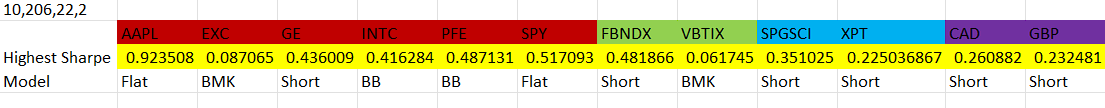

# 8

In [22]:
# Filter the DataFrame to include only the specified strategies
myStrategies_df = master_df.loc[:, myStrategies]

# Save the filtered DataFrame as a CSV file
myStrategies_df

,AAPL-MAFlat,EXC-BMK-MA,FBNDX-MAShort,GBP-MAShort,GE-MAShort,INTC-BB,PFE-BB,SPGSCI-MAShort
Date,,,,,,,,
2000-10-24,-0.0,-0.019700,0.000000,0.002548,0.070332,-0.000000,-0.000000,-0.009091
2000-10-25,-0.0,0.018673,-0.002845,0.012491,-0.008230,-0.000000,0.000000,-0.013888
2000-10-26,0.0,-0.073555,0.000000,-0.003068,-0.015467,0.000000,0.000000,0.004912
2000-10-27,0.0,0.026202,-0.002853,-0.012866,0.002395,0.000000,-0.000000,-0.019424
2000-10-30,0.0,0.046324,0.000000,0.003925,0.032944,-0.000000,-0.000000,-0.001823
...,...,...,...,...,...,...,...,...
2018-12-24,-0.0,-0.045929,-0.001303,-0.004812,0.032697,-0.028273,-0.000000,0.034847
2018-12-26,0.0,0.014721,0.003914,0.005762,-0.065712,0.057936,0.039647,-0.034605
2018-12-27,-0.0,0.006722,0.002618,-0.000870,0.016371,0.003674,0.015522,0.016042


# 9

In [23]:
myStrategies_df

,AAPL-MAFlat,EXC-BMK-MA,FBNDX-MAShort,GBP-MAShort,GE-MAShort,INTC-BB,PFE-BB,SPGSCI-MAShort
Date,,,,,,,,
2000-10-24,-0.0,-0.019700,0.000000,0.002548,0.070332,-0.000000,-0.000000,-0.009091
2000-10-25,-0.0,0.018673,-0.002845,0.012491,-0.008230,-0.000000,0.000000,-0.013888
2000-10-26,0.0,-0.073555,0.000000,-0.003068,-0.015467,0.000000,0.000000,0.004912
2000-10-27,0.0,0.026202,-0.002853,-0.012866,0.002395,0.000000,-0.000000,-0.019424
2000-10-30,0.0,0.046324,0.000000,0.003925,0.032944,-0.000000,-0.000000,-0.001823
...,...,...,...,...,...,...,...,...
2018-12-24,-0.0,-0.045929,-0.001303,-0.004812,0.032697,-0.028273,-0.000000,0.034847
2018-12-26,0.0,0.014721,0.003914,0.005762,-0.065712,0.057936,0.039647,-0.034605
2018-12-27,-0.0,0.006722,0.002618,-0.000870,0.016371,0.003674,0.015522,0.016042


In [24]:
myStrategies_df.corr()

,AAPL-MAFlat,EXC-BMK-MA,FBNDX-MAShort,GBP-MAShort,GE-MAShort,INTC-BB,PFE-BB,SPGSCI-MAShort
AAPL-MAFlat,1.000000,0.127781,0.007894,0.013506,-0.029455,0.033324,0.025777,0.017739
EXC-BMK-MA,0.127781,1.000000,-0.035223,-0.080006,-0.161331,0.091829,0.182154,-0.088248
FBNDX-MAShort,0.007894,-0.035223,1.000000,0.042286,0.022025,-0.003645,-0.015284,-0.036323
GBP-MAShort,0.013506,-0.080006,0.042286,1.000000,0.086818,0.010095,-0.065807,0.117367
GE-MAShort,-0.029455,-0.161331,0.022025,0.086818,1.000000,-0.109782,-0.161576,0.108389
INTC-BB,0.033324,0.091829,-0.003645,0.010095,-0.109782,1.000000,0.143967,-0.004733
PFE-BB,0.025777,0.182154,-0.015284,-0.065807,-0.161576,0.143967,1.000000,-0.041281
SPGSCI-MAShort,0.017739,-0.088248,-0.036323,0.117367,0.108389,-0.004733,-0.041281,1.000000


1. Low Overall Correlations → Good Diversification
Most of the correlation values are close to zero, meaning the instruments are largely uncorrelated.
This suggests low systematic risk and better risk-adjusted returns, as the assets do not move together in extreme ways.
2. Weak Positive Correlations
AAPL-MAFlat & EXC-BMK-MA (0.1278):

AAPL and EXC show some positive correlation, but it remains weak, meaning they do not move in lockstep.
EXC being in BMK-MA suggests it's following a more stable trend, while AAPL (MAFlat) follows a momentum strategy.
PFE-BB & EXC-BMK-MA (0.1821):

PFE and EXC have the highest positive correlation in your portfolio, but it is still relatively low.
Both healthcare (PFE) and utilities (EXC) are defensive sectors, which could explain some shared movement.
PFE-BB & INTC-BB (0.1439):

Both are using Bollinger Bands, which might explain the slight correlation.
This is expected, as BB strategies respond to volatility-based price movements.
3. Weak Negative Correlations → Slight Hedging Effects
GE-MAShort & EXC-BMK-MA (-0.1613):

GE (MAShort) and EXC (BMK-MA) have a slightly negative correlation, meaning one may rise when the other falls.
This adds a hedging effect, as EXC is a more stable asset, while GE is being shorted.
GE-MAShort & PFE-BB (-0.1616):

GE (short strategy) and PFE (Bollinger Bands) show negative correlation, which suggests that GE's downward trends might align with PFE’s market reactions in an opposite manner.
GBP-MAShort & EXC-BMK-MA (-0.0800):

GBP (MAShort) and EXC (BMK-MA) have mild inverse movements, suggesting that currency and utility stocks are behaving differently under current market conditions.

# 10

In [25]:
sharpe_ratio = ((np.array([0.125] * 8) * myStrategies_df).sum(axis=1).mean() * 256) / ((np.array([0.125] * 8) * myStrategies_df).sum(axis=1).std() * np.sqrt(256))
sharpe_ratio

1.131516438445769

In [26]:
perf_stats = calcPerformanceStatistics(myStrategies_df)

Yes the equal weight portfolio does beat the sharpes of individual stocks

# 11

In [27]:
import numpy as np
import pandas as pd

# Set seed for reproducibility
rng = np.random.default_rng(seed=64)

# Simulation parameters
n_simulations = 5000
n_assets = myStrategies_df.shape[1]
annualization_factor = 252  # Trading days in a year

# Initialize lists to store results
port_returns = []
port_risks = []
weights_list = []

# Monte Carlo Simulation
for _ in range(n_simulations):
    # Generate random weights & normalize to sum to 1
    wts = rng.random(n_assets)
    wts /= np.sum(wts)  
    
    # Correct Risk Calculation using Covariance Matrix
    port_risk = np.sqrt(np.dot(wts.T, np.dot(myStrategies_df.cov() * annualization_factor, wts)))

    # Correct Return Calculation (same as before)
    port_return = np.sum(wts * myStrategies_df.mean()) * annualization_factor
    # Store results
    port_returns.append(port_return)
    port_risks.append(port_risk)
    weights_list.append(wts)

# Convert results into DataFrame
efficient_frontier = pd.DataFrame({
    'Portfolio Risk': port_risks,
    'Portfolio Return': port_returns
})

print(efficient_frontier)
print("Efficient Frontier Simulations Completed.")


      Portfolio Risk  Portfolio Return
0           0.102620          0.116666
1           0.088618          0.082692
2           0.084891          0.084038
3           0.108925          0.129456
4           0.076598          0.083385
...              ...               ...
4995        0.070576          0.068828
4996        0.112044          0.103549
4997        0.081018          0.072970
4998        0.132543          0.105561
4999        0.099391          0.082016

[5000 rows x 2 columns]
Efficient Frontier Simulations Completed.


# 12

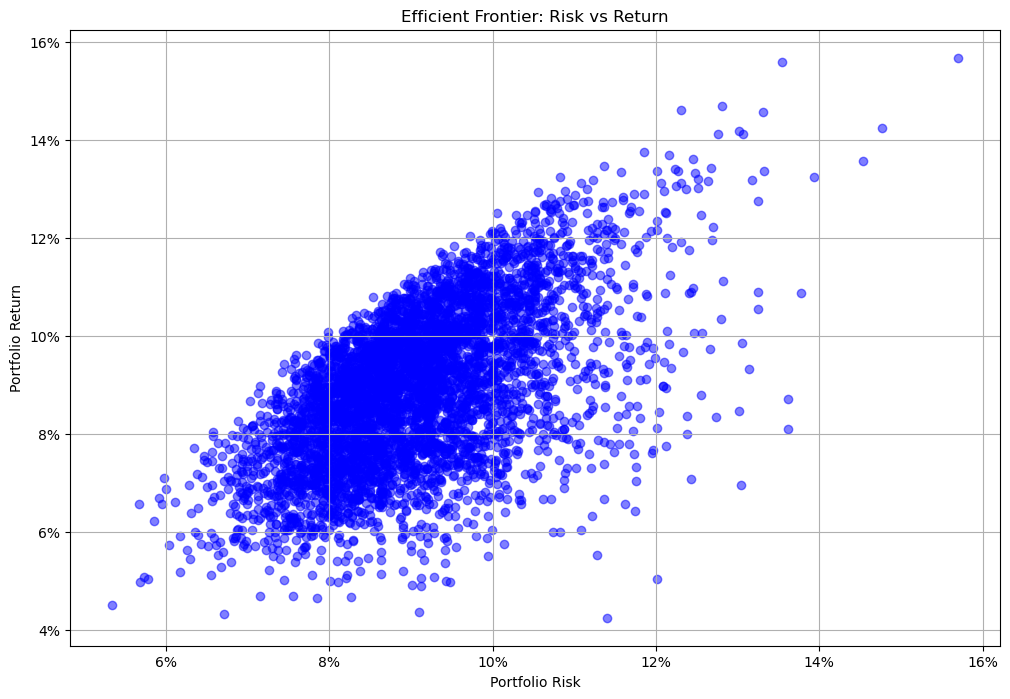

In [28]:
# Plot Risk/Return Scatter Plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(efficient_frontier['Portfolio Risk'], efficient_frontier['Portfolio Return'], c='blue', alpha=0.5)
ax.set_title("Efficient Frontier: Risk vs Return")
ax.set_xlabel("Portfolio Risk")
ax.set_ylabel("Portfolio Return")
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
plt.grid(True)
plt.show()

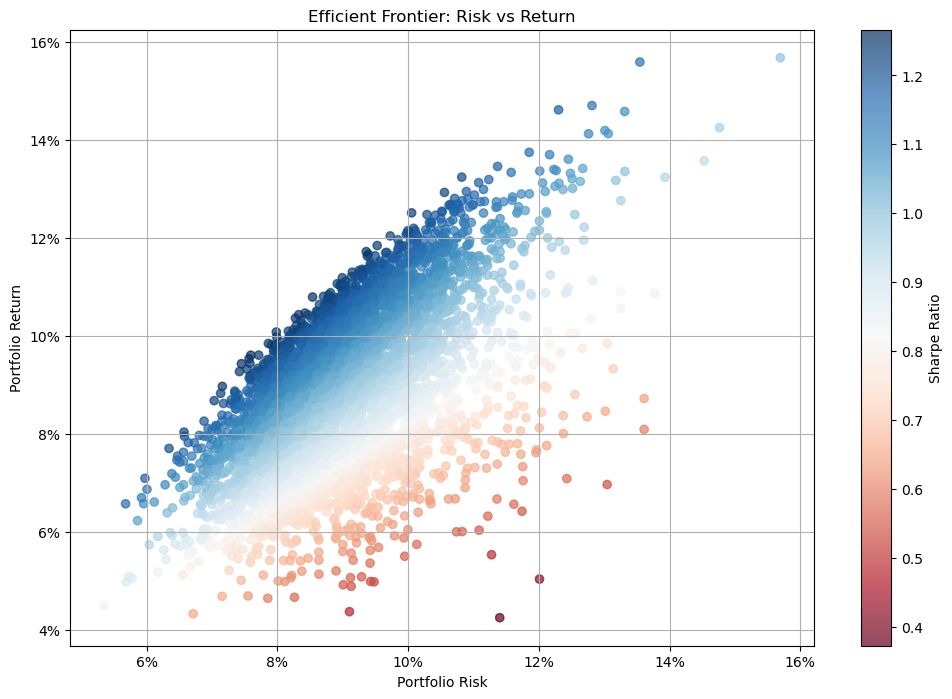

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))

# Calculate Sharpe ratios (assuming a risk-free rate of 0)
risk_free_rate = 0
sharpe_ratios = (np.array(port_returns) - risk_free_rate) / np.array(port_risks)

# Create the scatter plot with color based on Sharpe ratio
scatter = ax.scatter(efficient_frontier['Portfolio Risk'], efficient_frontier['Portfolio Return'],
                     c=sharpe_ratios, cmap=plt.get_cmap('RdBu'), alpha=0.7)

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio')

ax.set_title("Efficient Frontier: Risk vs Return")
ax.set_xlabel("Portfolio Risk")
ax.set_ylabel("Portfolio Return")
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
plt.grid(True)
plt.show()

# 13

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


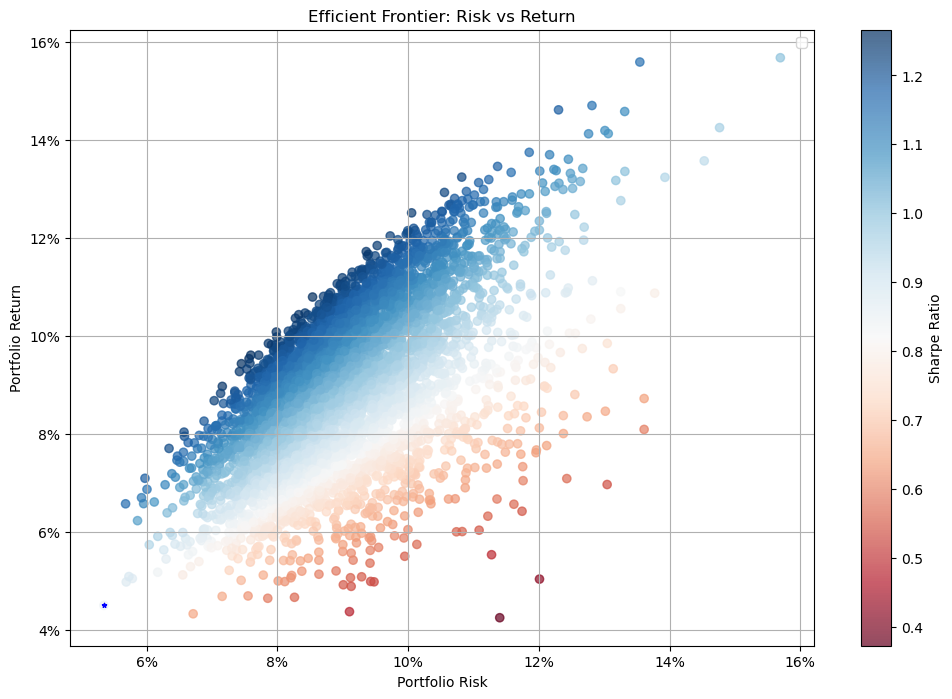

Min Vol Weights: [0.02835177 0.08931055 0.46111243 0.13680611 0.00898709 0.04845132
 0.05982185 0.16715889]


In [30]:
# Identify Minimum Volatility Portfolio
min_vol_idx = np.argmin(port_risks)
min_vol_risk = port_risks[min_vol_idx]
min_vol_return = port_returns[min_vol_idx]

# Plot Risk/Return Scatter Plot with Colorbar
fig, ax = plt.subplots(figsize=(12, 8))

# Create the scatter plot with color based on Sharpe ratio
scatter = ax.scatter(efficient_frontier['Portfolio Risk'], efficient_frontier['Portfolio Return'],
                     c=sharpe_ratios, cmap=plt.get_cmap('RdBu'), alpha=0.7)

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio')

# Mark Minimum Volatility Portfolio
ax.scatter(min_vol_risk, min_vol_return, color='blue', marker='*', s=10)
ax.legend()

ax.set_title("Efficient Frontier: Risk vs Return")
ax.set_xlabel("Portfolio Risk")
ax.set_ylabel("Portfolio Return")
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
plt.grid(True)
plt.show()

min_sharpe_weights = weights_list[min_vol_idx]
print(f"Min Vol Weights: {min_sharpe_weights}")

The minimum volatility (Min Vol) portfolio weights indicate that higher-risk stocks, such as AAPL, have received lower allocations, which aligns with the objective of minimizing overall portfolio volatility.

# 14

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


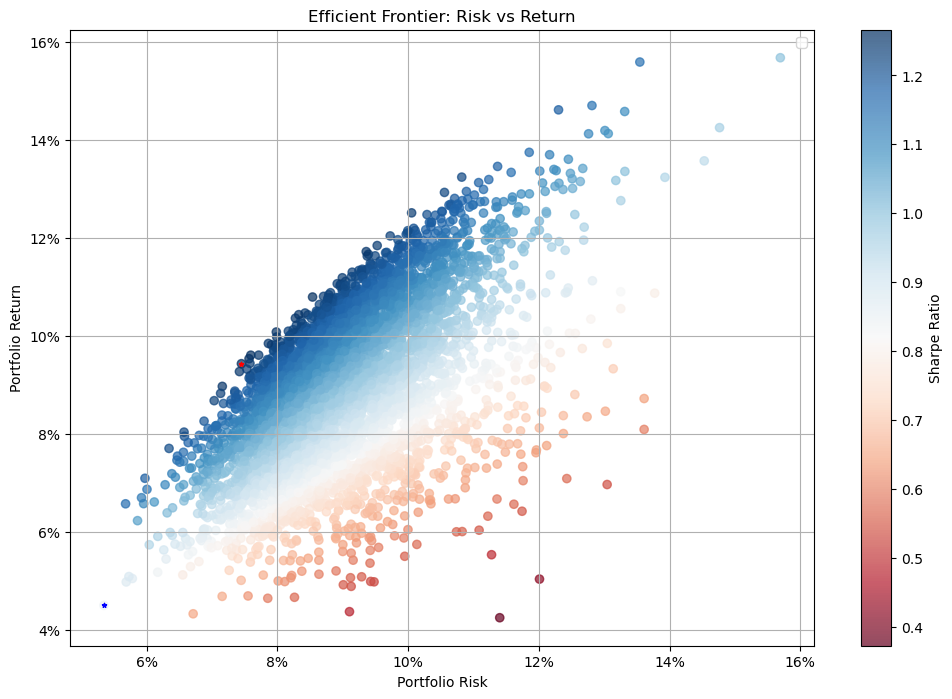

In [31]:
# Identify Maximum Sharpe Ratio Portfolio
max_sharpe_idx = np.argmax(sharpe_ratios)
max_sharpe_risk = port_risks[max_sharpe_idx]
max_sharpe_return = port_returns[max_sharpe_idx]

# Plot Risk/Return Scatter Plot with Colorbar
fig, ax = plt.subplots(figsize=(12, 8))

# Create the scatter plot with color based on Sharpe ratio
scatter = ax.scatter(efficient_frontier['Portfolio Risk'], efficient_frontier['Portfolio Return'],
                     c=sharpe_ratios, cmap=plt.get_cmap('RdBu'), alpha=0.7)

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio')

# Mark Minimum Volatility Portfolio
ax.scatter(min_vol_risk, min_vol_return, color='blue', marker='*', s=10)

# Mark Maximum Sharpe Ratio Portfolio
ax.scatter(max_sharpe_risk, max_sharpe_return, color='red', marker='*', s=10)
ax.legend()

ax.set_title("Efficient Frontier: Risk vs Return")
ax.set_xlabel("Portfolio Risk")
ax.set_ylabel("Portfolio Return")
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
plt.grid(True)
plt.show()


In [32]:
max_sharpe_return

0.09433557973412629

In [33]:
max_sharpe_weights = weights_list[max_sharpe_idx]
print(f"Max Sharpe Weights: {max_sharpe_weights}")



Max Sharpe Weights: [0.17424635 0.04872283 0.22737574 0.13063405 0.10502967 0.10621861
 0.16199126 0.0457815 ]


Higher Weights for Stronger Return-to-Risk Assets

FBNDX-MAShort (0.2274) and AAPL-MAFlat (0.1742) have the highest weights, suggesting these strategies offer the best Sharpe ratio contributions.
PFE-BB (0.1619) and GBP-MAShort (0.1306) also have relatively strong allocations, indicating they provide good diversification with strong return potential.
Balanced Exposure Across Strategies

Unlike the Min Vol portfolio, where high-volatility stocks received very little weight, the Max Sharpe portfolio gives a higher allocation to AAPL (0.1742), indicating that despite its risk, it provides strong return potential.
GE-MAShort (0.1050) and INTC-BB (0.1062) are included with moderate weights, likely contributing to a mix of momentum and volatility-based strategies.

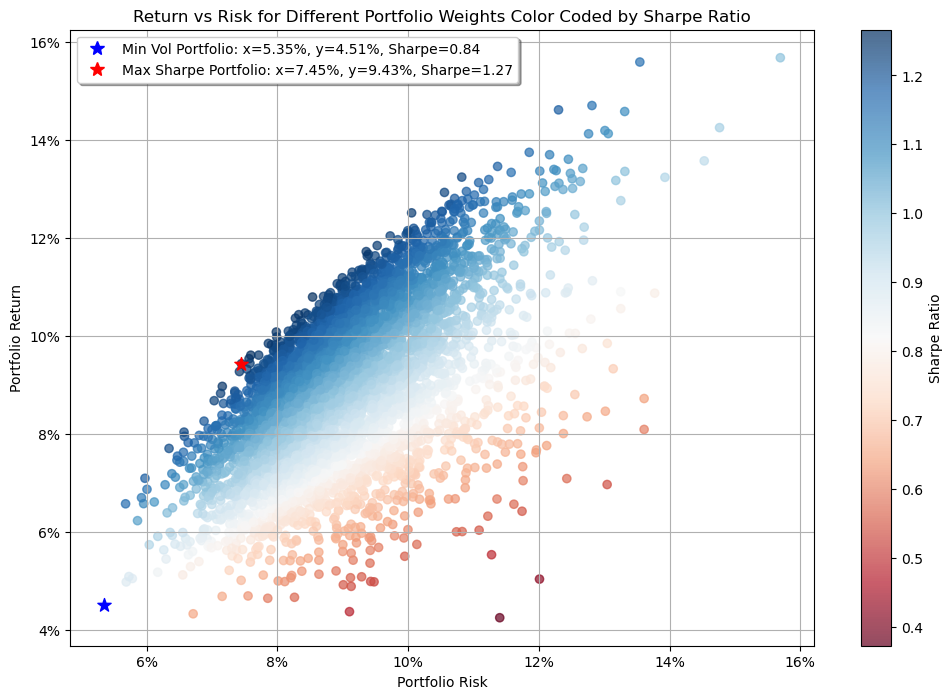

In [34]:
import matplotlib.lines as mlines

# Calculate Max and Min Vol Sharpe Ratios
max_sharpe_ratio = sharpe_ratios[max_sharpe_idx]
min_vol_sharpe_ratio = sharpe_ratios[min_vol_idx]  # Ensure you have this value

# Create custom legend handles with Sharpe ratios
min_vol_marker = mlines.Line2D([], [], color='blue', marker='*', linestyle='None', markersize=10, 
                               label=f"Min Vol Portfolio: x={min_vol_risk:.2%}, y={min_vol_return:.2%}, Sharpe={min_vol_sharpe_ratio:.2f}")
max_sharpe_marker = mlines.Line2D([], [], color='red', marker='*', linestyle='None', markersize=10, 
                                  label=f"Max Sharpe Portfolio: x={max_sharpe_risk:.2%}, y={max_sharpe_return:.2%}, Sharpe={max_sharpe_ratio:.2f}")

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot with color based on Sharpe ratio
scatter = ax.scatter(efficient_frontier['Portfolio Risk'], efficient_frontier['Portfolio Return'],
                     c=sharpe_ratios, cmap=plt.get_cmap('RdBu'), alpha=0.7)

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio')

# Mark Minimum Volatility Portfolio
ax.scatter(min_vol_risk, min_vol_return, color='blue', marker='*', s=100, label='Min Vol Portfolio')

# Mark Maximum Sharpe Ratio Portfolio
ax.scatter(max_sharpe_risk, max_sharpe_return, color='red', marker='*', s=100, label='Max Sharpe Portfolio')

# Construct the legend with proper markers
ax.legend(handles=[min_vol_marker, max_sharpe_marker], loc="upper left", fontsize=10, frameon=True, fancybox=True, shadow=True)

# Format axes
ax.set_title("Return vs Risk for Different Portfolio Weights Color Coded by Sharpe Ratio")
ax.set_xlabel("Portfolio Risk")
ax.set_ylabel("Portfolio Return")

# Correct Percent Formatting without Decimals
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))

plt.grid(True)
plt.show()


# 15

Is the maximum Sharpe higher than the equal weight Sharpe from #10 above? 

Yes, the max sharpe ratio is higher than equal weighted 
1.27>1.14

# 16

In [35]:
# Ensure weights are a NumPy array with float64 precision
max_sharpe_weights = np.array(max_sharpe_weights, dtype=np.float64)

# Select only asset columns to avoid errors
asset_columns = myStrategies_df.columns[:len(max_sharpe_weights)]
myStrategies_df['Portfolio Return'] = myStrategies_df[asset_columns].dot(max_sharpe_weights)

# Display updated DataFrame
print(myStrategies_df.head())


            AAPL-MAFlat  EXC-BMK-MA  FBNDX-MAShort  GBP-MAShort  GE-MAShort  \
Date                                                                          
2000-10-24         -0.0   -0.019700       0.000000     0.002548    0.070332   
2000-10-25         -0.0    0.018673      -0.002845     0.012491   -0.008230   
2000-10-26          0.0   -0.073555       0.000000    -0.003068   -0.015467   
2000-10-27          0.0    0.026202      -0.002853    -0.012866    0.002395   
2000-10-30          0.0    0.046324       0.000000     0.003925    0.032944   

            INTC-BB  PFE-BB  SPGSCI-MAShort  Portfolio Return  
Date                                                           
2000-10-24     -0.0    -0.0       -0.009091          0.006344  
2000-10-25     -0.0     0.0       -0.013888          0.000394  
2000-10-26      0.0     0.0        0.004912         -0.005384  
2000-10-27      0.0    -0.0       -0.019424         -0.001690  
2000-10-30     -0.0    -0.0       -0.001823          0.006146 

In [36]:
# Ensure portfolio_returns is a DataFrame (if it's not already)
portfolio_returns = pd.DataFrame(myStrategies_df['Portfolio Return'])

# Run the performance statistics calculation
perf_stats = calcPerformanceStatistics(myStrategies_df)

# Output the performance statistics DataFrame
perf_stats

,AAPL-MAFlat,EXC-BMK-MA,FBNDX-MAShort,GBP-MAShort,GE-MAShort,INTC-BB,PFE-BB,SPGSCI-MAShort,Portfolio Return
Average Annual Return,25.8837%,2.2351%,1.8293%,2.2152%,13.5344%,10.7859%,9.0279%,8.2797%,9.7330%
Annual Risk,28.0276%,25.6718%,3.7963%,9.5284%,31.0417%,25.9099%,18.5328%,23.5872%,7.5675%
Sharpe Ratio,0.923508,0.087065,0.481866,0.232481,0.436009,0.416284,0.487131,0.351025,1.286162
maxDD,-59.7174%,-128.0759%,-10.6715%,-30.4199%,-92.6431%,-45.3300%,-30.5111%,-79.4548%,-9.4349%
Success Ratio,39.0249%,51.4211%,38.3909%,50.5028%,50.1093%,26.3883%,27.4814%,51.3555%,54.5256%


In [37]:
max_sharpe_return

0.09433557973412629

In [38]:
max_sharpe_risk

0.07450168666636643

We can see improvement in every aspect
1) Average Annual Return is higher than most securities
2) Risk is Lower than most securities
3) Sharpe is much higher than individual securities
4) max DD is lowest
5) Highest success ratio

# 17

In [39]:
import statsmodels.api as sm

# Ensure Portfolio Return and SPY-BMK-MA are aligned
portfolio_returns = myStrategies_df['Portfolio Return']
spy_returns = master_df['SPY-BMK-MA']

# Drop NaN values to ensure proper alignment
portfolio_returns_clean = portfolio_returns.dropna()
spy_returns_clean = spy_returns.dropna()

# Create X and Y for regression model
X = spy_returns_clean
X = sm.add_constant(X)  # Add constant to include the intercept
y = portfolio_returns_clean

# Fit the OLS regression model
portfolio_Reg = sm.OLS(y, X)
portfolio_Reg = portfolio_Reg.fit()

# Output the summary of the regression
print(portfolio_Reg.summary())

# Extract the alpha (constant) and beta terms
alpha = portfolio_Reg.params['const']  # The alpha term
beta = portfolio_Reg.params['SPY-BMK-MA']  # The beta term

print(f"Portfolio Alpha: {alpha}")
print(f"Portfolio Beta: {beta}")


                            OLS Regression Results                            
Dep. Variable:       Portfolio Return   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     315.5
Date:                Mon, 17 Mar 2025   Prob (F-statistic):           2.63e-68
Time:                        23:24:38   Log-Likelihood:                 18187.
No. Observations:                4574   AIC:                        -3.637e+04
Df Residuals:                    4572   BIC:                        -3.636e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004   6.71e-05      5.390      0.0

Beta (β) = 0.099 → Portfolio has very low correlation with the SPY benchmark.
Interpretation: Low market sensitivity → Portfolio moves only 0.099% for every 1% SPY move.
Minimal systematic risk → Less affected by overall market trends.
Not leveraged to SPY → Portfolio returns are largely independent.
BETA VALUE

# 18

In [43]:
import numpy as np

# Define equal weights for 8 securities
weights = np.array([1/8] * 8)
securities_filtered = ['AAPL', 'EXC', 'FBNDX', 'GBP', 'GE', 'INTC', 'PFE', 'SPGSCI']

# --- (a) Benchmark-Only Portfolio ---
benchmark_columns = [col for col in master_df.columns if any(sec in col for sec in securities_filtered) and '-BMK-MA' in col]
benchmark_returns = (weights * master_df[benchmark_columns]).sum(axis=1)  # Weighted sum

sharpe_benchmark = (benchmark_returns.mean() * 256) / (benchmark_returns.std() * np.sqrt(256))
print(f"Sharpe Ratio for Benchmark-only Portfolio: {sharpe_benchmark}")

# --- (b) MAFlat Strategy Portfolio ---
maflat_columns = [col for col in master_df.columns if any(sec in col for sec in securities_filtered) and '-MAFlat' in col]
maflat_returns = (weights * master_df[maflat_columns]).sum(axis=1)

sharpe_maflat = (maflat_returns.mean() * 256) / (maflat_returns.std() * np.sqrt(256))
print(f"Sharpe Ratio for MAFlat Portfolio: {sharpe_maflat}")

# --- (c) MAShort Strategy Portfolio ---
mashort_columns = [col for col in master_df.columns if any(sec in col for sec in securities_filtered) and '-MAShort' in col]
mashort_returns = (weights * master_df[mashort_columns]).sum(axis=1)

sharpe_mashort = (mashort_returns.mean() * 256) / (mashort_returns.std() * np.sqrt(256))
print(f"Sharpe Ratio for MAShort Portfolio: {sharpe_mashort}")

# --- (d) Bollinger Band (BB) Strategy Portfolio ---
bb_columns = [col for col in master_df.columns if any(sec in col for sec in securities_filtered) and '-BB' in col]
bb_columns_regular = [col for col in bb_columns if '-BMK-BB' not in col]
weights_regular = np.array([1/8] * 8)  # Same as original weights for only regular BB columns

# Now compute bb_returns with the updated bb_columns_regular
bb_returns = (weights_regular * master_df[bb_columns_regular]).sum(axis=1)
sharpe_bb = (bb_returns.mean() * 256) / (bb_returns.std() * np.sqrt(256))
print(f"Sharpe Ratio for Bollinger Band Portfolio: {sharpe_bb}")


Sharpe Ratio for Benchmark-only Portfolio: 0.17524704758832063
Sharpe Ratio for MAFlat Portfolio: 0.5812338888866831
Sharpe Ratio for MAShort Portfolio: 0.5032585077061397
Sharpe Ratio for Bollinger Band Portfolio: 0.14210031422047245


Do any of these 4 portfolios outperform your chosen maxSharpe portfolio?
No, none of them do

---

"We pledge on our honor that we have not given nor received any unauthorized assistance on this
assignment to/from other groups. Nor have we received any assistance from prior year students."
- Piyali Bedagkar, Anudeep Koneru, Sriyesh Karampuri, Harsha Vardhan Simma